In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy() # 转换为numpy
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]: # 从后往前 最新的在最后
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse() # 从前往后顺序
    return torch.tensor(advantage_list, dtype=torch.float)

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x): # 前向传播 在进行训练时会自动调用
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) # dim=1表示对第二维度进行softmax操作 softmax输出的是概率值


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()  # 继承父类的所有属性
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma # 折扣因子
        self.lmbda = lmbda # GAE的参数 越大越偏向于长期奖励 越小越偏向于短期奖励 =1时等价于MC. =0时等价于TD
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state): 
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs) #Catagorical是一个分布类
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)

        td_delta = td_target - self.critic(states) # 在时间t+1步的TD误差 优势函数值
        advantage = compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device) # 返回了一个tensor列表，每个元素是一个优势函数值

        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach() # 旧的log*动作概率

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions)) # 新的log*动作概率 因为每次都迭代更新了
            ratio = torch.exp(log_probs - old_log_probs) # 新旧动作概率的比值 exp(log(a/b)) = a/b
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断 clip(ratio,1-eps,1+eps) = min(max(ratio,1-eps),1+eps)

            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数 mean也对advantage求了均值 GAE先求均值 和 后求结果一样
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach())) # 价值网络的损失函数
            # 更新
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step() # 这里每次迭代了
            self.critic_optimizer.step()

In [7]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0' #动作是
env = gym.make(env_name)
#env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s, episode=50,
# return=183.200]
# Iteration 1: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=100,
# return=191.400]
# Iteration 2: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=150,
# return=199.900]
# Iteration 3: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s, episode=200,
# return=200.000]
# Iteration 4: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s, episode=250,
# return=200.000]
# Iteration 5: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s, episode=300,
# return=200.000]
# Iteration 6: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s, episode=350,
# return=200.000]
# Iteration 7: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s, episode=400,
# return=200.000]
# Iteration 8: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s, episode=450,
# return=200.000]
# Iteration 9: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s, episode=500,
# return=200.000]

Iteration 0:   4%|▍         | 2/50 [00:00<00:03, 13.20it/s]

state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


Iteration 0:   8%|▊         | 4/50 [00:00<00:03, 12.89it/s]

state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


Iteration 0:  20%|██        | 10/50 [00:00<00:02, 18.39it/s, episode=10, return=21.900]

state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


Iteration 0:  24%|██▍       | 12/50 [00:00<00:02, 16.71it/s, episode=10, return=21.900]


state: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


KeyboardInterrupt: 

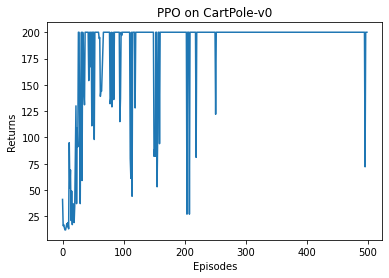

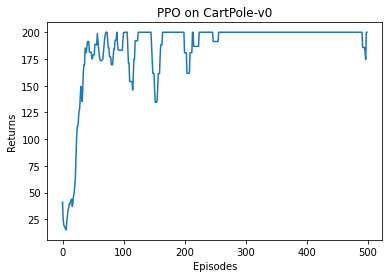

In [3]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [42]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim) # 均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim) # 方差
 
    def forward(self, x):
        x = F.relu(self.fc1(x)) # 激活函数
        mu = 2.0 * torch.tanh(self.fc_mu(x)) #从[-1,1]*2 确保均值范围为[-2,2]
        std = F.softplus(self.fc_std(x)) # 保证方差为正数 softplus = log(1+exp(x))
        return mu, std # 返回高斯分布的均值和方差


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)  # normal是正态分布
        action = action_dist.sample()
        return [action.item()] # 返回一个动作 这里[]是因为返回的是一个列表

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 4.0) / 4.0  # 和TRPO一样,对奖励进行修改,方便训练 
        #其中rewards+8

        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)
        td_delta = td_target - self.critic(states)
        print(td_target)
        #print(self.critic(states))
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)

        # 这三步和离散动作的PPO不一样
        mu, std = self.actor(states)  
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())### # 动作是正态分布 得出动作的概率
        old_log_probs = action_dists.log_prob(actions)
        #print("mu",mu,"std",std)
        for _ in range(self.epochs):
            mu, std = self.actor(states) ##
            action_dists = torch.distributions.Normal(mu, std) ##
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))  
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        

In [25]:
from tqdm import tqdm
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset(seed =0)[0] #1.改 gym 0.26.0版本后，env.reset()返回的是一个字典，所以需要加上[0]
                #print('state:',state)
                done = False
                while not done:
                    action = agent.take_action(state) 
                    #next_state, reward, done, _ = env.step(action)[0:4] #2.改
                    next_state, reward,terminated, truncated, _ = env.step(action) #2.改看gym版本0.26.2版本的 
                    done = terminated or truncated
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    #print(transition_dict)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [43]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
#env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 200/200 [02:15<00:00,  1.47it/s, episode=200,
# return=-984.137]
# Iteration 1: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=400,
# return=-895.332]
# Iteration 2: 100%|██████████| 200/200 [02:14<00:00,  1.48it/s, episode=600,
# return=-518.916]
# Iteration 3: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s, episode=800,
# return=-602.183]
# Iteration 4: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1000,
# return=-392.104]
# Iteration 5: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1200,
# return=-259.206]
# Iteration 6: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1400,
# return=-221.772]
# Iteration 7: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1600,
# return=-293.515]
# Iteration 8: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1800,
# return=-371.194]
# Iteration 9: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=2000,
# return=-248.958]

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]d:\softwares\anaconda3\envs\myrl\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 0:   1%|          | 1/100 [00:00<00:39,  2.52it/s]

tensor([[ 8.2690e-01],
        [ 9.4722e-01],
        [ 1.0429e+00],
        [ 1.0267e+00],
        [ 9.7692e-01],
        [ 9.1989e-01],
        [ 8.1691e-01],
        [ 6.9007e-01],
        [ 4.6838e-01],
        [ 2.6262e-01],
        [-1.0174e-01],
        [-4.6826e-01],
        [-8.8652e-01],
        [-1.4113e+00],
        [-8.9393e-01],
        [-4.2076e-01],
        [ 6.0049e-02],
        [ 4.1596e-01],
        [ 6.6730e-01],
        [ 8.8529e-01],
        [ 9.8237e-01],
        [ 1.0545e+00],
        [ 9.7834e-01],
        [ 9.5642e-01],
        [ 9.1493e-01],
        [ 8.7456e-01],
        [ 8.0328e-01],
        [ 7.0332e-01],
        [ 5.3803e-01],
        [ 2.4503e-01],
        [-8.8869e-02],
        [-6.0430e-01],
        [-1.2034e+00],
        [-1.8594e+00],
        [-2.0783e+00],
        [-1.6779e+00],
        [-1.2542e+00],
        [-8.5047e-01],
        [-4.7202e-01],
        [-1.6741e-01],
        [ 9.2087e-02],
        [ 2.5348e-01],
        [ 3.9762e-01],
        [ 5

Iteration 0:   2%|▏         | 2/100 [00:00<00:32,  2.97it/s]

tensor([[ 1.0403],
        [ 1.1407],
        [ 1.1507],
        [ 1.0687],
        [ 0.9322],
        [ 0.7275],
        [ 0.4903],
        [ 0.1318],
        [-0.3046],
        [-0.7467],
        [-1.3667],
        [-1.8347],
        [-2.4370],
        [-2.1156],
        [-1.4895],
        [-0.8710],
        [-0.3493],
        [ 0.1252],
        [ 0.4353],
        [ 0.7412],
        [ 0.9579],
        [ 1.0090],
        [ 1.0541],
        [ 1.0108],
        [ 0.8906],
        [ 0.7418],
        [ 0.5349],
        [ 0.2859],
        [-0.0189],
        [-0.4122],
        [-0.9413],
        [-1.5747],
        [-2.2767],
        [-2.9559],
        [-3.5511],
        [-3.0403],
        [-2.4396],
        [-1.8151],
        [-1.2592],
        [-0.7783],
        [-0.3515],
        [ 0.0369],
        [ 0.3457],
        [ 0.5990],
        [ 0.8045],
        [ 0.9140],
        [ 0.9040],
        [ 0.8022],
        [ 0.6509],
        [ 0.4610],
        [ 0.1333],
        [-0.2124],
        [-0.

Iteration 0:   3%|▎         | 3/100 [00:01<00:33,  2.91it/s]

tensor([[ 9.9238e-01],
        [ 1.0752e+00],
        [ 1.0086e+00],
        [ 8.0969e-01],
        [ 4.7893e-01],
        [ 9.4657e-02],
        [-3.7380e-01],
        [-9.4035e-01],
        [-1.6743e+00],
        [-2.5764e+00],
        [-3.4808e+00],
        [-4.1788e+00],
        [-4.6548e+00],
        [-4.4067e+00],
        [-3.6064e+00],
        [-2.7133e+00],
        [-1.8024e+00],
        [-1.0664e+00],
        [-4.9387e-01],
        [ 3.5941e-02],
        [ 4.6187e-01],
        [ 7.1419e-01],
        [ 8.7188e-01],
        [ 9.6086e-01],
        [ 9.6317e-01],
        [ 8.8900e-01],
        [ 7.2314e-01],
        [ 4.0805e-01],
        [-9.7866e-03],
        [-5.7509e-01],
        [-1.2505e+00],
        [-1.9771e+00],
        [-2.7438e+00],
        [-3.5731e+00],
        [-4.4852e+00],
        [-5.2420e+00],
        [-5.7717e+00],
        [-5.0034e+00],
        [-4.1875e+00],
        [-3.2906e+00],
        [-2.4701e+00],
        [-1.8313e+00],
        [-1.1585e+00],
        [-5

Iteration 0:   4%|▍         | 4/100 [00:01<00:31,  3.09it/s]

tensor([[ 1.0795],
        [ 1.1509],
        [ 1.0900],
        [ 0.8584],
        [ 0.5046],
        [ 0.0759],
        [-0.4732],
        [-1.1127],
        [-1.8221],
        [-2.5646],
        [-3.5907],
        [-4.5715],
        [-5.3174],
        [-5.8309],
        [-5.8097],
        [-4.9060],
        [-3.9308],
        [-3.0310],
        [-2.0088],
        [-1.1273],
        [-0.3874],
        [ 0.2326],
        [ 0.7318],
        [ 0.9470],
        [ 0.9446],
        [ 0.6891],
        [ 0.2784],
        [-0.3986],
        [-1.1200],
        [-1.9383],
        [-2.7276],
        [-3.6343],
        [-4.3920],
        [-5.2285],
        [-5.9387],
        [-6.4310],
        [-5.9465],
        [-5.0339],
        [-4.1506],
        [-3.1181],
        [-2.2435],
        [-1.2881],
        [-0.5274],
        [-0.0531],
        [ 0.3070],
        [ 0.4630],
        [ 0.2038],
        [-0.2553],
        [-0.8165],
        [-1.5302],
        [-2.2106],
        [-2.9672],
        [-3.

Iteration 0:   5%|▌         | 5/100 [00:01<00:29,  3.22it/s]

tensor([[ 1.1804],
        [ 1.1509],
        [ 0.9311],
        [ 0.5254],
        [-0.1307],
        [-0.7187],
        [-1.5757],
        [-2.5219],
        [-3.6036],
        [-4.8233],
        [-5.8449],
        [-6.6003],
        [-7.1155],
        [-7.4877],
        [-6.7097],
        [-5.5476],
        [-4.2717],
        [-2.8953],
        [-1.7908],
        [-0.7683],
        [ 0.1940],
        [ 0.6974],
        [ 0.8149],
        [ 0.6413],
        [ 0.1673],
        [-0.7287],
        [-1.5625],
        [-2.6178],
        [-3.4190],
        [-4.3427],
        [-5.4222],
        [-6.3419],
        [-7.0733],
        [-7.3431],
        [-6.9678],
        [-6.0230],
        [-5.1549],
        [-4.2495],
        [-3.1611],
        [-2.0804],
        [-1.0478],
        [-0.4166],
        [ 0.1027],
        [ 0.3773],
        [ 0.2175],
        [-0.2654],
        [-0.8564],
        [-1.6290],
        [-2.5512],
        [-3.3352],
        [-4.1778],
        [-5.1046],
        [-5.

Iteration 0:   6%|▌         | 6/100 [00:01<00:28,  3.26it/s]

tensor([[ 1.2397e+00],
        [ 1.0391e+00],
        [ 7.0768e-01],
        [-7.9435e-03],
        [-8.1798e-01],
        [-1.6219e+00],
        [-2.6149e+00],
        [-3.7439e+00],
        [-4.8074e+00],
        [-6.2375e+00],
        [-7.4146e+00],
        [-8.2028e+00],
        [-8.5438e+00],
        [-8.5465e+00],
        [-7.3726e+00],
        [-5.9983e+00],
        [-4.4117e+00],
        [-2.8161e+00],
        [-1.4228e+00],
        [-1.8851e-01],
        [ 7.1142e-01],
        [ 1.1028e+00],
        [ 1.1956e+00],
        [ 1.1065e+00],
        [ 7.1331e-01],
        [-1.2069e-01],
        [-1.1871e+00],
        [-2.3772e+00],
        [-3.7125e+00],
        [-5.1270e+00],
        [-6.3078e+00],
        [-7.5140e+00],
        [-8.2113e+00],
        [-8.5450e+00],
        [-8.7109e+00],
        [-8.0561e+00],
        [-7.0148e+00],
        [-5.6451e+00],
        [-4.2063e+00],
        [-2.9710e+00],
        [-1.6367e+00],
        [-6.6445e-01],
        [-1.0550e-01],
        [ 8

Iteration 0:   7%|▋         | 7/100 [00:02<00:28,  3.30it/s]

tensor([[  1.3900],
        [  1.1653],
        [  0.7187],
        [  0.0648],
        [ -0.9921],
        [ -2.2633],
        [ -3.6030],
        [ -5.0632],
        [ -6.8373],
        [ -8.2875],
        [ -9.4085],
        [ -9.9601],
        [ -9.9511],
        [ -8.7536],
        [ -6.9329],
        [ -5.1063],
        [ -3.1875],
        [ -1.6208],
        [ -0.2567],
        [  0.8502],
        [  1.4439],
        [  1.8730],
        [  2.0222],
        [  2.0385],
        [  1.7554],
        [  1.2456],
        [  0.6703],
        [ -0.3476],
        [ -1.9602],
        [ -3.8394],
        [ -5.2936],
        [ -6.9749],
        [ -8.2371],
        [ -9.6786],
        [-10.6997],
        [-11.2550],
        [-11.3956],
        [ -9.9266],
        [ -8.0424],
        [ -6.0610],
        [ -4.2139],
        [ -2.5481],
        [ -1.1903],
        [ -0.2124],
        [  0.4853],
        [  0.9640],
        [  1.1814],
        [  1.0957],
        [  0.6429],
        [ -0.1835],


Iteration 0:   8%|▊         | 8/100 [00:02<00:27,  3.35it/s]

tensor([[  1.7064],
        [  1.3804],
        [  0.8849],
        [  0.1491],
        [ -0.7438],
        [ -2.0656],
        [ -3.3514],
        [ -5.0280],
        [ -6.6472],
        [ -8.1104],
        [ -9.2047],
        [ -9.9382],
        [-10.1465],
        [ -9.6418],
        [ -7.7358],
        [ -5.7884],
        [ -3.8511],
        [ -2.0113],
        [ -0.3494],
        [  0.7304],
        [  1.6482],
        [  2.2971],
        [  2.5934],
        [  2.5147],
        [  2.0688],
        [  1.3706],
        [ -0.0524],
        [ -1.4135],
        [ -3.3789],
        [ -5.3593],
        [ -7.0607],
        [ -8.5307],
        [ -9.6632],
        [-10.8797],
        [-11.7326],
        [-11.9906],
        [-10.5948],
        [ -8.4953],
        [ -6.5861],
        [ -4.4852],
        [ -2.6211],
        [ -1.1799],
        [ -0.0705],
        [  0.7198],
        [  1.1975],
        [  1.5378],
        [  1.8603],
        [  1.8983],
        [  1.7520],
        [  1.3891],


Iteration 0:   9%|▉         | 9/100 [00:02<00:26,  3.37it/s]

tensor([[ 2.0460e+00],
        [ 1.4730e+00],
        [ 6.3321e-01],
        [-3.1081e-01],
        [-1.6813e+00],
        [-3.2453e+00],
        [-4.9603e+00],
        [-6.6801e+00],
        [-8.2753e+00],
        [-9.4395e+00],
        [-1.0080e+01],
        [-1.0187e+01],
        [-9.8475e+00],
        [-8.7891e+00],
        [-6.6365e+00],
        [-4.3709e+00],
        [-2.2068e+00],
        [-3.7176e-01],
        [ 1.2229e+00],
        [ 2.2065e+00],
        [ 2.7664e+00],
        [ 2.8480e+00],
        [ 2.6331e+00],
        [ 2.2408e+00],
        [ 1.3466e+00],
        [ 4.7061e-02],
        [-1.2408e+00],
        [-2.6136e+00],
        [-4.5155e+00],
        [-6.1569e+00],
        [-7.5442e+00],
        [-8.7264e+00],
        [-9.6898e+00],
        [-1.0329e+01],
        [-1.0269e+01],
        [-9.8579e+00],
        [-8.6611e+00],
        [-6.8712e+00],
        [-4.9308e+00],
        [-2.9795e+00],
        [-1.2554e+00],
        [-2.4326e-03],
        [ 4.9100e-01],
        [ 3

Iteration 0:  10%|█         | 10/100 [00:03<00:26,  3.38it/s, episode=10, return=-1245.454]

tensor([[  2.1280],
        [  1.6697],
        [  0.8132],
        [ -0.0829],
        [ -1.0447],
        [ -2.4431],
        [ -3.8800],
        [ -5.5602],
        [ -7.1572],
        [ -8.3990],
        [ -9.4426],
        [ -9.9643],
        [ -9.9004],
        [ -9.2667],
        [ -7.9427],
        [ -5.5665],
        [ -3.2688],
        [ -1.1729],
        [  0.5181],
        [  1.8562],
        [  2.7359],
        [  3.2795],
        [  3.2582],
        [  2.6686],
        [  2.0137],
        [  0.6418],
        [ -1.2030],
        [ -2.5872],
        [ -4.2412],
        [ -5.9492],
        [ -7.4660],
        [ -8.8614],
        [ -9.8103],
        [-10.5183],
        [-10.6360],
        [-10.3061],
        [ -9.3479],
        [ -7.2616],
        [ -5.2027],
        [ -3.1212],
        [ -1.3165],
        [  0.1943],
        [  1.3003],
        [  1.8948],
        [  2.1146],
        [  1.9107],
        [  1.1997],
        [  0.2080],
        [ -1.3587],
        [ -2.9861],


Iteration 0:  11%|█         | 11/100 [00:03<00:26,  3.39it/s, episode=10, return=-1245.454]

tensor([[ 2.1536],
        [ 1.4444],
        [ 0.4985],
        [-0.6727],
        [-2.0254],
        [-3.4594],
        [-5.0617],
        [-6.6970],
        [-8.0157],
        [-9.1705],
        [-9.8181],
        [-9.8813],
        [-9.3390],
        [-8.2635],
        [-6.1292],
        [-3.8350],
        [-1.5648],
        [ 0.4282],
        [ 1.7744],
        [ 2.4981],
        [ 2.4864],
        [ 2.0725],
        [ 1.3070],
        [-0.1409],
        [-1.5317],
        [-3.3349],
        [-4.7057],
        [-5.9520],
        [-7.2252],
        [-8.4217],
        [-9.2902],
        [-9.8538],
        [-9.8862],
        [-9.5517],
        [-8.9528],
        [-7.5692],
        [-5.5533],
        [-3.5386],
        [-1.7404],
        [-0.2199],
        [ 0.7680],
        [ 1.0304],
        [ 0.7131],
        [-0.2167],
        [-1.3553],
        [-2.8809],
        [-4.1335],
        [-5.6884],
        [-6.9656],
        [-7.8859],
        [-8.5502],
        [-8.8960],
        [-8.

Iteration 0:  12%|█▏        | 12/100 [00:03<00:25,  3.40it/s, episode=10, return=-1245.454]

tensor([[  1.6787],
        [  0.9678],
        [ -0.0542],
        [ -1.2257],
        [ -2.4694],
        [ -3.8782],
        [ -5.2857],
        [ -6.5726],
        [ -7.8609],
        [ -8.8801],
        [ -9.4082],
        [ -9.4278],
        [ -8.8905],
        [ -7.8792],
        [ -5.8955],
        [ -3.4995],
        [ -1.2702],
        [  0.5323],
        [  1.5181],
        [  1.9266],
        [  1.8916],
        [  1.3683],
        [ -0.2096],
        [ -1.3161],
        [ -2.9033],
        [ -4.8474],
        [ -6.1782],
        [ -7.3623],
        [ -8.3348],
        [ -9.2557],
        [ -9.8936],
        [-10.0511],
        [ -9.6617],
        [ -8.7191],
        [ -6.8605],
        [ -4.6387],
        [ -2.6002],
        [ -0.7944],
        [  0.6893],
        [  1.4840],
        [  1.7236],
        [  1.5188],
        [  1.0763],
        [ -0.1077],
        [ -1.6433],
        [ -3.0438],
        [ -4.7136],
        [ -6.0883],
        [ -7.1705],
        [ -7.9906],


Iteration 0:  13%|█▎        | 13/100 [00:03<00:25,  3.42it/s, episode=10, return=-1245.454]

tensor([[  0.9193],
        [ -0.0441],
        [ -1.1140],
        [ -2.1872],
        [ -3.2831],
        [ -4.3698],
        [ -5.5556],
        [ -6.7273],
        [ -7.8975],
        [ -8.8119],
        [ -9.2435],
        [ -9.0196],
        [ -8.0452],
        [ -6.4303],
        [ -3.8769],
        [ -1.4522],
        [  0.3998],
        [  1.5838],
        [  2.2492],
        [  2.6003],
        [  2.3820],
        [  2.2656],
        [  1.4949],
        [  0.7812],
        [ -0.5501],
        [ -1.9537],
        [ -3.1812],
        [ -4.2635],
        [ -5.6392],
        [ -6.9483],
        [ -8.0905],
        [ -9.2114],
        [ -9.9590],
        [-10.2867],
        [ -9.9490],
        [ -9.0462],
        [ -7.6640],
        [ -5.2729],
        [ -3.0042],
        [ -1.1209],
        [  0.2871],
        [  1.0663],
        [  1.1801],
        [  0.9138],
        [  0.2918],
        [ -1.1484],
        [ -2.7948],
        [ -4.2175],
        [ -5.4728],
        [ -6.5381],


Iteration 0:  14%|█▍        | 14/100 [00:04<00:25,  3.43it/s, episode=10, return=-1245.454]

tensor([[ 6.7748e-01],
        [-5.1873e-01],
        [-1.4582e+00],
        [-2.4534e+00],
        [-3.5338e+00],
        [-4.6529e+00],
        [-5.7537e+00],
        [-6.8439e+00],
        [-7.8456e+00],
        [-8.5734e+00],
        [-8.7962e+00],
        [-8.4282e+00],
        [-7.4162e+00],
        [-5.6778e+00],
        [-3.0178e+00],
        [-7.4717e-01],
        [ 8.5451e-01],
        [ 1.7541e+00],
        [ 2.3275e+00],
        [ 2.6633e+00],
        [ 2.4553e+00],
        [ 2.0634e+00],
        [ 1.5536e+00],
        [ 1.0928e+00],
        [ 5.1547e-02],
        [-1.1085e+00],
        [-1.9794e+00],
        [-3.0520e+00],
        [-4.1451e+00],
        [-5.1548e+00],
        [-6.2610e+00],
        [-7.4471e+00],
        [-8.5334e+00],
        [-9.4714e+00],
        [-9.9955e+00],
        [-9.9038e+00],
        [-9.2653e+00],
        [-8.1670e+00],
        [-5.9450e+00],
        [-3.4183e+00],
        [-1.3100e+00],
        [ 3.3265e-01],
        [ 1.2977e+00],
        [ 1

Iteration 0:  15%|█▌        | 15/100 [00:04<00:24,  3.45it/s, episode=10, return=-1245.454]

tensor([[ 0.1033],
        [-0.5733],
        [-1.8829],
        [-2.9146],
        [-3.9111],
        [-4.8128],
        [-5.7788],
        [-6.7580],
        [-7.5944],
        [-8.1769],
        [-8.3487],
        [-7.9860],
        [-7.1728],
        [-5.7283],
        [-3.3259],
        [-1.2955],
        [ 0.2659],
        [ 1.1869],
        [ 1.8955],
        [ 2.1258],
        [ 1.9105],
        [ 1.3632],
        [ 0.7706],
        [-0.0596],
        [-0.6197],
        [-1.6192],
        [-2.6851],
        [-3.4703],
        [-4.2880],
        [-5.2317],
        [-6.3346],
        [-7.5336],
        [-8.4917],
        [-9.1743],
        [-9.4921],
        [-9.2858],
        [-8.5557],
        [-7.4136],
        [-5.3419],
        [-3.2096],
        [-1.4453],
        [-0.1359],
        [ 0.4925],
        [ 0.6836],
        [ 0.4623],
        [-0.2682],
        [-1.1831],
        [-2.9513],
        [-4.5047],
        [-5.7056],
        [-6.4736],
        [-7.1360],
        [-7.

Iteration 0:  16%|█▌        | 16/100 [00:04<00:24,  3.46it/s, episode=10, return=-1245.454]

tensor([[-0.1783],
        [-1.0149],
        [-1.9211],
        [-2.7641],
        [-3.5869],
        [-4.4315],
        [-5.3423],
        [-6.2913],
        [-7.1735],
        [-7.7665],
        [-7.9713],
        [-7.6708],
        [-6.8487],
        [-5.6621],
        [-3.5207],
        [-1.7497],
        [-0.3812],
        [ 0.6137],
        [ 1.4550],
        [ 1.8132],
        [ 2.1354],
        [ 2.3085],
        [ 2.0651],
        [ 1.7418],
        [ 1.4169],
        [ 0.8978],
        [ 0.6838],
        [ 0.4584],
        [ 0.1265],
        [-0.2697],
        [-0.7900],
        [-1.4666],
        [-2.1747],
        [-3.1467],
        [-4.2303],
        [-5.3691],
        [-6.5315],
        [-7.6807],
        [-8.6336],
        [-9.2017],
        [-9.2513],
        [-8.6709],
        [-7.4911],
        [-5.3736],
        [-3.3010],
        [-1.4956],
        [-0.3813],
        [ 0.0736],
        [ 0.1853],
        [ 0.1601],
        [-0.2135],
        [-1.1224],
        [-2.

Iteration 0:  17%|█▋        | 17/100 [00:05<00:23,  3.46it/s, episode=10, return=-1245.454]

tensor([[-2.1922e-02],
        [-5.0481e-01],
        [-1.4238e+00],
        [-2.2186e+00],
        [-3.0024e+00],
        [-3.8191e+00],
        [-4.7120e+00],
        [-5.6594e+00],
        [-6.5803e+00],
        [-7.3469e+00],
        [-7.7600e+00],
        [-7.6085e+00],
        [-7.0197e+00],
        [-5.8221e+00],
        [-3.5285e+00],
        [-1.5136e+00],
        [-1.6999e-01],
        [ 1.0338e+00],
        [ 1.7079e+00],
        [ 2.2529e+00],
        [ 2.4533e+00],
        [ 2.4906e+00],
        [ 2.2640e+00],
        [ 2.0677e+00],
        [ 1.8872e+00],
        [ 1.5634e+00],
        [ 1.3856e+00],
        [ 1.3036e+00],
        [ 1.1163e+00],
        [ 8.7948e-01],
        [ 6.2803e-01],
        [ 2.7207e-01],
        [-2.3069e-01],
        [-8.3537e-01],
        [-1.6451e+00],
        [-2.6700e+00],
        [-3.7659e+00],
        [-4.9376e+00],
        [-6.1489e+00],
        [-7.2808e+00],
        [-8.1949e+00],
        [-8.7532e+00],
        [-8.7919e+00],
        [-8

Iteration 0:  18%|█▊        | 18/100 [00:05<00:23,  3.46it/s, episode=10, return=-1245.454]

tensor([[-9.3757e-02],
        [-9.1541e-01],
        [-1.7795e+00],
        [-2.4758e+00],
        [-3.3234e+00],
        [-4.1701e+00],
        [-5.0996e+00],
        [-6.0984e+00],
        [-7.0070e+00],
        [-7.6461e+00],
        [-7.9008e+00],
        [-7.7073e+00],
        [-6.9897e+00],
        [-6.0466e+00],
        [-3.8450e+00],
        [-2.1593e+00],
        [-5.9769e-01],
        [ 4.8660e-01],
        [ 1.4139e+00],
        [ 1.8861e+00],
        [ 2.2270e+00],
        [ 2.1559e+00],
        [ 1.8208e+00],
        [ 1.4898e+00],
        [ 1.2018e+00],
        [ 8.5250e-01],
        [ 4.9601e-01],
        [ 1.6277e-01],
        [-3.2426e-01],
        [-9.4095e-01],
        [-1.6729e+00],
        [-2.4654e+00],
        [-3.3533e+00],
        [-4.4048e+00],
        [-5.6361e+00],
        [-6.8136e+00],
        [-7.8411e+00],
        [-8.6356e+00],
        [-8.9746e+00],
        [-8.7334e+00],
        [-7.9404e+00],
        [-6.7425e+00],
        [-4.6891e+00],
        [-2

Iteration 0:  19%|█▉        | 19/100 [00:05<00:23,  3.47it/s, episode=10, return=-1245.454]

tensor([[-5.3899e-02],
        [-1.0521e+00],
        [-2.0330e+00],
        [-3.0188e+00],
        [-4.0065e+00],
        [-4.9643e+00],
        [-5.9625e+00],
        [-6.9292e+00],
        [-7.6682e+00],
        [-7.9951e+00],
        [-7.8229e+00],
        [-7.1537e+00],
        [-6.1065e+00],
        [-3.8365e+00],
        [-1.9597e+00],
        [-3.6313e-01],
        [ 8.9327e-01],
        [ 1.7078e+00],
        [ 2.3690e+00],
        [ 2.8797e+00],
        [ 2.9562e+00],
        [ 3.0124e+00],
        [ 3.0280e+00],
        [ 2.9494e+00],
        [ 2.9973e+00],
        [ 2.9203e+00],
        [ 2.8460e+00],
        [ 2.7221e+00],
        [ 2.6296e+00],
        [ 2.5065e+00],
        [ 2.3686e+00],
        [ 2.1498e+00],
        [ 1.9436e+00],
        [ 1.6463e+00],
        [ 1.2706e+00],
        [ 6.9896e-01],
        [ 1.0948e-01],
        [-7.6914e-01],
        [-1.8639e+00],
        [-3.0320e+00],
        [-4.3498e+00],
        [-5.7157e+00],
        [-7.0101e+00],
        [-8

Iteration 0:  20%|██        | 20/100 [00:05<00:23,  3.45it/s, episode=20, return=-1125.422]

tensor([[ 0.1671],
        [-0.7222],
        [-1.5978],
        [-2.4990],
        [-3.5319],
        [-4.5676],
        [-5.5762],
        [-6.5929],
        [-7.4341],
        [-7.9956],
        [-8.1901],
        [-7.8642],
        [-6.9515],
        [-5.5016],
        [-3.2754],
        [-1.4681],
        [ 0.0187],
        [ 1.1613],
        [ 1.9220],
        [ 2.4708],
        [ 2.7045],
        [ 2.8443],
        [ 2.7711],
        [ 2.5345],
        [ 2.5400],
        [ 2.2373],
        [ 2.1465],
        [ 1.7525],
        [ 1.2935],
        [ 0.6030],
        [-0.2355],
        [-1.2741],
        [-2.3586],
        [-3.6232],
        [-4.9909],
        [-6.4146],
        [-7.7642],
        [-8.8550],
        [-9.4920],
        [-9.5377],
        [-8.9214],
        [-7.7345],
        [-5.3014],
        [-3.0409],
        [-1.1812],
        [ 0.0879],
        [ 1.0249],
        [ 1.5770],
        [ 1.8659],
        [ 1.9671],
        [ 1.9375],
        [ 1.8295],
        [ 1.

Iteration 0:  21%|██        | 21/100 [00:06<00:22,  3.44it/s, episode=20, return=-1125.422]

tensor([[ 0.4418],
        [-0.2954],
        [-1.0804],
        [-1.9568],
        [-3.0819],
        [-4.1743],
        [-5.1875],
        [-6.2091],
        [-7.1362],
        [-7.8336],
        [-8.1420],
        [-7.8917],
        [-7.2546],
        [-6.2271],
        [-4.5058],
        [-2.8494],
        [-1.5539],
        [-0.4009],
        [ 0.3628],
        [ 0.8160],
        [ 0.8667],
        [ 0.5298],
        [ 0.1356],
        [-0.2724],
        [-0.7428],
        [-1.8276],
        [-3.0956],
        [-4.0827],
        [-5.0349],
        [-6.0707],
        [-7.0845],
        [-8.0647],
        [-8.8861],
        [-9.3800],
        [-9.2758],
        [-8.5459],
        [-7.3694],
        [-5.2596],
        [-3.3523],
        [-1.8650],
        [-0.8935],
        [-0.3057],
        [ 0.0617],
        [ 0.0215],
        [-0.3827],
        [-1.0870],
        [-2.0043],
        [-2.9180],
        [-3.8630],
        [-4.8479],
        [-5.6853],
        [-6.4093],
        [-7.

Iteration 0:  22%|██▏       | 22/100 [00:06<00:22,  3.42it/s, episode=20, return=-1125.422]

tensor([[ 0.3241],
        [-0.4526],
        [-1.2944],
        [-2.0895],
        [-3.0220],
        [-4.0982],
        [-5.2029],
        [-6.2975],
        [-7.2268],
        [-7.8249],
        [-7.9860],
        [-7.6802],
        [-7.0568],
        [-5.8132],
        [-4.0200],
        [-2.4333],
        [-1.0868],
        [ 0.0628],
        [ 0.7459],
        [ 1.2310],
        [ 1.6439],
        [ 1.6109],
        [ 1.3607],
        [ 1.0523],
        [ 0.6700],
        [-0.2212],
        [-1.4011],
        [-2.5800],
        [-3.7557],
        [-5.0089],
        [-6.3761],
        [-7.7147],
        [-8.8506],
        [-9.5614],
        [-9.6496],
        [-9.0585],
        [-7.8931],
        [-5.3485],
        [-3.0565],
        [-1.4205],
        [-0.3343],
        [ 0.5189],
        [ 0.9386],
        [ 1.2164],
        [ 1.0569],
        [ 0.8024],
        [ 0.2659],
        [-0.4393],
        [-1.3432],
        [-2.1748],
        [-2.9989],
        [-3.9142],
        [-4.

Iteration 0:  23%|██▎       | 23/100 [00:06<00:22,  3.42it/s, episode=20, return=-1125.422]

tensor([[  0.8646],
        [  0.3139],
        [ -0.4659],
        [ -1.4491],
        [ -2.4978],
        [ -3.6797],
        [ -4.8096],
        [ -5.8189],
        [ -6.7699],
        [ -7.6047],
        [ -8.1110],
        [ -8.1437],
        [ -7.7987],
        [ -6.9990],
        [ -5.2286],
        [ -3.1840],
        [ -1.4559],
        [ -0.0193],
        [  1.2655],
        [  2.0527],
        [  2.6533],
        [  3.0999],
        [  3.2714],
        [  3.4754],
        [  3.5061],
        [  3.6256],
        [  3.6268],
        [  3.4646],
        [  3.2851],
        [  3.0228],
        [  2.8165],
        [  2.4638],
        [  2.0438],
        [  1.4188],
        [  0.5241],
        [ -0.5840],
        [ -1.7176],
        [ -3.0770],
        [ -4.5341],
        [ -6.0532],
        [ -7.6106],
        [ -8.9506],
        [ -9.8762],
        [-10.1877],
        [ -9.6879],
        [ -8.4998],
        [ -6.1353],
        [ -3.4828],
        [ -1.4002],
        [ -0.1091],


Iteration 0:  24%|██▍       | 24/100 [00:07<00:23,  3.26it/s, episode=20, return=-1125.422]

tensor([[  0.9638],
        [  0.1689],
        [ -0.6874],
        [ -1.6416],
        [ -2.6284],
        [ -3.8913],
        [ -5.1069],
        [ -6.1954],
        [ -7.2200],
        [ -8.0370],
        [ -8.4563],
        [ -8.4330],
        [ -8.0421],
        [ -7.1528],
        [ -5.2316],
        [ -3.2264],
        [ -1.6000],
        [ -0.3863],
        [  0.7810],
        [  1.4970],
        [  2.1811],
        [  2.2974],
        [  2.2550],
        [  1.9371],
        [  1.3090],
        [  0.4334],
        [ -0.7693],
        [ -2.0817],
        [ -3.3280],
        [ -4.5895],
        [ -5.8575],
        [ -7.1997],
        [ -8.5295],
        [ -9.5997],
        [-10.0919],
        [ -9.8689],
        [ -8.9646],
        [ -7.3620],
        [ -4.7148],
        [ -2.5073],
        [ -1.0453],
        [ -0.0736],
        [  0.4430],
        [  0.6382],
        [  0.4511],
        [ -0.1049],
        [ -1.0248],
        [ -1.8695],
        [ -3.1042],
        [ -4.2431],


Iteration 0:  25%|██▌       | 25/100 [00:07<00:23,  3.21it/s, episode=20, return=-1125.422]

tensor([[ 0.6981],
        [-0.2259],
        [-1.1955],
        [-2.3007],
        [-3.5194],
        [-4.6411],
        [-5.8326],
        [-7.0003],
        [-8.0410],
        [-8.6307],
        [-8.6350],
        [-8.2369],
        [-7.2256],
        [-5.1473],
        [-2.9982],
        [-1.2414],
        [ 0.0450],
        [ 0.9781],
        [ 1.6163],
        [ 1.4984],
        [ 1.4515],
        [ 0.9819],
        [-0.0707],
        [-0.9699],
        [-2.1608],
        [-3.4572],
        [-4.7564],
        [-5.9995],
        [-7.1827],
        [-8.3187],
        [-9.2064],
        [-9.6778],
        [-9.5795],
        [-8.8402],
        [-7.5731],
        [-5.2009],
        [-3.0435],
        [-1.4688],
        [-0.6115],
        [-0.0888],
        [ 0.0947],
        [-0.0140],
        [-0.4691],
        [-1.3976],
        [-2.5555],
        [-3.8006],
        [-4.8882],
        [-5.8213],
        [-6.6596],
        [-7.4211],
        [-8.0250],
        [-8.2713],
        [-8.

Iteration 0:  26%|██▌       | 26/100 [00:07<00:22,  3.25it/s, episode=20, return=-1125.422]

tensor([[ 0.7410],
        [-0.0415],
        [-0.9183],
        [-1.8489],
        [-3.0047],
        [-4.1467],
        [-5.2752],
        [-6.3386],
        [-7.3022],
        [-7.9786],
        [-8.2543],
        [-8.2253],
        [-7.7959],
        [-6.9289],
        [-5.0286],
        [-3.2085],
        [-1.7682],
        [-0.5001],
        [ 0.5778],
        [ 1.3139],
        [ 1.8012],
        [ 1.8759],
        [ 1.5037],
        [ 1.1580],
        [ 0.6807],
        [-0.3201],
        [-1.3696],
        [-2.5417],
        [-3.6766],
        [-4.7817],
        [-5.9298],
        [-7.0675],
        [-8.1898],
        [-9.0666],
        [-9.4585],
        [-9.2552],
        [-8.4881],
        [-7.2267],
        [-4.8907],
        [-3.0013],
        [-1.5906],
        [-0.5106],
        [ 0.0344],
        [ 0.4985],
        [ 0.6871],
        [ 0.6425],
        [ 0.3642],
        [-0.3215],
        [-0.9854],
        [-1.8131],
        [-2.8794],
        [-3.7828],
        [-4.

Iteration 0:  27%|██▋       | 27/100 [00:08<00:22,  3.26it/s, episode=20, return=-1125.422]

tensor([[ 0.6677],
        [ 0.0468],
        [-0.6627],
        [-1.7750],
        [-2.7459],
        [-3.8664],
        [-5.0815],
        [-6.1635],
        [-7.0814],
        [-7.7796],
        [-8.2038],
        [-8.2689],
        [-7.7101],
        [-6.4956],
        [-4.0632],
        [-1.9621],
        [-0.1554],
        [ 1.2118],
        [ 2.4563],
        [ 3.2844],
        [ 3.7180],
        [ 3.9598],
        [ 3.9723],
        [ 3.7878],
        [ 3.4741],
        [ 2.9237],
        [ 2.2079],
        [ 1.1019],
        [-0.3088],
        [-1.8653],
        [-3.4787],
        [-5.1923],
        [-6.8668],
        [-8.1792],
        [-8.9093],
        [-8.9221],
        [-8.1223],
        [-6.6107],
        [-3.9120],
        [-1.4983],
        [ 0.2530],
        [ 1.9740],
        [ 2.9881],
        [ 3.6031],
        [ 3.8154],
        [ 3.7422],
        [ 3.3489],
        [ 2.8403],
        [ 2.1024],
        [ 1.0133],
        [-0.3466],
        [-1.9458],
        [-3.

Iteration 0:  28%|██▊       | 28/100 [00:08<00:21,  3.28it/s, episode=20, return=-1125.422]

tensor([[ 6.8521e-01],
        [-1.7697e-01],
        [-8.4494e-01],
        [-1.7254e+00],
        [-2.7234e+00],
        [-3.8667e+00],
        [-4.9489e+00],
        [-5.9717e+00],
        [-6.9200e+00],
        [-7.7862e+00],
        [-8.3921e+00],
        [-8.5856e+00],
        [-8.3210e+00],
        [-7.6252e+00],
        [-6.4843e+00],
        [-4.6310e+00],
        [-3.0663e+00],
        [-2.2883e+00],
        [-1.5434e+00],
        [-1.3767e+00],
        [-1.4773e+00],
        [-1.6870e+00],
        [-2.3681e+00],
        [-3.6365e+00],
        [-4.8548e+00],
        [-5.8928e+00],
        [-6.7639e+00],
        [-7.5142e+00],
        [-8.2467e+00],
        [-8.7693e+00],
        [-8.9454e+00],
        [-8.7783e+00],
        [-8.2737e+00],
        [-7.3455e+00],
        [-5.8079e+00],
        [-4.1144e+00],
        [-2.9250e+00],
        [-1.8917e+00],
        [-1.3382e+00],
        [-1.1093e+00],
        [-1.0754e+00],
        [-1.3308e+00],
        [-2.1239e+00],
        [-3

Iteration 0:  29%|██▉       | 29/100 [00:08<00:21,  3.32it/s, episode=20, return=-1125.422]

tensor([[ 0.9502],
        [ 0.4282],
        [-0.4446],
        [-1.2494],
        [-2.3792],
        [-3.4221],
        [-4.6356],
        [-5.6881],
        [-6.6920],
        [-7.6605],
        [-8.3407],
        [-8.6201],
        [-8.3971],
        [-7.6218],
        [-6.0761],
        [-3.7727],
        [-1.8906],
        [-0.7044],
        [ 0.3646],
        [ 1.2835],
        [ 1.9120],
        [ 1.9096],
        [ 1.9810],
        [ 1.8200],
        [ 1.7876],
        [ 1.2332],
        [ 0.7935],
        [ 0.1266],
        [-0.8228],
        [-1.7366],
        [-2.7761],
        [-3.9875],
        [-5.2187],
        [-6.4336],
        [-7.7195],
        [-8.7345],
        [-9.2722],
        [-9.2377],
        [-8.5424],
        [-7.3474],
        [-5.1954],
        [-3.3169],
        [-1.8041],
        [-0.7617],
        [-0.0578],
        [ 0.2995],
        [ 0.4390],
        [ 0.5417],
        [ 0.4365],
        [-0.1221],
        [-0.7036],
        [-1.6355],
        [-2.

Iteration 0:  30%|███       | 30/100 [00:09<00:20,  3.34it/s, episode=30, return=-1066.630]

tensor([[ 0.9998],
        [ 0.3836],
        [-0.5594],
        [-1.4831],
        [-2.5112],
        [-3.5590],
        [-4.6233],
        [-5.6386],
        [-6.7011],
        [-7.6100],
        [-8.2038],
        [-8.5251],
        [-8.4427],
        [-7.7506],
        [-6.4531],
        [-4.1872],
        [-2.0859],
        [-0.6836],
        [ 0.5775],
        [ 1.3682],
        [ 2.1290],
        [ 2.6670],
        [ 2.9095],
        [ 3.1334],
        [ 3.4016],
        [ 3.1818],
        [ 3.0364],
        [ 2.7503],
        [ 2.2800],
        [ 1.7153],
        [ 1.0826],
        [ 0.1250],
        [-0.9533],
        [-2.0093],
        [-3.1068],
        [-4.3872],
        [-5.7762],
        [-7.1692],
        [-8.3957],
        [-9.1950],
        [-9.2931],
        [-8.7010],
        [-7.4446],
        [-5.3624],
        [-3.3091],
        [-1.6686],
        [-0.3203],
        [ 0.4268],
        [ 1.0674],
        [ 1.4083],
        [ 1.5022],
        [ 1.5540],
        [ 1.

Iteration 0:  31%|███       | 31/100 [00:09<00:20,  3.34it/s, episode=30, return=-1066.630]

tensor([[ 0.7733],
        [ 0.1452],
        [-0.6745],
        [-1.5942],
        [-2.5674],
        [-3.6875],
        [-4.8761],
        [-5.9594],
        [-6.9868],
        [-7.8496],
        [-8.4516],
        [-8.6855],
        [-8.4343],
        [-7.6475],
        [-5.9419],
        [-3.8589],
        [-2.1480],
        [-1.1101],
        [-0.3745],
        [-0.2171],
        [-0.1950],
        [-0.5134],
        [-0.8092],
        [-1.5381],
        [-2.0820],
        [-3.2008],
        [-4.2662],
        [-5.2072],
        [-6.1441],
        [-7.0152],
        [-7.7840],
        [-8.3433],
        [-8.5672],
        [-8.3778],
        [-7.7730],
        [-6.7592],
        [-4.9819],
        [-3.6414],
        [-2.4273],
        [-1.7945],
        [-1.4172],
        [-1.3791],
        [-1.5266],
        [-1.8711],
        [-2.5172],
        [-3.6237],
        [-4.3820],
        [-5.1636],
        [-5.9715],
        [-6.6978],
        [-7.2860],
        [-7.7797],
        [-8.

Iteration 0:  32%|███▏      | 32/100 [00:09<00:20,  3.34it/s, episode=30, return=-1066.630]

tensor([[ 0.7356],
        [-0.0524],
        [-0.9629],
        [-1.9140],
        [-2.8988],
        [-4.0299],
        [-5.1521],
        [-6.2710],
        [-7.3018],
        [-8.0572],
        [-8.4971],
        [-8.5444],
        [-8.0224],
        [-6.9924],
        [-4.9128],
        [-2.9690],
        [-1.4488],
        [-0.4150],
        [ 0.5545],
        [ 1.1823],
        [ 1.2854],
        [ 1.5065],
        [ 1.3309],
        [ 1.2098],
        [ 0.6007],
        [-0.3336],
        [-1.1984],
        [-2.2298],
        [-3.2012],
        [-4.3528],
        [-5.5966],
        [-6.8004],
        [-7.8914],
        [-8.6325],
        [-8.8812],
        [-8.5819],
        [-7.6612],
        [-6.0524],
        [-4.1985],
        [-2.5889],
        [-1.3256],
        [-0.3249],
        [ 0.3423],
        [ 0.6253],
        [ 0.8207],
        [ 0.7713],
        [ 0.5039],
        [ 0.0952],
        [-0.6012],
        [-1.5270],
        [-2.3236],
        [-3.3375],
        [-4.

Iteration 0:  33%|███▎      | 33/100 [00:09<00:20,  3.34it/s, episode=30, return=-1066.630]

tensor([[ 1.0670],
        [ 0.4330],
        [-0.2777],
        [-0.9322],
        [-1.6881],
        [-2.7562],
        [-3.9654],
        [-5.0543],
        [-6.0580],
        [-7.1004],
        [-8.0367],
        [-8.6205],
        [-8.7633],
        [-8.3678],
        [-7.2899],
        [-5.0518],
        [-3.0365],
        [-1.4906],
        [-0.4182],
        [ 0.2118],
        [ 0.7766],
        [ 1.0742],
        [ 0.7606],
        [ 0.5219],
        [-0.1525],
        [-1.2890],
        [-2.3327],
        [-3.2557],
        [-4.1567],
        [-5.2157],
        [-6.1872],
        [-7.2415],
        [-8.0991],
        [-8.5975],
        [-8.6212],
        [-8.1013],
        [-7.1171],
        [-5.3466],
        [-3.6115],
        [-2.1055],
        [-0.9058],
        [-0.1435],
        [ 0.4271],
        [ 0.8873],
        [ 0.9792],
        [ 0.9622],
        [ 0.7470],
        [ 0.3088],
        [-0.3369],
        [-1.2070],
        [-2.1526],
        [-3.1038],
        [-4.

Iteration 0:  34%|███▍      | 34/100 [00:10<00:19,  3.36it/s, episode=30, return=-1066.630]

tensor([[ 9.6856e-01],
        [ 3.6210e-01],
        [-4.8816e-01],
        [-1.5187e+00],
        [-2.6440e+00],
        [-3.8742e+00],
        [-5.1182e+00],
        [-6.1962e+00],
        [-7.2468e+00],
        [-8.1822e+00],
        [-8.7356e+00],
        [-8.8335e+00],
        [-8.4067e+00],
        [-7.4708e+00],
        [-5.4035e+00],
        [-3.3243e+00],
        [-1.6121e+00],
        [-3.4120e-01],
        [ 4.9669e-01],
        [ 9.6566e-01],
        [ 1.4919e+00],
        [ 1.6248e+00],
        [ 1.8204e+00],
        [ 1.4721e+00],
        [ 1.2913e+00],
        [ 8.0075e-01],
        [-5.6519e-02],
        [-1.3749e+00],
        [-2.5055e+00],
        [-3.6445e+00],
        [-4.8779e+00],
        [-6.1705e+00],
        [-7.3530e+00],
        [-8.2548e+00],
        [-8.7610e+00],
        [-8.7532e+00],
        [-8.1388e+00],
        [-6.9454e+00],
        [-4.8733e+00],
        [-2.9551e+00],
        [-1.3280e+00],
        [-1.5370e-02],
        [ 8.7738e-01],
        [ 1

Iteration 0:  35%|███▌      | 35/100 [00:10<00:19,  3.38it/s, episode=30, return=-1066.630]

tensor([[ 1.2743e+00],
        [ 4.0777e-01],
        [-4.1467e-01],
        [-1.3556e+00],
        [-2.3089e+00],
        [-3.4217e+00],
        [-4.6419e+00],
        [-5.7368e+00],
        [-6.7826e+00],
        [-7.7845e+00],
        [-8.6170e+00],
        [-9.0732e+00],
        [-9.0010e+00],
        [-8.3988e+00],
        [-7.2194e+00],
        [-4.8689e+00],
        [-2.5673e+00],
        [-7.9346e-01],
        [ 6.8607e-01],
        [ 1.6795e+00],
        [ 2.4474e+00],
        [ 2.9890e+00],
        [ 3.3739e+00],
        [ 3.6627e+00],
        [ 3.6028e+00],
        [ 3.3239e+00],
        [ 2.9696e+00],
        [ 2.4599e+00],
        [ 1.8693e+00],
        [ 1.1023e+00],
        [ 9.4999e-02],
        [-1.1493e+00],
        [-2.4778e+00],
        [-3.9329e+00],
        [-5.3835e+00],
        [-6.7942e+00],
        [-8.0531e+00],
        [-8.9835e+00],
        [-9.3757e+00],
        [-9.1236e+00],
        [-8.1849e+00],
        [-6.2856e+00],
        [-3.8759e+00],
        [-1

Iteration 0:  36%|███▌      | 36/100 [00:10<00:18,  3.40it/s, episode=30, return=-1066.630]

tensor([[  1.2054],
        [  0.3568],
        [ -0.5508],
        [ -1.6277],
        [ -2.8360],
        [ -3.9731],
        [ -5.2415],
        [ -6.4408],
        [ -7.5761],
        [ -8.4863],
        [ -9.0607],
        [ -9.1350],
        [ -8.6615],
        [ -7.7252],
        [ -5.5908],
        [ -3.1826],
        [ -1.1671],
        [  0.4405],
        [  1.5398],
        [  2.4807],
        [  3.1468],
        [  3.5855],
        [  3.6866],
        [  3.7619],
        [  3.7019],
        [  3.3293],
        [  3.0169],
        [  2.6830],
        [  2.1759],
        [  1.2255],
        [  0.6177],
        [ -0.5559],
        [ -1.8318],
        [ -3.0816],
        [ -4.5310],
        [ -5.9886],
        [ -7.4368],
        [ -8.5411],
        [ -9.2904],
        [ -9.5011],
        [ -8.9043],
        [ -7.6569],
        [ -5.1646],
        [ -2.7058],
        [ -0.6725],
        [  0.9519],
        [  2.1714],
        [  2.8691],
        [  3.3481],
        [  3.6335],


Iteration 0:  37%|███▋      | 37/100 [00:11<00:18,  3.41it/s, episode=30, return=-1066.630]

tensor([[  1.1271],
        [  0.4529],
        [ -0.2006],
        [ -1.0304],
        [ -2.1714],
        [ -3.4254],
        [ -4.8431],
        [ -6.0664],
        [ -7.2629],
        [ -8.3754],
        [ -9.2155],
        [ -9.4745],
        [ -9.1181],
        [ -8.1635],
        [ -6.3964],
        [ -3.6304],
        [ -1.1535],
        [  0.6799],
        [  2.1238],
        [  2.9906],
        [  3.6007],
        [  3.9902],
        [  4.2337],
        [  4.5896],
        [  4.7573],
        [  4.8988],
        [  5.0279],
        [  5.1154],
        [  5.1399],
        [  5.1308],
        [  5.1210],
        [  5.1216],
        [  5.1134],
        [  5.1113],
        [  5.1155],
        [  5.1142],
        [  5.1122],
        [  5.1054],
        [  5.0784],
        [  5.0391],
        [  4.9633],
        [  4.9599],
        [  4.9175],
        [  4.8101],
        [  4.6019],
        [  4.2431],
        [  3.8252],
        [  3.3380],
        [  2.6475],
        [  1.7860],


Iteration 0:  38%|███▊      | 38/100 [00:11<00:18,  3.41it/s, episode=30, return=-1066.630]

tensor([[ 1.3992e+00],
        [ 3.1671e-01],
        [-5.5629e-01],
        [-1.6872e+00],
        [-2.9949e+00],
        [-4.4287e+00],
        [-5.8169e+00],
        [-6.9050e+00],
        [-7.8629e+00],
        [-8.7131e+00],
        [-9.1200e+00],
        [-8.9595e+00],
        [-8.2073e+00],
        [-6.8335e+00],
        [-4.3231e+00],
        [-1.7210e+00],
        [ 3.8357e-01],
        [ 1.8234e+00],
        [ 2.9619e+00],
        [ 3.7104e+00],
        [ 4.0748e+00],
        [ 4.3383e+00],
        [ 4.5151e+00],
        [ 4.5726e+00],
        [ 4.3976e+00],
        [ 4.0993e+00],
        [ 3.4881e+00],
        [ 2.4443e+00],
        [ 1.4711e+00],
        [ 3.1756e-01],
        [-9.9398e-01],
        [-2.6026e+00],
        [-4.3684e+00],
        [-6.0040e+00],
        [-7.5740e+00],
        [-8.9869e+00],
        [-9.8487e+00],
        [-9.7902e+00],
        [-8.8565e+00],
        [-7.2279e+00],
        [-4.3544e+00],
        [-1.4424e+00],
        [ 7.7948e-01],
        [ 2

Iteration 0:  39%|███▉      | 39/100 [00:11<00:17,  3.43it/s, episode=30, return=-1066.630]

tensor([[ 1.2723],
        [ 0.5677],
        [-0.1921],
        [-1.1910],
        [-2.4342],
        [-3.7192],
        [-5.1200],
        [-6.5204],
        [-7.5414],
        [-8.5103],
        [-9.0625],
        [-8.9970],
        [-8.2599],
        [-6.9576],
        [-5.0546],
        [-2.3493],
        [-0.2332],
        [ 1.3102],
        [ 2.4569],
        [ 3.1059],
        [ 3.6918],
        [ 4.0047],
        [ 4.2280],
        [ 4.2474],
        [ 4.1703],
        [ 3.6065],
        [ 3.2589],
        [ 2.4119],
        [ 1.2630],
        [-0.0801],
        [-2.0536],
        [-4.0151],
        [-5.8144],
        [-7.4256],
        [-8.8160],
        [-9.6651],
        [-9.6700],
        [-8.8839],
        [-7.5298],
        [-5.4768],
        [-2.4507],
        [-0.3906],
        [ 1.2474],
        [ 2.3933],
        [ 3.2280],
        [ 3.7403],
        [ 3.9975],
        [ 4.1134],
        [ 4.2946],
        [ 4.2336],
        [ 4.1893],
        [ 3.9300],
        [ 3.

Iteration 0:  40%|████      | 40/100 [00:11<00:17,  3.45it/s, episode=40, return=-1014.343]

tensor([[ 1.0765e+00],
        [-8.2720e-02],
        [-1.5368e+00],
        [-2.8187e+00],
        [-4.2536e+00],
        [-5.9218e+00],
        [-7.2025e+00],
        [-8.2261e+00],
        [-8.8145e+00],
        [-8.8944e+00],
        [-8.3316e+00],
        [-7.1764e+00],
        [-5.7271e+00],
        [-3.6668e+00],
        [-1.5990e+00],
        [-9.0052e-02],
        [ 1.0587e+00],
        [ 2.0096e+00],
        [ 2.3790e+00],
        [ 2.3278e+00],
        [ 2.0563e+00],
        [ 2.0735e+00],
        [ 1.2876e+00],
        [ 1.8013e-01],
        [-1.0060e+00],
        [-1.9889e+00],
        [-3.5752e+00],
        [-4.9288e+00],
        [-6.2925e+00],
        [-7.6271e+00],
        [-8.7979e+00],
        [-9.6588e+00],
        [-9.9988e+00],
        [-9.6071e+00],
        [-8.4886e+00],
        [-6.7966e+00],
        [-4.2663e+00],
        [-2.2787e+00],
        [-7.9300e-01],
        [ 1.5074e-01],
        [ 6.2801e-01],
        [ 5.2993e-01],
        [ 9.6867e-02],
        [-8

Iteration 0:  41%|████      | 41/100 [00:12<00:17,  3.46it/s, episode=40, return=-1014.343]

tensor([[ 1.0207e+00],
        [ 7.0618e-02],
        [-8.4069e-01],
        [-1.7855e+00],
        [-3.1246e+00],
        [-4.5020e+00],
        [-5.6634e+00],
        [-6.5985e+00],
        [-7.3977e+00],
        [-7.8978e+00],
        [-8.0078e+00],
        [-7.6408e+00],
        [-6.8356e+00],
        [-5.6428e+00],
        [-4.3056e+00],
        [-2.4511e+00],
        [-1.1487e+00],
        [-1.4994e-01],
        [ 8.4168e-01],
        [ 1.3611e+00],
        [ 1.8654e+00],
        [ 2.3130e+00],
        [ 2.6409e+00],
        [ 2.6566e+00],
        [ 2.7688e+00],
        [ 2.5461e+00],
        [ 2.2237e+00],
        [ 1.9048e+00],
        [ 1.4890e+00],
        [ 7.5320e-01],
        [-2.1977e-01],
        [-1.3746e+00],
        [-2.7148e+00],
        [-4.0835e+00],
        [-5.5282e+00],
        [-6.8657e+00],
        [-8.1044e+00],
        [-9.0335e+00],
        [-9.4709e+00],
        [-9.1922e+00],
        [-8.1476e+00],
        [-6.5104e+00],
        [-4.3684e+00],
        [-2

Iteration 0:  42%|████▏     | 42/100 [00:12<00:16,  3.45it/s, episode=40, return=-1014.343]

tensor([[ 5.9595e-01],
        [-5.1853e-01],
        [-1.4634e+00],
        [-2.5956e+00],
        [-3.9086e+00],
        [-5.1729e+00],
        [-6.0675e+00],
        [-6.8515e+00],
        [-7.3877e+00],
        [-7.5980e+00],
        [-7.4376e+00],
        [-6.9624e+00],
        [-6.1708e+00],
        [-5.3220e+00],
        [-4.0768e+00],
        [-2.5620e+00],
        [-1.4385e+00],
        [-3.8730e-01],
        [-4.3598e-03],
        [ 4.3585e-01],
        [ 4.7109e-01],
        [ 6.5757e-02],
        [-1.3800e-01],
        [-6.3874e-01],
        [-1.7525e+00],
        [-2.8716e+00],
        [-4.0783e+00],
        [-5.3692e+00],
        [-6.5685e+00],
        [-7.5472e+00],
        [-8.3461e+00],
        [-8.8185e+00],
        [-8.8062e+00],
        [-8.2350e+00],
        [-7.1148e+00],
        [-5.8464e+00],
        [-3.8521e+00],
        [-2.2409e+00],
        [-9.3989e-01],
        [ 1.1120e-01],
        [ 9.1426e-01],
        [ 1.5008e+00],
        [ 1.7477e+00],
        [ 1

Iteration 0:  43%|████▎     | 43/100 [00:12<00:16,  3.45it/s, episode=40, return=-1014.343]

tensor([[ 0.6367],
        [-0.1417],
        [-1.0396],
        [-1.9789],
        [-3.3787],
        [-4.4711],
        [-5.3348],
        [-6.1399],
        [-6.7391],
        [-7.0482],
        [-7.0555],
        [-6.8281],
        [-6.2824],
        [-5.7699],
        [-3.9498],
        [-2.3143],
        [-0.6949],
        [ 0.5836],
        [ 1.6717],
        [ 2.2638],
        [ 2.9473],
        [ 3.5448],
        [ 3.9358],
        [ 4.1365],
        [ 4.0549],
        [ 4.1936],
        [ 3.8705],
        [ 3.6072],
        [ 3.3896],
        [ 2.7603],
        [ 2.1158],
        [ 1.5149],
        [ 0.6320],
        [-0.4765],
        [-1.6496],
        [-2.9098],
        [-4.2891],
        [-5.6110],
        [-6.8737],
        [-7.9067],
        [-8.5513],
        [-8.6133],
        [-7.9861],
        [-6.8442],
        [-5.1754],
        [-2.9231],
        [-1.1150],
        [ 0.4028],
        [ 1.6166],
        [ 2.4229],
        [ 3.1091],
        [ 3.4395],
        [ 3.

Iteration 0:  44%|████▍     | 44/100 [00:13<00:17,  3.23it/s, episode=40, return=-1014.343]

tensor([[ 1.3495e+00],
        [ 6.2115e-01],
        [-1.4568e-01],
        [-1.0414e+00],
        [-2.0233e+00],
        [-3.2619e+00],
        [-4.3383e+00],
        [-5.2198e+00],
        [-6.0311e+00],
        [-6.6728e+00],
        [-7.0622e+00],
        [-7.2964e+00],
        [-7.2852e+00],
        [-6.8348e+00],
        [-6.3132e+00],
        [-4.7570e+00],
        [-3.0413e+00],
        [-1.4943e+00],
        [-2.2518e-03],
        [ 1.1584e+00],
        [ 2.0809e+00],
        [ 2.6941e+00],
        [ 3.3005e+00],
        [ 3.9245e+00],
        [ 3.9509e+00],
        [ 3.9000e+00],
        [ 3.4405e+00],
        [ 2.8712e+00],
        [ 2.3085e+00],
        [ 1.4859e+00],
        [ 5.6216e-01],
        [-6.0198e-01],
        [-2.0940e+00],
        [-3.3478e+00],
        [-4.6882e+00],
        [-5.9959e+00],
        [-7.1648e+00],
        [-8.0988e+00],
        [-8.6161e+00],
        [-8.5154e+00],
        [-7.9096e+00],
        [-6.8828e+00],
        [-5.2583e+00],
        [-3

Iteration 0:  45%|████▌     | 45/100 [00:13<00:16,  3.29it/s, episode=40, return=-1014.343]

tensor([[ 1.1541],
        [ 0.3960],
        [-0.6052],
        [-1.7812],
        [-3.0212],
        [-4.0801],
        [-4.9976],
        [-5.9049],
        [-6.6633],
        [-7.3841],
        [-7.7141],
        [-7.4933],
        [-7.0597],
        [-5.9231],
        [-4.0632],
        [-2.1115],
        [-0.3554],
        [ 1.1125],
        [ 2.3372],
        [ 3.1516],
        [ 3.8760],
        [ 4.4380],
        [ 4.6770],
        [ 4.7107],
        [ 4.6808],
        [ 4.4288],
        [ 4.0826],
        [ 3.4691],
        [ 2.7781],
        [ 2.0608],
        [ 0.9972],
        [-0.3336],
        [-2.0998],
        [-3.4960],
        [-4.7824],
        [-6.0097],
        [-7.0111],
        [-7.7401],
        [-7.9657],
        [-7.6365],
        [-7.1539],
        [-5.4003],
        [-3.2284],
        [-1.1366],
        [ 0.5733],
        [ 1.9354],
        [ 2.9416],
        [ 3.7315],
        [ 4.4451],
        [ 4.6945],
        [ 4.7911],
        [ 4.8400],
        [ 4.

Iteration 0:  46%|████▌     | 46/100 [00:13<00:16,  3.33it/s, episode=40, return=-1014.343]

tensor([[ 1.2793e+00],
        [ 5.4232e-01],
        [-4.1769e-01],
        [-1.5769e+00],
        [-2.8255e+00],
        [-4.0399e+00],
        [-5.0003e+00],
        [-5.9308e+00],
        [-6.7461e+00],
        [-7.4878e+00],
        [-7.9738e+00],
        [-8.0805e+00],
        [-7.7823e+00],
        [-7.0461e+00],
        [-4.9285e+00],
        [-2.7846e+00],
        [-7.7973e-01],
        [ 8.8012e-01],
        [ 2.2313e+00],
        [ 3.1871e+00],
        [ 3.9938e+00],
        [ 4.6583e+00],
        [ 5.1601e+00],
        [ 5.5071e+00],
        [ 5.7236e+00],
        [ 5.8852e+00],
        [ 5.9776e+00],
        [ 5.9874e+00],
        [ 5.9251e+00],
        [ 5.7715e+00],
        [ 5.5786e+00],
        [ 5.3977e+00],
        [ 5.1084e+00],
        [ 4.6645e+00],
        [ 4.2801e+00],
        [ 4.0060e+00],
        [ 3.7023e+00],
        [ 2.9118e+00],
        [ 2.3523e+00],
        [ 1.3356e+00],
        [-6.3562e-03],
        [-1.1984e+00],
        [-2.5499e+00],
        [-3

Iteration 0:  47%|████▋     | 47/100 [00:14<00:15,  3.37it/s, episode=40, return=-1014.343]

tensor([[ 1.0493],
        [-0.0978],
        [-1.1028],
        [-2.5250],
        [-3.8145],
        [-4.9181],
        [-6.0127],
        [-7.0170],
        [-7.6988],
        [-8.1538],
        [-8.2564],
        [-7.9444],
        [-7.3640],
        [-6.0204],
        [-4.0458],
        [-2.0892],
        [-0.5425],
        [ 0.7977],
        [ 1.6672],
        [ 1.8144],
        [ 1.9991],
        [ 1.7512],
        [ 1.1170],
        [ 0.6032],
        [-0.1619],
        [-1.3537],
        [-2.5559],
        [-3.9442],
        [-5.0052],
        [-6.0886],
        [-7.0314],
        [-7.7954],
        [-8.3053],
        [-8.4432],
        [-8.1904],
        [-7.4975],
        [-6.5684],
        [-4.9577],
        [-3.3235],
        [-2.0127],
        [-1.1081],
        [-0.5157],
        [-0.4267],
        [-0.7209],
        [-1.2975],
        [-2.4935],
        [-3.7012],
        [-4.6496],
        [-5.5328],
        [-6.2033],
        [-6.7305],
        [-7.1537],
        [-7.

Iteration 0:  48%|████▊     | 48/100 [00:14<00:15,  3.40it/s, episode=40, return=-1014.343]

tensor([[ 1.0119e+00],
        [ 3.1396e-01],
        [-3.1344e-01],
        [-1.2869e+00],
        [-2.5558e+00],
        [-3.9030e+00],
        [-4.9412e+00],
        [-5.9402e+00],
        [-6.9269e+00],
        [-7.7442e+00],
        [-8.2312e+00],
        [-8.3247e+00],
        [-7.8641e+00],
        [-6.9395e+00],
        [-4.6786e+00],
        [-2.4856e+00],
        [-4.7509e-01],
        [ 1.0965e+00],
        [ 2.4575e+00],
        [ 3.2635e+00],
        [ 3.7595e+00],
        [ 4.2982e+00],
        [ 4.5505e+00],
        [ 4.5296e+00],
        [ 4.0151e+00],
        [ 3.7061e+00],
        [ 3.0651e+00],
        [ 2.7512e+00],
        [ 2.0899e+00],
        [ 1.4644e+00],
        [ 6.7967e-01],
        [-3.5369e-01],
        [-1.7900e+00],
        [-3.3174e+00],
        [-4.7156e+00],
        [-5.9861e+00],
        [-7.2091e+00],
        [-8.1910e+00],
        [-8.7883e+00],
        [-8.7730e+00],
        [-8.0137e+00],
        [-6.8707e+00],
        [-4.5625e+00],
        [-2

Iteration 0:  49%|████▉     | 49/100 [00:14<00:14,  3.41it/s, episode=40, return=-1014.343]

tensor([[ 1.4421],
        [ 0.6826],
        [ 0.0723],
        [-0.6004],
        [-1.3884],
        [-2.3581],
        [-3.5270],
        [-4.5180],
        [-5.4958],
        [-6.3717],
        [-7.1415],
        [-7.8227],
        [-8.1997],
        [-8.1231],
        [-7.6133],
        [-6.5197],
        [-4.0760],
        [-1.8194],
        [ 0.2520],
        [ 1.8466],
        [ 3.0495],
        [ 3.8614],
        [ 4.4676],
        [ 5.0300],
        [ 5.3000],
        [ 5.5989],
        [ 5.5340],
        [ 5.2532],
        [ 4.9455],
        [ 4.5625],
        [ 4.3460],
        [ 4.0845],
        [ 3.5415],
        [ 2.6203],
        [ 2.0867],
        [ 1.4296],
        [ 0.6172],
        [-0.7730],
        [-2.3593],
        [-3.6317],
        [-5.0037],
        [-6.2277],
        [-7.4337],
        [-8.4240],
        [-8.9716],
        [-9.0163],
        [-8.4022],
        [-7.2598],
        [-5.5976],
        [-3.2134],
        [-1.1870],
        [ 0.3888],
        [ 1.

Iteration 0:  50%|█████     | 50/100 [00:14<00:14,  3.42it/s, episode=50, return=-1022.052]

tensor([[ 1.0236],
        [ 0.1266],
        [-0.7640],
        [-1.9160],
        [-2.9874],
        [-4.1710],
        [-5.2874],
        [-6.3233],
        [-7.1762],
        [-7.7967],
        [-8.1654],
        [-8.1528],
        [-7.6597],
        [-6.5968],
        [-4.2231],
        [-2.1642],
        [-0.3562],
        [ 1.1041],
        [ 1.5163],
        [ 1.5561],
        [ 1.6019],
        [ 1.7553],
        [ 1.4144],
        [ 0.8209],
        [-0.1556],
        [-1.2584],
        [-2.2765],
        [-3.5382],
        [-4.7957],
        [-5.8875],
        [-6.8640],
        [-7.6840],
        [-8.2262],
        [-8.4562],
        [-8.3085],
        [-7.6904],
        [-6.8874],
        [-5.5977],
        [-3.9231],
        [-2.4081],
        [-1.0812],
        [-0.1310],
        [ 0.2756],
        [ 0.2695],
        [ 0.1151],
        [-0.3225],
        [-0.9189],
        [-1.6865],
        [-2.8655],
        [-3.8212],
        [-4.8744],
        [-5.6856],
        [-6.

Iteration 0:  51%|█████     | 51/100 [00:15<00:14,  3.43it/s, episode=50, return=-1022.052]

tensor([[ 1.4212],
        [ 0.6789],
        [-0.1729],
        [-1.0918],
        [-2.0456],
        [-3.2365],
        [-4.3057],
        [-5.2540],
        [-6.1954],
        [-7.1022],
        [-7.8687],
        [-8.2655],
        [-8.1703],
        [-7.5690],
        [-6.5536],
        [-4.3820],
        [-2.2566],
        [-0.3082],
        [ 1.1643],
        [ 2.1780],
        [ 2.5300],
        [ 2.9142],
        [ 3.1174],
        [ 2.7992],
        [ 2.3807],
        [ 2.0660],
        [ 1.0887],
        [ 0.2848],
        [-0.6177],
        [-1.8844],
        [-3.4198],
        [-4.7111],
        [-5.8056],
        [-6.8631],
        [-7.7916],
        [-8.3309],
        [-8.4160],
        [-8.0280],
        [-7.3919],
        [-6.5666],
        [-4.6857],
        [-2.8059],
        [-1.2888],
        [ 0.0141],
        [ 0.8525],
        [ 1.2012],
        [ 1.3456],
        [ 1.2221],
        [ 0.9400],
        [ 0.4494],
        [-0.3771],
        [-1.3113],
        [-2.

Iteration 0:  52%|█████▏    | 52/100 [00:15<00:13,  3.43it/s, episode=50, return=-1022.052]

tensor([[ 1.3938],
        [ 0.3097],
        [-0.4696],
        [-1.3646],
        [-2.5467],
        [-3.5789],
        [-4.5995],
        [-5.5263],
        [-6.4699],
        [-7.3119],
        [-7.9560],
        [-8.2789],
        [-7.9938],
        [-7.2751],
        [-5.4147],
        [-3.1368],
        [-1.2012],
        [ 0.2800],
        [ 1.0287],
        [ 1.6723],
        [ 1.4824],
        [ 1.3765],
        [ 1.5381],
        [ 1.2581],
        [ 0.6298],
        [ 0.2060],
        [-0.5978],
        [-1.6829],
        [-2.9521],
        [-4.1801],
        [-5.2580],
        [-6.2525],
        [-7.1263],
        [-7.8361],
        [-8.2766],
        [-8.2261],
        [-7.7147],
        [-6.8902],
        [-5.0543],
        [-2.9449],
        [-1.1231],
        [ 0.3760],
        [ 1.3579],
        [ 1.9106],
        [ 2.3633],
        [ 2.5288],
        [ 2.6790],
        [ 2.6554],
        [ 2.4892],
        [ 2.2150],
        [ 1.4532],
        [ 0.6528],
        [-0.

Iteration 0:  53%|█████▎    | 53/100 [00:15<00:13,  3.45it/s, episode=50, return=-1022.052]

tensor([[ 1.1708],
        [ 0.6613],
        [-0.2235],
        [-1.2747],
        [-2.3774],
        [-3.5393],
        [-4.5290],
        [-5.4562],
        [-6.3870],
        [-7.2429],
        [-7.9087],
        [-8.2578],
        [-8.0975],
        [-7.2749],
        [-5.7737],
        [-3.3359],
        [-1.0223],
        [ 0.7837],
        [ 2.1536],
        [ 2.9323],
        [ 3.7485],
        [ 4.2375],
        [ 4.7343],
        [ 4.8241],
        [ 5.2067],
        [ 5.4918],
        [ 5.4331],
        [ 5.3579],
        [ 5.3571],
        [ 5.0555],
        [ 4.8607],
        [ 4.4427],
        [ 3.9190],
        [ 3.4432],
        [ 2.5150],
        [ 1.8237],
        [ 0.7368],
        [-0.5336],
        [-1.6423],
        [-3.0007],
        [-4.3200],
        [-5.6022],
        [-6.8096],
        [-7.7857],
        [-8.4361],
        [-8.6146],
        [-8.2563],
        [-7.4457],
        [-5.8059],
        [-3.2079],
        [-1.0277],
        [ 0.8113],
        [ 2.

Iteration 0:  54%|█████▍    | 54/100 [00:16<00:13,  3.44it/s, episode=50, return=-1022.052]

tensor([[ 1.5968],
        [ 0.7598],
        [-0.0355],
        [-1.0939],
        [-2.5253],
        [-3.7499],
        [-4.8612],
        [-5.8696],
        [-6.9663],
        [-7.8732],
        [-8.3814],
        [-8.4337],
        [-7.9823],
        [-7.0685],
        [-5.6216],
        [-3.4333],
        [-1.4146],
        [ 0.1608],
        [ 1.3995],
        [ 2.3318],
        [ 2.6479],
        [ 2.6515],
        [ 2.3794],
        [ 1.9844],
        [ 1.5425],
        [ 1.1523],
        [ 0.5295],
        [-0.3797],
        [-1.7978],
        [-3.1430],
        [-4.3112],
        [-5.5075],
        [-6.6625],
        [-7.6338],
        [-8.3631],
        [-8.7102],
        [-8.5690],
        [-7.9953],
        [-7.0730],
        [-4.9132],
        [-2.5029],
        [-0.4378],
        [ 1.1908],
        [ 2.3812],
        [ 3.0845],
        [ 3.5359],
        [ 3.6556],
        [ 4.0664],
        [ 4.2644],
        [ 4.1052],
        [ 3.7638],
        [ 3.5347],
        [ 3.

Iteration 0:  55%|█████▌    | 55/100 [00:16<00:13,  3.45it/s, episode=50, return=-1022.052]

tensor([[ 1.3892],
        [ 0.4690],
        [-0.5055],
        [-1.6070],
        [-2.8879],
        [-4.1272],
        [-5.2007],
        [-6.2362],
        [-7.1586],
        [-7.9754],
        [-8.5152],
        [-8.5313],
        [-8.0170],
        [-6.8917],
        [-4.9322],
        [-2.3790],
        [-0.0854],
        [ 1.4466],
        [ 2.7793],
        [ 3.3482],
        [ 3.8961],
        [ 4.1877],
        [ 4.2678],
        [ 4.0394],
        [ 3.6600],
        [ 3.3392],
        [ 2.6594],
        [ 2.0544],
        [ 1.2660],
        [ 0.3040],
        [-0.8644],
        [-2.1053],
        [-3.4108],
        [-4.6478],
        [-5.7478],
        [-6.8490],
        [-7.8537],
        [-8.5590],
        [-8.8393],
        [-8.6214],
        [-7.9003],
        [-6.7369],
        [-4.1818],
        [-1.7049],
        [ 0.1919],
        [ 1.6647],
        [ 2.5420],
        [ 3.0747],
        [ 2.9778],
        [ 3.0216],
        [ 2.9458],
        [ 2.5308],
        [ 1.

Iteration 0:  56%|█████▌    | 56/100 [00:16<00:12,  3.45it/s, episode=50, return=-1022.052]

tensor([[ 1.1421],
        [ 0.5162],
        [-0.4869],
        [-1.4553],
        [-2.6973],
        [-3.9533],
        [-4.8321],
        [-5.7207],
        [-6.5456],
        [-7.2244],
        [-7.6843],
        [-7.9301],
        [-7.7813],
        [-7.1688],
        [-6.1739],
        [-4.4028],
        [-2.3853],
        [-0.7809],
        [-0.0695],
        [ 0.5341],
        [ 0.6112],
        [ 0.4055],
        [ 0.5985],
        [ 0.2036],
        [-0.7075],
        [-1.6026],
        [-2.6972],
        [-3.6414],
        [-4.6960],
        [-5.6152],
        [-6.3809],
        [-7.1834],
        [-7.8121],
        [-8.0941],
        [-8.1331],
        [-7.8477],
        [-7.1198],
        [-6.0944],
        [-4.0580],
        [-2.3430],
        [-1.0659],
        [-0.1054],
        [-0.0246],
        [-0.3132],
        [-0.7004],
        [-1.5432],
        [-2.3030],
        [-3.2273],
        [-4.3984],
        [-5.2616],
        [-5.8528],
        [-6.3940],
        [-6.

Iteration 0:  57%|█████▋    | 57/100 [00:16<00:12,  3.46it/s, episode=50, return=-1022.052]

tensor([[ 1.0177],
        [ 0.2192],
        [-0.4665],
        [-1.4140],
        [-2.6335],
        [-3.7521],
        [-4.7714],
        [-5.6508],
        [-6.4689],
        [-7.2332],
        [-7.7384],
        [-7.9309],
        [-7.8210],
        [-7.3248],
        [-6.5207],
        [-5.2175],
        [-3.2972],
        [-1.9312],
        [-1.1592],
        [-0.4139],
        [-0.5887],
        [-0.7072],
        [-1.0989],
        [-1.6750],
        [-2.5638],
        [-3.4789],
        [-4.5261],
        [-5.2946],
        [-6.0618],
        [-6.7061],
        [-7.2860],
        [-7.7147],
        [-7.9749],
        [-8.0039],
        [-7.6057],
        [-6.8164],
        [-5.2245],
        [-3.2284],
        [-1.5264],
        [-0.1413],
        [ 0.6087],
        [ 0.8602],
        [ 0.8246],
        [ 0.8117],
        [ 0.4315],
        [-0.1662],
        [-0.8484],
        [-1.8231],
        [-2.8528],
        [-3.9059],
        [-4.7214],
        [-5.4879],
        [-6.

Iteration 0:  58%|█████▊    | 58/100 [00:17<00:12,  3.46it/s, episode=50, return=-1022.052]

tensor([[ 0.7720],
        [ 0.0902],
        [-0.8394],
        [-1.8089],
        [-3.0725],
        [-4.0995],
        [-4.9675],
        [-5.8297],
        [-6.6260],
        [-7.2738],
        [-7.6209],
        [-7.7160],
        [-7.3814],
        [-6.6907],
        [-5.7841],
        [-3.8531],
        [-2.1405],
        [-0.7195],
        [-0.1946],
        [ 0.2837],
        [ 0.4243],
        [ 0.2383],
        [-0.1083],
        [-0.5692],
        [-1.0112],
        [-1.9522],
        [-2.8436],
        [-3.8805],
        [-4.8786],
        [-5.7900],
        [-6.6557],
        [-7.3326],
        [-7.7992],
        [-7.9033],
        [-7.6077],
        [-6.6967],
        [-4.9638],
        [-2.7767],
        [-1.0246],
        [ 0.3950],
        [ 1.1746],
        [ 1.5245],
        [ 1.6167],
        [ 1.3343],
        [ 1.3374],
        [ 0.7651],
        [ 0.0396],
        [-0.9493],
        [-1.9452],
        [-2.9961],
        [-3.8815],
        [-4.6635],
        [-5.

Iteration 0:  59%|█████▉    | 59/100 [00:17<00:11,  3.43it/s, episode=50, return=-1022.052]

tensor([[ 1.0397],
        [-0.1341],
        [-1.1190],
        [-2.3598],
        [-3.3524],
        [-4.1607],
        [-4.9488],
        [-5.7767],
        [-6.5997],
        [-7.1622],
        [-7.5051],
        [-7.5865],
        [-7.2911],
        [-6.6719],
        [-5.6366],
        [-3.9650],
        [-2.7001],
        [-1.9307],
        [-1.6400],
        [-1.1729],
        [-1.4001],
        [-1.4554],
        [-1.5871],
        [-2.0973],
        [-2.5732],
        [-3.5730],
        [-4.5019],
        [-5.2643],
        [-5.9594],
        [-6.6735],
        [-7.2675],
        [-7.6246],
        [-7.7500],
        [-7.5075],
        [-6.9066],
        [-5.7789],
        [-3.7507],
        [-2.0326],
        [-0.7344],
        [ 0.1697],
        [ 0.7253],
        [ 0.8634],
        [ 0.8250],
        [ 0.4641],
        [ 0.2428],
        [-0.4418],
        [-1.4382],
        [-2.4112],
        [-3.4777],
        [-4.4016],
        [-5.0881],
        [-5.8173],
        [-6.

Iteration 0:  60%|██████    | 60/100 [00:17<00:11,  3.41it/s, episode=60, return=-981.445] 

tensor([[ 1.1267e+00],
        [ 1.3082e-01],
        [-7.1727e-01],
        [-1.7516e+00],
        [-2.9037e+00],
        [-3.7457e+00],
        [-4.5299e+00],
        [-5.2748e+00],
        [-6.0720e+00],
        [-6.7834e+00],
        [-7.3114e+00],
        [-7.5956e+00],
        [-7.5494e+00],
        [-7.1399e+00],
        [-6.4924e+00],
        [-5.0724e+00],
        [-3.6959e+00],
        [-2.6499e+00],
        [-1.9535e+00],
        [-1.4668e+00],
        [-1.6569e+00],
        [-1.7391e+00],
        [-2.0052e+00],
        [-2.7219e+00],
        [-3.4666e+00],
        [-4.2075e+00],
        [-4.9357e+00],
        [-5.5291e+00],
        [-6.0845e+00],
        [-6.6842e+00],
        [-7.2249e+00],
        [-7.5672e+00],
        [-7.5624e+00],
        [-7.1347e+00],
        [-6.3709e+00],
        [-4.4381e+00],
        [-2.6400e+00],
        [-1.2080e+00],
        [ 5.6645e-03],
        [ 9.8355e-01],
        [ 1.5523e+00],
        [ 1.6578e+00],
        [ 1.7887e+00],
        [ 1

Iteration 0:  61%|██████    | 61/100 [00:18<00:11,  3.40it/s, episode=60, return=-981.445]

tensor([[ 1.1009],
        [ 0.2268],
        [-0.5424],
        [-1.5037],
        [-2.6670],
        [-3.5364],
        [-4.3921],
        [-5.2957],
        [-6.1225],
        [-6.8619],
        [-7.5346],
        [-7.9263],
        [-7.7646],
        [-7.1534],
        [-5.3381],
        [-3.3839],
        [-1.8320],
        [-0.5685],
        [ 0.5465],
        [ 1.3228],
        [ 1.8982],
        [ 2.4597],
        [ 2.6670],
        [ 2.7735],
        [ 2.6174],
        [ 2.1193],
        [ 1.5654],
        [ 0.8278],
        [-0.1276],
        [-1.2859],
        [-2.5876],
        [-3.7073],
        [-4.7912],
        [-5.8303],
        [-6.8311],
        [-7.6747],
        [-8.1647],
        [-8.1528],
        [-7.4134],
        [-6.1958],
        [-3.8525],
        [-1.4657],
        [ 0.3728],
        [ 1.7002],
        [ 2.8023],
        [ 3.4991],
        [ 3.9839],
        [ 4.2363],
        [ 4.6545],
        [ 4.9679],
        [ 5.1535],
        [ 5.2877],
        [ 5.

Iteration 0:  62%|██████▏   | 62/100 [00:18<00:11,  3.20it/s, episode=60, return=-981.445]

tensor([[ 1.2867],
        [ 0.5172],
        [-0.3016],
        [-1.2371],
        [-2.3664],
        [-3.3069],
        [-4.3539],
        [-5.3491],
        [-6.2795],
        [-7.0209],
        [-7.6544],
        [-8.1112],
        [-8.0732],
        [-7.5290],
        [-6.3118],
        [-4.1833],
        [-2.3260],
        [-0.8171],
        [ 0.0197],
        [ 0.6502],
        [ 1.0785],
        [ 1.5706],
        [ 1.9021],
        [ 1.7642],
        [ 1.4270],
        [ 0.6988],
        [-0.2811],
        [-1.1936],
        [-2.3233],
        [-3.4208],
        [-4.4721],
        [-5.4464],
        [-6.3571],
        [-7.1688],
        [-7.6233],
        [-7.7044],
        [-7.3211],
        [-6.3947],
        [-4.9268],
        [-2.6168],
        [-0.6147],
        [ 0.8971],
        [ 1.9497],
        [ 2.6813],
        [ 2.9530],
        [ 3.0651],
        [ 3.2967],
        [ 3.4691],
        [ 3.1945],
        [ 2.6693],
        [ 2.0571],
        [ 1.3827],
        [ 0.

Iteration 0:  63%|██████▎   | 63/100 [00:18<00:11,  3.25it/s, episode=60, return=-981.445]

tensor([[ 1.5209],
        [ 0.8276],
        [ 0.0900],
        [-0.6843],
        [-1.8588],
        [-2.8968],
        [-3.8460],
        [-4.9353],
        [-5.9638],
        [-6.9412],
        [-7.7006],
        [-8.2909],
        [-8.4439],
        [-8.0504],
        [-7.3009],
        [-5.5471],
        [-3.4615],
        [-1.5081],
        [-0.1495],
        [ 0.6805],
        [ 1.5079],
        [ 2.0879],
        [ 2.3057],
        [ 2.0806],
        [ 1.6381],
        [ 0.7515],
        [-0.3369],
        [-1.3343],
        [-2.9535],
        [-3.9725],
        [-4.9845],
        [-5.8984],
        [-6.7207],
        [-7.3531],
        [-7.6384],
        [-7.5596],
        [-7.1113],
        [-6.1301],
        [-4.4484],
        [-2.3172],
        [-0.5727],
        [ 0.6636],
        [ 1.6013],
        [ 2.1580],
        [ 2.2241],
        [ 2.4788],
        [ 2.6091],
        [ 2.4001],
        [ 2.0103],
        [ 1.4411],
        [ 0.8847],
        [ 0.2462],
        [-0.

Iteration 0:  64%|██████▍   | 64/100 [00:19<00:10,  3.28it/s, episode=60, return=-981.445]

tensor([[ 1.3337],
        [ 0.6100],
        [-0.2119],
        [-1.1615],
        [-2.2873],
        [-3.2860],
        [-4.4147],
        [-5.5927],
        [-6.6456],
        [-7.5797],
        [-8.3119],
        [-8.6903],
        [-8.4892],
        [-7.7229],
        [-5.9074],
        [-3.3731],
        [-0.9986],
        [ 0.7775],
        [ 2.0604],
        [ 2.9024],
        [ 3.4238],
        [ 3.7710],
        [ 3.4502],
        [ 3.0862],
        [ 2.4008],
        [ 1.7305],
        [ 1.3190],
        [ 0.4567],
        [-0.4480],
        [-1.9256],
        [-3.5282],
        [-4.5431],
        [-5.5284],
        [-6.3906],
        [-7.1842],
        [-7.6818],
        [-7.6405],
        [-7.1699],
        [-6.4763],
        [-5.4589],
        [-3.5844],
        [-1.7931],
        [-0.5934],
        [ 0.2036],
        [ 0.3772],
        [ 0.5656],
        [ 0.4444],
        [ 0.4570],
        [-0.0347],
        [-1.0506],
        [-2.2089],
        [-3.1184],
        [-4.

Iteration 0:  65%|██████▌   | 65/100 [00:19<00:10,  3.32it/s, episode=60, return=-981.445]

tensor([[ 1.2162],
        [ 0.6221],
        [-0.3598],
        [-1.3799],
        [-2.3776],
        [-3.2924],
        [-4.4079],
        [-5.5503],
        [-6.6086],
        [-7.4914],
        [-8.0306],
        [-8.2238],
        [-8.0188],
        [-7.3877],
        [-5.9825],
        [-3.7836],
        [-1.8357],
        [-0.5321],
        [ 0.0886],
        [ 0.5268],
        [ 0.3106],
        [ 0.2739],
        [-0.2267],
        [-1.0840],
        [-2.3777],
        [-3.3838],
        [-4.2106],
        [-4.9673],
        [-5.6222],
        [-6.1221],
        [-6.5123],
        [-6.7460],
        [-6.7498],
        [-6.4459],
        [-5.8382],
        [-4.7717],
        [-2.9225],
        [-1.5410],
        [-0.5208],
        [-0.0892],
        [-0.0745],
        [-0.0768],
        [-0.2249],
        [-0.8965],
        [-1.5258],
        [-2.4500],
        [-3.2366],
        [-3.9778],
        [-4.6433],
        [-5.4991],
        [-6.2730],
        [-6.9948],
        [-7.

Iteration 0:  66%|██████▌   | 66/100 [00:19<00:10,  3.33it/s, episode=60, return=-981.445]

tensor([[ 1.5389e+00],
        [ 9.8526e-01],
        [ 1.1079e-01],
        [-8.2244e-01],
        [-1.8971e+00],
        [-2.9224e+00],
        [-3.8338e+00],
        [-4.9211e+00],
        [-6.0517e+00],
        [-6.9628e+00],
        [-7.7113e+00],
        [-8.1960e+00],
        [-8.1765e+00],
        [-7.6355e+00],
        [-6.5342e+00],
        [-4.2493e+00],
        [-2.3443e+00],
        [-8.9147e-01],
        [ 3.9198e-03],
        [ 6.1138e-01],
        [ 9.7543e-01],
        [ 1.1258e+00],
        [ 1.2003e+00],
        [ 2.4508e-01],
        [-3.7170e-01],
        [-1.1992e+00],
        [-2.2627e+00],
        [-3.1265e+00],
        [-4.0738e+00],
        [-4.7781e+00],
        [-5.3303e+00],
        [-5.8202e+00],
        [-6.3281e+00],
        [-6.6239e+00],
        [-6.6279e+00],
        [-6.3230e+00],
        [-5.8090e+00],
        [-5.1212e+00],
        [-3.6657e+00],
        [-2.3569e+00],
        [-1.4851e+00],
        [-7.4260e-01],
        [-6.5382e-01],
        [-9

Iteration 0:  67%|██████▋   | 67/100 [00:19<00:09,  3.33it/s, episode=60, return=-981.445]

tensor([[ 1.4772],
        [ 0.8236],
        [ 0.0787],
        [-0.7738],
        [-1.7788],
        [-2.8290],
        [-3.9425],
        [-5.2003],
        [-6.4120],
        [-7.4891],
        [-8.2044],
        [-8.4521],
        [-8.1335],
        [-7.3558],
        [-5.3318],
        [-2.8891],
        [-0.7401],
        [ 0.9508],
        [ 2.2627],
        [ 3.3446],
        [ 4.1053],
        [ 4.7998],
        [ 4.9947],
        [ 5.0384],
        [ 4.9932],
        [ 4.7705],
        [ 4.4132],
        [ 3.6647],
        [ 2.8010],
        [ 1.6947],
        [ 0.4197],
        [-0.8923],
        [-2.1539],
        [-3.4253],
        [-5.0746],
        [-6.7473],
        [-8.0462],
        [-8.8597],
        [-9.0032],
        [-8.3737],
        [-7.1805],
        [-4.4367],
        [-1.8399],
        [ 0.2935],
        [ 1.9940],
        [ 3.1274],
        [ 3.7036],
        [ 3.7798],
        [ 3.5799],
        [ 2.7367],
        [ 1.5238],
        [-0.0965],
        [-1.

Iteration 0:  68%|██████▊   | 68/100 [00:20<00:09,  3.34it/s, episode=60, return=-981.445]

tensor([[ 0.9373],
        [-0.0476],
        [-1.0619],
        [-2.1915],
        [-3.2770],
        [-4.2031],
        [-5.4455],
        [-6.6378],
        [-7.6810],
        [-8.4750],
        [-8.7589],
        [-8.6199],
        [-7.9076],
        [-6.5349],
        [-3.9473],
        [-1.6080],
        [ 0.1711],
        [ 0.9654],
        [ 1.8723],
        [ 2.5252],
        [ 3.1393],
        [ 3.5085],
        [ 3.5922],
        [ 3.4824],
        [ 2.9536],
        [ 2.2728],
        [ 1.8148],
        [ 1.1713],
        [ 0.2926],
        [-0.6011],
        [-1.5235],
        [-2.6687],
        [-3.7052],
        [-4.5475],
        [-5.4148],
        [-6.1889],
        [-6.8109],
        [-7.0261],
        [-6.8056],
        [-6.3497],
        [-5.4483],
        [-3.6270],
        [-1.9368],
        [-0.4899],
        [ 0.5388],
        [ 1.6002],
        [ 2.3087],
        [ 2.9434],
        [ 3.4999],
        [ 4.0902],
        [ 4.4674],
        [ 4.7767],
        [ 4.

Iteration 0:  69%|██████▉   | 69/100 [00:20<00:09,  3.38it/s, episode=60, return=-981.445]

tensor([[  1.4663],
        [  0.7255],
        [ -0.0680],
        [ -0.8142],
        [ -2.0670],
        [ -3.3348],
        [ -4.4964],
        [ -5.5769],
        [ -6.6142],
        [ -7.4575],
        [ -8.1582],
        [ -8.3985],
        [ -8.2486],
        [ -7.6911],
        [ -6.7923],
        [ -5.1003],
        [ -2.8670],
        [ -0.9269],
        [  0.2402],
        [  0.9944],
        [  1.6861],
        [  1.8962],
        [  2.2399],
        [  1.9681],
        [  1.8348],
        [  1.3057],
        [  0.6027],
        [ -0.2631],
        [ -0.9883],
        [ -1.8292],
        [ -2.6487],
        [ -3.5341],
        [ -4.5665],
        [ -5.3036],
        [ -6.1383],
        [ -6.7401],
        [ -7.1229],
        [ -7.1693],
        [ -6.7620],
        [ -5.8211],
        [ -3.9208],
        [ -2.1515],
        [ -0.6796],
        [  0.6361],
        [  1.6867],
        [  2.5158],
        [  3.2459],
        [  3.8622],
        [  4.4123],
        [  4.8170],


Iteration 0:  70%|███████   | 70/100 [00:20<00:08,  3.38it/s, episode=70, return=-1043.679]

tensor([[ 1.3769],
        [ 0.5438],
        [-0.1651],
        [-0.9218],
        [-2.3064],
        [-3.3951],
        [-4.5592],
        [-5.6618],
        [-6.6393],
        [-7.4681],
        [-8.1399],
        [-8.4171],
        [-8.2940],
        [-7.5510],
        [-6.3476],
        [-4.0036],
        [-1.6342],
        [ 0.0487],
        [ 1.4246],
        [ 1.9999],
        [ 2.8124],
        [ 3.4983],
        [ 3.7217],
        [ 3.6842],
        [ 3.4202],
        [ 3.0082],
        [ 2.3315],
        [ 1.6686],
        [ 0.8756],
        [ 0.0944],
        [-1.1034],
        [-2.4711],
        [-3.7523],
        [-4.8376],
        [-5.8347],
        [-6.8041],
        [-7.3987],
        [-7.5876],
        [-7.3277],
        [-6.7073],
        [-5.2833],
        [-3.2175],
        [-1.2456],
        [ 0.3564],
        [ 1.7148],
        [ 2.7032],
        [ 3.3515],
        [ 3.8477],
        [ 4.2768],
        [ 4.5773],
        [ 4.6219],
        [ 4.5802],
        [ 4.

Iteration 0:  71%|███████   | 71/100 [00:21<00:08,  3.37it/s, episode=70, return=-1043.679]

tensor([[ 1.7549],
        [ 0.9444],
        [-0.2130],
        [-1.1652],
        [-2.3664],
        [-3.5911],
        [-4.5600],
        [-5.6364],
        [-6.7022],
        [-7.6338],
        [-8.1322],
        [-8.2220],
        [-7.9089],
        [-7.1066],
        [-5.9828],
        [-3.7886],
        [-1.6594],
        [-0.1752],
        [ 0.7542],
        [ 1.3723],
        [ 1.4481],
        [ 1.2498],
        [ 0.8065],
        [ 0.5728],
        [-0.3207],
        [-1.1821],
        [-2.4332],
        [-3.4252],
        [-4.4785],
        [-5.3961],
        [-6.3305],
        [-6.9744],
        [-7.2828],
        [-7.1253],
        [-6.6620],
        [-5.9440],
        [-4.0668],
        [-2.1708],
        [-0.5866],
        [ 0.6155],
        [ 1.4626],
        [ 2.0051],
        [ 2.0779],
        [ 2.2385],
        [ 1.9536],
        [ 1.5854],
        [ 0.4899],
        [-0.3905],
        [-1.4631],
        [-2.4507],
        [-3.3487],
        [-4.2915],
        [-5.

Iteration 0:  72%|███████▏  | 72/100 [00:21<00:08,  3.39it/s, episode=70, return=-1043.679]

tensor([[ 1.5292],
        [ 0.6390],
        [-0.1073],
        [-1.0862],
        [-2.3399],
        [-3.6520],
        [-4.6879],
        [-5.6169],
        [-6.5225],
        [-7.3644],
        [-7.9120],
        [-8.0826],
        [-7.7511],
        [-6.9819],
        [-5.7956],
        [-3.6080],
        [-1.7923],
        [-0.6521],
        [ 0.1567],
        [ 0.6312],
        [ 0.8521],
        [ 0.8215],
        [ 0.7197],
        [ 0.0935],
        [-0.6868],
        [-1.2502],
        [-2.3381],
        [-3.2532],
        [-4.2990],
        [-5.3024],
        [-6.0447],
        [-6.7245],
        [-7.0777],
        [-7.0520],
        [-6.7808],
        [-6.2672],
        [-5.1776],
        [-3.5305],
        [-2.1474],
        [-1.2272],
        [-0.7719],
        [-0.3225],
        [-0.2037],
        [-0.2619],
        [-0.7672],
        [-1.3611],
        [-2.1670],
        [-2.8907],
        [-3.6186],
        [-4.4333],
        [-5.1358],
        [-5.7567],
        [-6.

Iteration 0:  73%|███████▎  | 73/100 [00:21<00:07,  3.38it/s, episode=70, return=-1043.679]

tensor([[ 1.2116],
        [ 0.4788],
        [-0.3309],
        [-1.5425],
        [-2.5739],
        [-3.6177],
        [-4.5249],
        [-5.4482],
        [-6.3601],
        [-7.0213],
        [-7.4340],
        [-7.5415],
        [-7.2577],
        [-6.6968],
        [-5.8793],
        [-4.1989],
        [-2.8849],
        [-2.0065],
        [-1.8157],
        [-1.6348],
        [-2.0857],
        [-2.6044],
        [-3.1772],
        [-3.7504],
        [-4.1836],
        [-4.7340],
        [-5.1940],
        [-5.7364],
        [-6.1707],
        [-6.4111],
        [-6.5370],
        [-6.4197],
        [-6.0871],
        [-4.9196],
        [-3.7232],
        [-2.6496],
        [-1.9338],
        [-1.4986],
        [-1.3334],
        [-1.6108],
        [-2.1113],
        [-2.7990],
        [-3.5932],
        [-4.1729],
        [-4.6656],
        [-5.1547],
        [-5.6277],
        [-6.0986],
        [-6.4758],
        [-6.7302],
        [-6.7508],
        [-6.5189],
        [-6.

Iteration 0:  74%|███████▍  | 74/100 [00:22<00:07,  3.39it/s, episode=70, return=-1043.679]

tensor([[ 1.6916],
        [ 1.2093],
        [ 0.6274],
        [-0.2504],
        [-1.1210],
        [-2.1456],
        [-3.2252],
        [-4.1993],
        [-5.1813],
        [-6.0608],
        [-6.8187],
        [-7.3175],
        [-7.6072],
        [-7.4362],
        [-6.7829],
        [-5.4147],
        [-3.4368],
        [-1.8793],
        [-0.5673],
        [ 0.0796],
        [ 0.5865],
        [ 0.5583],
        [ 0.2480],
        [-0.3855],
        [-0.9704],
        [-1.6898],
        [-2.5889],
        [-3.2427],
        [-4.1712],
        [-5.0760],
        [-5.9684],
        [-6.7297],
        [-7.1561],
        [-7.3620],
        [-7.3501],
        [-7.0215],
        [-5.5687],
        [-3.8087],
        [-2.2544],
        [-1.0908],
        [-0.1109],
        [ 0.2331],
        [ 0.6958],
        [ 0.7790],
        [ 0.6843],
        [ 0.2456],
        [-0.3929],
        [-1.4259],
        [-2.2669],
        [-3.0308],
        [-3.7623],
        [-4.5634],
        [-5.

Iteration 0:  75%|███████▌  | 75/100 [00:22<00:07,  3.39it/s, episode=70, return=-1043.679]

tensor([[ 1.8868],
        [ 1.2814],
        [ 0.5378],
        [-0.1981],
        [-1.2358],
        [-2.3785],
        [-3.5887],
        [-4.6760],
        [-5.5755],
        [-6.4003],
        [-7.0595],
        [-7.5248],
        [-7.6070],
        [-7.3157],
        [-6.7190],
        [-4.8610],
        [-2.9050],
        [-1.5029],
        [-0.2540],
        [ 0.4835],
        [ 1.2082],
        [ 1.8709],
        [ 1.7756],
        [ 1.4212],
        [ 0.8729],
        [-0.1330],
        [-1.1939],
        [-2.0284],
        [-3.0156],
        [-4.2297],
        [-5.3369],
        [-6.3183],
        [-7.2253],
        [-7.7436],
        [-7.9232],
        [-7.8502],
        [-7.3204],
        [-5.5418],
        [-3.6014],
        [-1.7936],
        [-0.2469],
        [ 0.9869],
        [ 1.6862],
        [ 2.0828],
        [ 2.4302],
        [ 2.6046],
        [ 2.4445],
        [ 1.8275],
        [ 1.2726],
        [ 0.6499],
        [-0.1175],
        [-0.8485],
        [-1.

Iteration 0:  76%|███████▌  | 76/100 [00:22<00:07,  3.40it/s, episode=70, return=-1043.679]

tensor([[ 2.3522e+00],
        [ 1.5040e+00],
        [ 8.5321e-01],
        [ 1.6109e-01],
        [-9.3997e-01],
        [-2.0008e+00],
        [-3.0334e+00],
        [-4.1729e+00],
        [-5.2137e+00],
        [-6.0676e+00],
        [-6.7262e+00],
        [-7.2122e+00],
        [-7.5246e+00],
        [-7.4704e+00],
        [-7.0782e+00],
        [-6.2120e+00],
        [-4.6601e+00],
        [-3.2994e+00],
        [-2.2305e+00],
        [-1.3649e+00],
        [-9.4735e-01],
        [-4.8127e-01],
        [-3.4247e-01],
        [-3.7561e-01],
        [-1.0091e+00],
        [-1.8055e+00],
        [-2.8228e+00],
        [-3.5298e+00],
        [-4.3246e+00],
        [-5.1877e+00],
        [-5.9880e+00],
        [-6.7177e+00],
        [-7.4146e+00],
        [-7.8094e+00],
        [-7.8178e+00],
        [-7.3962e+00],
        [-5.9582e+00],
        [-4.1036e+00],
        [-2.4745e+00],
        [-1.0310e+00],
        [-1.0169e-02],
        [ 3.0862e-01],
        [ 6.5040e-01],
        [ 7

Iteration 0:  77%|███████▋  | 77/100 [00:22<00:06,  3.42it/s, episode=70, return=-1043.679]

tensor([[ 2.3209],
        [ 1.6454],
        [ 0.7881],
        [-0.0147],
        [-0.9964],
        [-1.9972],
        [-2.8603],
        [-3.9543],
        [-4.9019],
        [-5.8304],
        [-6.6209],
        [-7.3271],
        [-7.8463],
        [-7.8787],
        [-7.4381],
        [-6.3584],
        [-4.6605],
        [-3.0538],
        [-1.9742],
        [-1.2918],
        [-0.7217],
        [-0.3034],
        [-0.3690],
        [-0.6516],
        [-1.3392],
        [-2.2359],
        [-3.1243],
        [-4.1722],
        [-5.0810],
        [-6.0394],
        [-6.7455],
        [-7.3157],
        [-7.6150],
        [-7.7077],
        [-7.4416],
        [-6.8090],
        [-5.3627],
        [-4.0986],
        [-3.1105],
        [-2.3300],
        [-1.7751],
        [-1.7932],
        [-1.9167],
        [-2.2791],
        [-2.8325],
        [-3.3715],
        [-3.9601],
        [-4.4362],
        [-5.0099],
        [-5.6187],
        [-6.1436],
        [-6.5914],
        [-6.

Iteration 0:  78%|███████▊  | 78/100 [00:23<00:06,  3.40it/s, episode=70, return=-1043.679]

tensor([[ 2.2755],
        [ 1.6341],
        [ 0.8558],
        [-0.1179],
        [-1.1597],
        [-2.0987],
        [-3.2503],
        [-4.3144],
        [-5.4864],
        [-6.4817],
        [-7.1731],
        [-7.7691],
        [-8.0034],
        [-7.7526],
        [-7.1796],
        [-5.7347],
        [-4.0952],
        [-2.5457],
        [-1.2456],
        [-0.4473],
        [ 0.4792],
        [ 1.1402],
        [ 1.6054],
        [ 1.5677],
        [ 0.9142],
        [ 0.4752],
        [-0.2583],
        [-1.0816],
        [-1.8753],
        [-2.9174],
        [-4.1339],
        [-5.1145],
        [-5.9309],
        [-7.0143],
        [-7.8408],
        [-8.3546],
        [-8.4429],
        [-8.0644],
        [-7.0724],
        [-5.1566],
        [-3.2577],
        [-1.4773],
        [ 0.0636],
        [ 1.2643],
        [ 1.9761],
        [ 2.6443],
        [ 3.0398],
        [ 3.1093],
        [ 2.6780],
        [ 1.9665],
        [ 1.0222],
        [ 0.0922],
        [-0.

Iteration 0:  79%|███████▉  | 79/100 [00:23<00:06,  3.20it/s, episode=70, return=-1043.679]

tensor([[ 2.2687e+00],
        [ 1.4013e+00],
        [ 5.2403e-01],
        [-3.3177e-01],
        [-1.6143e+00],
        [-2.6936e+00],
        [-3.7206e+00],
        [-4.8251e+00],
        [-5.9288e+00],
        [-6.9270e+00],
        [-7.7473e+00],
        [-8.3462e+00],
        [-8.3825e+00],
        [-7.8465e+00],
        [-6.5854e+00],
        [-4.4928e+00],
        [-2.3630e+00],
        [-5.1101e-01],
        [ 9.2170e-01],
        [ 2.1029e+00],
        [ 3.2328e+00],
        [ 3.8907e+00],
        [ 4.0202e+00],
        [ 4.0797e+00],
        [ 3.3662e+00],
        [ 2.8818e+00],
        [ 2.3040e+00],
        [ 1.6436e+00],
        [ 7.2536e-01],
        [-1.5082e-01],
        [-1.6792e+00],
        [-3.1675e+00],
        [-4.4962e+00],
        [-5.9676e+00],
        [-7.4947e+00],
        [-8.5723e+00],
        [-9.3181e+00],
        [-9.3595e+00],
        [-8.8483e+00],
        [-7.8942e+00],
        [-5.5949e+00],
        [-3.2622e+00],
        [-1.1516e+00],
        [ 5

Iteration 0:  80%|████████  | 80/100 [00:23<00:06,  3.26it/s, episode=80, return=-1140.436]

tensor([[  2.2015],
        [  1.6534],
        [  0.9277],
        [  0.0709],
        [ -1.0397],
        [ -2.2751],
        [ -3.4296],
        [ -4.6243],
        [ -5.6673],
        [ -6.6246],
        [ -7.5814],
        [ -8.1860],
        [ -8.4423],
        [ -8.2184],
        [ -7.4820],
        [ -5.5899],
        [ -3.3657],
        [ -1.3928],
        [  0.2030],
        [  1.2402],
        [  2.2158],
        [  3.0066],
        [  2.9711],
        [  2.9122],
        [  2.0706],
        [  1.4209],
        [  0.5847],
        [ -0.4406],
        [ -2.0681],
        [ -3.5688],
        [ -4.8694],
        [ -6.2014],
        [ -7.6074],
        [ -8.8647],
        [ -9.5153],
        [ -9.3380],
        [ -8.5699],
        [ -7.1373],
        [ -4.4781],
        [ -1.9810],
        [  0.1444],
        [  1.7286],
        [  2.9061],
        [  3.8133],
        [  4.3199],
        [  4.9695],
        [  5.0834],
        [  5.0923],
        [  4.9686],
        [  4.7672],


Iteration 0:  81%|████████  | 81/100 [00:24<00:05,  3.27it/s, episode=80, return=-1140.436]

tensor([[ 2.5634],
        [ 1.8093],
        [ 0.5942],
        [-0.2929],
        [-1.3971],
        [-2.5855],
        [-3.5621],
        [-4.7465],
        [-5.7865],
        [-6.6870],
        [-7.4009],
        [-7.9119],
        [-8.2177],
        [-8.0412],
        [-7.4578],
        [-6.4757],
        [-4.5590],
        [-2.8682],
        [-1.2888],
        [-0.2222],
        [ 0.7205],
        [ 0.8955],
        [ 1.2792],
        [ 1.0341],
        [ 0.4886],
        [ 0.0340],
        [-1.4289],
        [-2.9930],
        [-4.1674],
        [-5.1135],
        [-6.0713],
        [-6.7860],
        [-7.6109],
        [-8.3344],
        [-8.4971],
        [-8.1918],
        [-7.5060],
        [-6.4468],
        [-4.2793],
        [-2.2118],
        [-0.5748],
        [ 0.5790],
        [ 1.0873],
        [ 1.3881],
        [ 1.5985],
        [ 1.4397],
        [ 0.7273],
        [-0.2547],
        [-1.6093],
        [-2.4922],
        [-3.5564],
        [-4.5174],
        [-5.

Iteration 0:  82%|████████▏ | 82/100 [00:24<00:05,  3.26it/s, episode=80, return=-1140.436]

tensor([[ 2.2188],
        [ 1.5795],
        [ 0.9253],
        [-0.0548],
        [-1.2848],
        [-2.4849],
        [-3.6340],
        [-4.6840],
        [-5.7384],
        [-6.6899],
        [-7.5312],
        [-8.0278],
        [-8.2424],
        [-8.0582],
        [-7.4406],
        [-6.0156],
        [-3.8780],
        [-1.8938],
        [-0.4499],
        [ 0.8495],
        [ 1.4947],
        [ 1.9256],
        [ 1.6095],
        [ 1.0526],
        [ 0.3242],
        [-0.7575],
        [-1.8967],
        [-3.0049],
        [-4.1496],
        [-5.2330],
        [-6.2858],
        [-7.1543],
        [-7.8123],
        [-8.3663],
        [-8.5209],
        [-8.0949],
        [-7.2803],
        [-6.0452],
        [-3.9593],
        [-1.9997],
        [-0.5025],
        [ 0.5274],
        [ 0.9423],
        [ 1.0920],
        [ 1.3055],
        [ 1.0765],
        [ 0.6118],
        [-0.0508],
        [-1.1188],
        [-1.9011],
        [-2.8960],
        [-3.6367],
        [-4.

Iteration 0:  83%|████████▎ | 83/100 [00:24<00:05,  3.28it/s, episode=80, return=-1140.436]

tensor([[ 2.1572e+00],
        [ 1.4212e+00],
        [ 5.2630e-01],
        [-5.3035e-01],
        [-1.6491e+00],
        [-2.6306e+00],
        [-3.6695e+00],
        [-4.6891e+00],
        [-5.7520e+00],
        [-6.7275e+00],
        [-7.4718e+00],
        [-7.9506e+00],
        [-8.0917e+00],
        [-7.8192e+00],
        [-7.1858e+00],
        [-5.6980e+00],
        [-3.5994e+00],
        [-1.7228e+00],
        [-6.4919e-01],
        [ 4.5596e-01],
        [ 1.0957e+00],
        [ 1.5622e+00],
        [ 1.7534e+00],
        [ 1.2206e+00],
        [ 1.6244e-01],
        [-6.0964e-01],
        [-1.7240e+00],
        [-2.9563e+00],
        [-3.8496e+00],
        [-5.0459e+00],
        [-6.1141e+00],
        [-7.0537e+00],
        [-7.7899e+00],
        [-8.3422e+00],
        [-8.4863e+00],
        [-8.0514e+00],
        [-7.1180e+00],
        [-5.3368e+00],
        [-2.9439e+00],
        [-6.6593e-01],
        [ 1.0854e+00],
        [ 2.5223e+00],
        [ 3.3525e+00],
        [ 4

Iteration 0:  84%|████████▍ | 84/100 [00:25<00:04,  3.28it/s, episode=80, return=-1140.436]

tensor([[ 2.3346],
        [ 1.7624],
        [ 0.9903],
        [-0.1773],
        [-1.4405],
        [-2.4662],
        [-3.4705],
        [-4.5582],
        [-5.5667],
        [-6.6095],
        [-7.5386],
        [-8.1959],
        [-8.3836],
        [-7.9639],
        [-7.1194],
        [-5.3203],
        [-3.3172],
        [-1.8908],
        [-0.7849],
        [-0.0373],
        [ 0.5868],
        [ 0.8482],
        [ 0.8824],
        [ 0.5371],
        [-0.4782],
        [-1.0355],
        [-1.8880],
        [-3.1230],
        [-4.1790],
        [-5.1201],
        [-5.9905],
        [-7.0895],
        [-7.9515],
        [-8.4012],
        [-8.2856],
        [-7.7459],
        [-6.8984],
        [-5.3835],
        [-3.3453],
        [-1.6413],
        [-0.1982],
        [ 0.3714],
        [ 0.7654],
        [ 0.8650],
        [ 0.3993],
        [-0.2546],
        [-1.0556],
        [-2.1101],
        [-2.8056],
        [-3.6981],
        [-4.5168],
        [-5.3825],
        [-6.

Iteration 0:  85%|████████▌ | 85/100 [00:25<00:04,  3.33it/s, episode=80, return=-1140.436]

tensor([[ 2.0560],
        [ 1.2214],
        [ 0.2550],
        [-0.5800],
        [-1.6357],
        [-2.5603],
        [-3.6662],
        [-4.7041],
        [-5.8024],
        [-6.8639],
        [-7.6575],
        [-8.2231],
        [-8.3692],
        [-7.9081],
        [-6.9404],
        [-4.8453],
        [-2.4986],
        [-0.4232],
        [ 0.9163],
        [ 1.7377],
        [ 2.7961],
        [ 3.4336],
        [ 3.3868],
        [ 3.3914],
        [ 2.4492],
        [ 1.9078],
        [ 1.2191],
        [ 0.3599],
        [-0.8598],
        [-2.0125],
        [-3.2458],
        [-4.5624],
        [-5.7915],
        [-6.8476],
        [-7.8409],
        [-8.4999],
        [-8.6287],
        [-8.1637],
        [-7.3145],
        [-6.1648],
        [-3.7896],
        [-1.6100],
        [ 0.3073],
        [ 1.8477],
        [ 2.6020],
        [ 3.2330],
        [ 3.7133],
        [ 4.0580],
        [ 4.2588],
        [ 4.4137],
        [ 4.2868],
        [ 3.9382],
        [ 3.

Iteration 0:  86%|████████▌ | 86/100 [00:25<00:04,  3.36it/s, episode=80, return=-1140.436]

tensor([[ 1.8812],
        [ 1.2246],
        [ 0.6019],
        [-0.3680],
        [-1.4085],
        [-2.4056],
        [-3.5650],
        [-4.6755],
        [-5.9159],
        [-6.9639],
        [-7.8789],
        [-8.4608],
        [-8.5278],
        [-7.9593],
        [-6.9436],
        [-5.0385],
        [-2.8585],
        [-1.2585],
        [-0.2948],
        [ 0.1734],
        [ 0.5030],
        [ 0.5740],
        [ 0.3438],
        [ 0.1566],
        [-0.5274],
        [-1.4186],
        [-2.1520],
        [-3.5626],
        [-4.5401],
        [-5.4181],
        [-6.3806],
        [-7.4162],
        [-8.0991],
        [-8.3355],
        [-8.0312],
        [-7.3281],
        [-6.2648],
        [-4.2122],
        [-1.9635],
        [-0.0341],
        [ 1.2601],
        [ 1.9617],
        [ 2.7597],
        [ 3.2898],
        [ 3.6085],
        [ 3.4738],
        [ 3.1277],
        [ 2.5975],
        [ 1.8795],
        [ 0.9250],
        [ 0.2743],
        [-0.7576],
        [-1.

Iteration 0:  87%|████████▋ | 87/100 [00:25<00:03,  3.39it/s, episode=80, return=-1140.436]

tensor([[ 1.6248],
        [ 1.1080],
        [ 0.1106],
        [-0.9593],
        [-2.1243],
        [-3.0485],
        [-4.1699],
        [-5.2812],
        [-6.2684],
        [-7.1167],
        [-7.8136],
        [-8.2671],
        [-8.2740],
        [-7.7557],
        [-6.7505],
        [-4.7080],
        [-2.2495],
        [ 0.0239],
        [ 1.1791],
        [ 2.0759],
        [ 2.6003],
        [ 2.9320],
        [ 2.9733],
        [ 2.7864],
        [ 2.1941],
        [ 1.3141],
        [ 0.6725],
        [-0.3668],
        [-1.4264],
        [-2.9815],
        [-4.2246],
        [-5.6598],
        [-6.6978],
        [-7.6148],
        [-8.2815],
        [-8.5988],
        [-8.3037],
        [-7.4591],
        [-6.2665],
        [-4.4621],
        [-2.2060],
        [-0.4800],
        [ 0.9213],
        [ 1.5771],
        [ 1.8346],
        [ 1.7982],
        [ 1.9355],
        [ 1.6520],
        [ 0.8207],
        [ 0.3138],
        [-0.7157],
        [-1.5866],
        [-2.

Iteration 0:  88%|████████▊ | 88/100 [00:26<00:03,  3.37it/s, episode=80, return=-1140.436]

tensor([[ 1.8599],
        [ 1.1029],
        [ 0.4769],
        [-0.3572],
        [-1.5802],
        [-2.7295],
        [-3.7777],
        [-4.9056],
        [-6.2002],
        [-7.2308],
        [-7.9687],
        [-8.4497],
        [-8.4523],
        [-7.8404],
        [-6.7062],
        [-4.5795],
        [-1.9713],
        [ 0.2508],
        [ 1.9019],
        [ 3.0282],
        [ 3.8754],
        [ 4.7871],
        [ 5.3507],
        [ 5.2736],
        [ 5.1823],
        [ 4.9622],
        [ 4.5319],
        [ 4.0263],
        [ 3.8286],
        [ 3.3770],
        [ 2.8486],
        [ 1.9299],
        [ 0.9375],
        [-0.0953],
        [-1.8635],
        [-3.0242],
        [-4.2039],
        [-5.5600],
        [-6.7414],
        [-7.8157],
        [-8.6032],
        [-8.8411],
        [-8.3477],
        [-7.2268],
        [-5.5545],
        [-2.7070],
        [-0.0634],
        [ 1.8918],
        [ 3.2541],
        [ 4.1124],
        [ 4.5025],
        [ 4.5392],
        [ 4.

Iteration 0:  89%|████████▉ | 89/100 [00:26<00:03,  3.39it/s, episode=80, return=-1140.436]

tensor([[ 1.8535e+00],
        [ 9.3989e-01],
        [-1.9841e-01],
        [-1.1390e+00],
        [-2.3182e+00],
        [-3.3090e+00],
        [-4.2744e+00],
        [-5.2539e+00],
        [-6.1820e+00],
        [-7.2262e+00],
        [-8.0351e+00],
        [-8.2904e+00],
        [-8.0076e+00],
        [-7.1834e+00],
        [-5.9666e+00],
        [-3.4117e+00],
        [-9.4205e-01],
        [ 1.0345e+00],
        [ 2.2325e+00],
        [ 3.2805e+00],
        [ 3.7994e+00],
        [ 3.8893e+00],
        [ 3.9464e+00],
        [ 3.0855e+00],
        [ 2.6125e+00],
        [ 2.0757e+00],
        [ 1.3576e+00],
        [ 4.9097e-01],
        [-6.1053e-01],
        [-1.9203e+00],
        [-3.2870e+00],
        [-4.6774e+00],
        [-5.8789e+00],
        [-6.7662e+00],
        [-7.5113e+00],
        [-8.1202e+00],
        [-8.2797e+00],
        [-7.9307e+00],
        [-6.9731e+00],
        [-5.6280e+00],
        [-3.4818e+00],
        [-1.1495e+00],
        [ 7.6715e-01],
        [ 2

Iteration 0:  90%|█████████ | 90/100 [00:26<00:02,  3.41it/s, episode=90, return=-1003.247]

tensor([[ 1.6444],
        [ 1.1599],
        [ 0.5193],
        [-0.5572],
        [-1.6364],
        [-2.6211],
        [-3.6289],
        [-4.5944],
        [-5.6041],
        [-6.5472],
        [-7.3629],
        [-7.8761],
        [-7.9852],
        [-7.6451],
        [-6.7823],
        [-5.5262],
        [-3.0939],
        [-0.8967],
        [ 0.6148],
        [ 1.9566],
        [ 2.5461],
        [ 3.3204],
        [ 3.4373],
        [ 3.7006],
        [ 3.5221],
        [ 3.1600],
        [ 2.8969],
        [ 2.1470],
        [ 1.4837],
        [ 0.7077],
        [-0.4617],
        [-1.4554],
        [-2.5919],
        [-3.6521],
        [-4.8070],
        [-5.8055],
        [-6.6955],
        [-7.4973],
        [-7.8381],
        [-7.8654],
        [-7.4995],
        [-6.5662],
        [-5.2683],
        [-2.7187],
        [-0.5129],
        [ 1.2019],
        [ 2.6601],
        [ 3.6558],
        [ 4.2227],
        [ 4.8560],
        [ 5.3245],
        [ 5.4965],
        [ 5.

Iteration 0:  91%|█████████ | 91/100 [00:27<00:02,  3.41it/s, episode=90, return=-1003.247]

tensor([[ 1.3858e+00],
        [ 4.8366e-01],
        [-4.6878e-01],
        [-1.4000e+00],
        [-2.4553e+00],
        [-3.3571e+00],
        [-4.3324e+00],
        [-5.4398e+00],
        [-6.3567e+00],
        [-7.2221e+00],
        [-7.6987e+00],
        [-7.7856e+00],
        [-7.4254e+00],
        [-6.4973e+00],
        [-4.7599e+00],
        [-2.2066e+00],
        [-9.2962e-02],
        [ 1.5836e+00],
        [ 2.9066e+00],
        [ 3.7974e+00],
        [ 4.5325e+00],
        [ 5.3390e+00],
        [ 5.7926e+00],
        [ 6.1150e+00],
        [ 6.2324e+00],
        [ 6.1095e+00],
        [ 5.8952e+00],
        [ 5.6597e+00],
        [ 5.4155e+00],
        [ 4.8959e+00],
        [ 4.6395e+00],
        [ 3.8253e+00],
        [ 3.0328e+00],
        [ 2.3797e+00],
        [ 1.4710e+00],
        [-2.2006e-02],
        [-1.4682e+00],
        [-2.7645e+00],
        [-4.0444e+00],
        [-5.3105e+00],
        [-6.5470e+00],
        [-7.4853e+00],
        [-8.0757e+00],
        [-8

Iteration 0:  92%|█████████▏| 92/100 [00:27<00:02,  3.41it/s, episode=90, return=-1003.247]

tensor([[ 9.7318e-01],
        [ 1.9621e-01],
        [-5.4279e-01],
        [-1.4757e+00],
        [-2.5807e+00],
        [-3.5436e+00],
        [-4.5541e+00],
        [-5.6247e+00],
        [-6.6070e+00],
        [-7.3066e+00],
        [-7.6348e+00],
        [-7.5410e+00],
        [-7.0769e+00],
        [-6.2383e+00],
        [-4.8999e+00],
        [-2.6153e+00],
        [-1.0077e+00],
        [ 3.7472e-01],
        [ 1.4095e+00],
        [ 2.2211e+00],
        [ 2.8203e+00],
        [ 3.2034e+00],
        [ 3.4107e+00],
        [ 3.7207e+00],
        [ 3.6587e+00],
        [ 3.1322e+00],
        [ 3.1266e+00],
        [ 2.7075e+00],
        [ 1.8460e+00],
        [ 1.3580e+00],
        [ 4.7465e-01],
        [-7.4087e-01],
        [-1.9454e+00],
        [-2.9316e+00],
        [-3.8797e+00],
        [-4.7793e+00],
        [-5.7475e+00],
        [-6.5586e+00],
        [-7.0454e+00],
        [-7.2487e+00],
        [-7.0841e+00],
        [-6.5174e+00],
        [-5.6644e+00],
        [-4

Iteration 0:  93%|█████████▎| 93/100 [00:27<00:02,  3.40it/s, episode=90, return=-1003.247]

tensor([[ 1.1988],
        [ 0.6685],
        [-0.1118],
        [-1.2192],
        [-2.4623],
        [-3.3996],
        [-4.4783],
        [-5.4343],
        [-6.2326],
        [-6.8494],
        [-7.2598],
        [-7.2956],
        [-6.9733],
        [-6.2815],
        [-5.3608],
        [-3.4033],
        [-1.5277],
        [ 0.1891],
        [ 1.4395],
        [ 2.1504],
        [ 3.1441],
        [ 3.8601],
        [ 4.3299],
        [ 4.4415],
        [ 4.3180],
        [ 4.2840],
        [ 4.1812],
        [ 3.5941],
        [ 2.9335],
        [ 2.4113],
        [ 1.6576],
        [ 0.7727],
        [-0.3273],
        [-1.2995],
        [-2.4415],
        [-3.5372],
        [-4.7943],
        [-5.7584],
        [-6.6342],
        [-7.2635],
        [-7.5141],
        [-7.3686],
        [-6.6563],
        [-5.6097],
        [-3.4440],
        [-1.4026],
        [ 0.3621],
        [ 1.5787],
        [ 2.0603],
        [ 2.5870],
        [ 2.9351],
        [ 3.1225],
        [ 3.

Iteration 0:  94%|█████████▍| 94/100 [00:27<00:01,  3.39it/s, episode=90, return=-1003.247]

tensor([[ 1.0620],
        [ 0.0879],
        [-0.9546],
        [-2.1177],
        [-3.0860],
        [-3.9551],
        [-4.9833],
        [-6.0077],
        [-6.8187],
        [-7.3433],
        [-7.5472],
        [-7.3265],
        [-6.6422],
        [-5.6747],
        [-3.8013],
        [-1.9944],
        [-0.3846],
        [ 0.8780],
        [ 1.8817],
        [ 2.7992],
        [ 3.5424],
        [ 3.8917],
        [ 3.8759],
        [ 3.8972],
        [ 3.8399],
        [ 3.1662],
        [ 2.7465],
        [ 2.4567],
        [ 1.9066],
        [ 1.0442],
        [ 0.1460],
        [-1.2104],
        [-2.1277],
        [-3.2063],
        [-4.3484],
        [-5.2594],
        [-6.0403],
        [-6.6808],
        [-7.1070],
        [-7.2609],
        [-7.0847],
        [-6.5643],
        [-5.8498],
        [-4.3481],
        [-2.7187],
        [-1.5270],
        [-0.7537],
        [-0.3172],
        [-0.2398],
        [-0.3414],
        [-0.7364],
        [-1.3822],
        [-2.

Iteration 0:  95%|█████████▌| 95/100 [00:28<00:01,  3.25it/s, episode=90, return=-1003.247]

tensor([[ 1.0937],
        [ 0.2411],
        [-0.5359],
        [-1.5637],
        [-2.5373],
        [-3.5130],
        [-4.4102],
        [-5.4249],
        [-6.3958],
        [-6.9876],
        [-7.3353],
        [-7.3358],
        [-6.9311],
        [-6.1850],
        [-4.7752],
        [-2.7084],
        [-0.9848],
        [ 0.4250],
        [ 1.7464],
        [ 2.7891],
        [ 3.7792],
        [ 4.4931],
        [ 4.9991],
        [ 4.9877],
        [ 5.1666],
        [ 5.1554],
        [ 5.2770],
        [ 4.9088],
        [ 4.4074],
        [ 3.7537],
        [ 3.5190],
        [ 2.7936],
        [ 1.8376],
        [ 0.9611],
        [-0.2853],
        [-1.2743],
        [-2.2871],
        [-3.4655],
        [-4.5916],
        [-5.5827],
        [-6.4975],
        [-7.2731],
        [-7.6502],
        [-7.5426],
        [-7.0514],
        [-6.2521],
        [-4.4439],
        [-2.4615],
        [-0.7531],
        [ 0.4329],
        [ 1.2809],
        [ 2.0012],
        [ 2.

Iteration 0:  96%|█████████▌| 96/100 [00:28<00:01,  3.27it/s, episode=90, return=-1003.247]

tensor([[ 1.3427],
        [ 0.8561],
        [ 0.1130],
        [-0.7917],
        [-1.6204],
        [-2.6435],
        [-3.4532],
        [-4.4124],
        [-5.3555],
        [-6.2064],
        [-6.7785],
        [-7.1071],
        [-7.2878],
        [-7.1017],
        [-6.4297],
        [-5.4280],
        [-3.7391],
        [-2.1224],
        [-0.7629],
        [ 0.4140],
        [ 0.9201],
        [ 1.4045],
        [ 1.5315],
        [ 1.0466],
        [ 0.7834],
        [-0.2224],
        [-1.3760],
        [-2.5643],
        [-3.5908],
        [-4.6166],
        [-5.6891],
        [-6.6849],
        [-7.3669],
        [-7.6823],
        [-7.4656],
        [-6.7860],
        [-5.5516],
        [-3.5697],
        [-1.8356],
        [-0.2534],
        [ 0.7769],
        [ 1.6996],
        [ 2.3388],
        [ 2.8288],
        [ 3.0669],
        [ 3.2616],
        [ 2.9423],
        [ 2.5694],
        [ 1.6901],
        [ 0.8405],
        [-0.0993],
        [-1.1729],
        [-2.

Iteration 0:  97%|█████████▋| 97/100 [00:28<00:00,  3.30it/s, episode=90, return=-1003.247]

tensor([[ 1.5704],
        [ 0.7716],
        [-0.2960],
        [-1.1314],
        [-2.1273],
        [-2.9889],
        [-4.0594],
        [-4.9928],
        [-5.8352],
        [-6.6022],
        [-7.1105],
        [-7.4138],
        [-7.3970],
        [-6.9288],
        [-6.1437],
        [-4.4706],
        [-2.5341],
        [-0.8212],
        [ 0.7128],
        [ 1.5773],
        [ 2.6247],
        [ 3.4321],
        [ 4.0409],
        [ 3.8273],
        [ 3.5525],
        [ 3.2438],
        [ 2.6694],
        [ 1.8254],
        [ 1.1927],
        [ 0.4176],
        [-0.7852],
        [-1.7119],
        [-2.8439],
        [-3.9344],
        [-5.0150],
        [-6.0212],
        [-6.8630],
        [-7.5402],
        [-7.8472],
        [-7.7357],
        [-7.1985],
        [-6.3150],
        [-4.1636],
        [-2.0809],
        [-0.3443],
        [ 1.1692],
        [ 2.3965],
        [ 3.2330],
        [ 3.9753],
        [ 4.6243],
        [ 4.9417],
        [ 5.1169],
        [ 4.

Iteration 0:  98%|█████████▊| 98/100 [00:29<00:00,  3.31it/s, episode=90, return=-1003.247]

tensor([[ 1.9044],
        [ 1.3416],
        [ 0.3807],
        [-0.3944],
        [-1.2938],
        [-2.3342],
        [-3.2541],
        [-4.1453],
        [-5.1280],
        [-6.0223],
        [-6.7717],
        [-7.3309],
        [-7.6080],
        [-7.5109],
        [-6.9804],
        [-6.0721],
        [-4.0819],
        [-2.2386],
        [-0.5641],
        [ 0.9613],
        [ 1.8685],
        [ 2.8269],
        [ 3.3644],
        [ 3.4847],
        [ 2.9238],
        [ 2.7691],
        [ 2.1128],
        [ 1.5178],
        [ 0.4964],
        [-0.3288],
        [-1.3380],
        [-2.4863],
        [-3.4334],
        [-4.3703],
        [-5.4264],
        [-6.2458],
        [-6.8789],
        [-7.3304],
        [-7.6658],
        [-7.6431],
        [-7.0681],
        [-6.1913],
        [-4.1467],
        [-2.1951],
        [-0.6064],
        [ 0.5379],
        [ 1.1540],
        [ 1.7431],
        [ 1.5256],
        [ 1.0403],
        [ 0.4073],
        [-0.3333],
        [-1.

Iteration 0:  99%|█████████▉| 99/100 [00:29<00:00,  3.33it/s, episode=90, return=-1003.247]

tensor([[ 1.7040],
        [ 1.0524],
        [ 0.0854],
        [-0.7221],
        [-1.6939],
        [-2.6624],
        [-3.6357],
        [-4.6627],
        [-5.6037],
        [-6.5101],
        [-7.2454],
        [-7.6707],
        [-7.7402],
        [-7.3461],
        [-6.5788],
        [-4.8427],
        [-2.6657],
        [-0.8302],
        [ 0.8660],
        [ 2.3694],
        [ 3.3896],
        [ 4.5284],
        [ 5.3323],
        [ 5.8945],
        [ 6.0622],
        [ 6.0979],
        [ 5.6790],
        [ 5.6767],
        [ 5.6039],
        [ 5.3786],
        [ 4.7438],
        [ 4.5421],
        [ 3.8057],
        [ 3.2847],
        [ 2.6242],
        [ 1.5687],
        [ 0.5081],
        [-0.5211],
        [-1.7438],
        [-2.8734],
        [-4.1594],
        [-5.3917],
        [-6.5027],
        [-7.3494],
        [-8.0947],
        [-8.4559],
        [-8.2310],
        [-7.4548],
        [-6.0416],
        [-3.4809],
        [-1.1042],
        [ 0.9038],
        [ 2.

Iteration 0: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s, episode=100, return=-948.747]


tensor([[ 1.7725],
        [ 0.9697],
        [ 0.0845],
        [-0.8722],
        [-1.8901],
        [-2.7776],
        [-3.6314],
        [-4.7622],
        [-5.7598],
        [-6.5631],
        [-7.1970],
        [-7.6545],
        [-7.7197],
        [-7.2285],
        [-6.2981],
        [-4.2997],
        [-1.9584],
        [ 0.0862],
        [ 1.9118],
        [ 3.4639],
        [ 4.6872],
        [ 5.7474],
        [ 6.4564],
        [ 6.8365],
        [ 6.9441],
        [ 6.9888],
        [ 7.0083],
        [ 6.9889],
        [ 6.8872],
        [ 6.6526],
        [ 6.8133],
        [ 6.7027],
        [ 6.7193],
        [ 6.6506],
        [ 6.6220],
        [ 6.6672],
        [ 6.6506],
        [ 6.5918],
        [ 6.6551],
        [ 6.5658],
        [ 6.6798],
        [ 6.6403],
        [ 6.4983],
        [ 6.5277],
        [ 6.1559],
        [ 5.9572],
        [ 5.6246],
        [ 5.4199],
        [ 5.0420],
        [ 4.9907],
        [ 4.5725],
        [ 4.2866],
        [ 3.

Iteration 1:   1%|          | 1/100 [00:00<00:29,  3.41it/s]

tensor([[ 1.5153],
        [ 1.0190],
        [ 0.2713],
        [-0.8723],
        [-1.7942],
        [-2.6330],
        [-3.4786],
        [-4.4472],
        [-5.5257],
        [-6.3980],
        [-7.2253],
        [-7.6922],
        [-7.8005],
        [-7.3525],
        [-6.2939],
        [-4.0715],
        [-1.5702],
        [ 0.5528],
        [ 2.4398],
        [ 3.8070],
        [ 5.0268],
        [ 5.5771],
        [ 5.9850],
        [ 6.1608],
        [ 6.0068],
        [ 5.7179],
        [ 5.1239],
        [ 4.7694],
        [ 4.4238],
        [ 3.7898],
        [ 3.1959],
        [ 2.2769],
        [ 1.2457],
        [-0.1207],
        [-1.4472],
        [-2.5892],
        [-3.5722],
        [-4.6713],
        [-5.6269],
        [-6.4375],
        [-7.3522],
        [-7.9335],
        [-7.9421],
        [-7.4628],
        [-6.5997],
        [-5.2711],
        [-2.9799],
        [-0.9094],
        [ 0.5993],
        [ 1.6610],
        [ 2.4118],
        [ 2.4223],
        [ 2.

Iteration 1:   2%|▏         | 2/100 [00:00<00:28,  3.40it/s]

tensor([[ 1.5897],
        [ 0.7974],
        [ 0.0552],
        [-1.0373],
        [-1.8668],
        [-2.9172],
        [-3.7802],
        [-4.7624],
        [-5.7263],
        [-6.4842],
        [-6.9834],
        [-7.1784],
        [-7.2237],
        [-6.8654],
        [-6.0325],
        [-4.6006],
        [-2.4263],
        [-0.4689],
        [ 1.0428],
        [ 2.4665],
        [ 3.3867],
        [ 3.9090],
        [ 3.8353],
        [ 3.4780],
        [ 2.4797],
        [ 1.5746],
        [ 0.6354],
        [-0.7930],
        [-2.1681],
        [-2.9569],
        [-4.0265],
        [-5.1216],
        [-6.1551],
        [-7.0260],
        [-7.4563],
        [-7.6326],
        [-7.4722],
        [-6.8932],
        [-5.9396],
        [-4.0618],
        [-1.9581],
        [-0.2382],
        [ 1.3094],
        [ 2.2423],
        [ 2.9900],
        [ 3.2788],
        [ 3.1847],
        [ 3.2703],
        [ 2.7661],
        [ 2.1918],
        [ 1.4506],
        [ 0.5887],
        [-0.

Iteration 1:   3%|▎         | 3/100 [00:00<00:28,  3.41it/s]

tensor([[ 1.3672],
        [ 0.6067],
        [-0.4081],
        [-1.3589],
        [-2.3881],
        [-3.2306],
        [-4.1565],
        [-5.0421],
        [-5.7819],
        [-6.3795],
        [-6.8154],
        [-7.0035],
        [-6.8984],
        [-6.3167],
        [-5.3258],
        [-3.4485],
        [-1.6222],
        [-0.2137],
        [ 0.7611],
        [ 1.3104],
        [ 1.7243],
        [ 1.6792],
        [ 1.2669],
        [ 0.9066],
        [-0.0671],
        [-0.8873],
        [-1.9069],
        [-2.6390],
        [-3.5809],
        [-4.2500],
        [-5.2159],
        [-5.8228],
        [-6.2488],
        [-6.6120],
        [-6.8450],
        [-6.7143],
        [-6.3312],
        [-5.7303],
        [-4.6301],
        [-3.1898],
        [-1.7589],
        [-0.7547],
        [-0.2274],
        [ 0.1396],
        [ 0.2665],
        [ 0.1461],
        [-0.4855],
        [-1.1580],
        [-2.0763],
        [-2.8567],
        [-3.5810],
        [-4.3190],
        [-5.

Iteration 1:   4%|▍         | 4/100 [00:01<00:28,  3.38it/s]

tensor([[ 1.5210],
        [ 0.7381],
        [-0.2037],
        [-1.2136],
        [-2.1991],
        [-3.0900],
        [-3.9274],
        [-4.8124],
        [-5.6864],
        [-6.3184],
        [-6.6209],
        [-6.8000],
        [-6.7094],
        [-6.2199],
        [-5.2728],
        [-3.1099],
        [-1.0002],
        [ 0.6377],
        [ 1.7514],
        [ 2.3333],
        [ 3.0761],
        [ 3.3891],
        [ 3.4235],
        [ 3.2514],
        [ 2.9502],
        [ 2.3555],
        [ 1.9302],
        [ 1.2764],
        [ 0.3569],
        [-0.5945],
        [-1.7147],
        [-2.6300],
        [-3.6029],
        [-4.4515],
        [-5.3476],
        [-6.1447],
        [-6.8390],
        [-7.4685],
        [-7.5319],
        [-7.1555],
        [-6.3774],
        [-4.7340],
        [-2.5048],
        [-0.5747],
        [ 0.8510],
        [ 1.7423],
        [ 2.2554],
        [ 2.8118],
        [ 3.2590],
        [ 3.5710],
        [ 3.4894],
        [ 3.0992],
        [ 2.

Iteration 1:   5%|▌         | 5/100 [00:01<00:28,  3.37it/s]

tensor([[ 1.8040],
        [ 1.2397],
        [ 0.3348],
        [-0.5047],
        [-1.5035],
        [-2.2746],
        [-3.1240],
        [-4.1624],
        [-5.1172],
        [-5.9047],
        [-6.4493],
        [-6.7974],
        [-6.9665],
        [-6.6965],
        [-5.8948],
        [-4.2782],
        [-2.1979],
        [-0.4869],
        [ 0.7220],
        [ 1.7234],
        [ 2.1593],
        [ 2.4164],
        [ 2.2513],
        [ 1.8564],
        [ 1.1339],
        [ 0.3895],
        [-0.4619],
        [-1.4407],
        [-2.2807],
        [-3.0179],
        [-3.9258],
        [-4.9241],
        [-5.7908],
        [-6.3382],
        [-7.0090],
        [-7.4122],
        [-7.2984],
        [-6.6093],
        [-5.1514],
        [-2.8880],
        [-0.9128],
        [ 0.6482],
        [ 1.8570],
        [ 2.6872],
        [ 3.6076],
        [ 4.4082],
        [ 5.0113],
        [ 5.3646],
        [ 5.5443],
        [ 5.5032],
        [ 5.3366],
        [ 5.2000],
        [ 5.

Iteration 1:   6%|▌         | 6/100 [00:01<00:28,  3.36it/s]

tensor([[ 2.0329],
        [ 1.3696],
        [ 0.5985],
        [-0.1783],
        [-1.2531],
        [-2.1118],
        [-3.0074],
        [-3.9537],
        [-4.9379],
        [-5.7938],
        [-6.4398],
        [-6.7455],
        [-6.8930],
        [-6.7382],
        [-6.1633],
        [-4.9710],
        [-2.7672],
        [-0.7476],
        [ 0.7382],
        [ 1.9753],
        [ 3.0740],
        [ 3.6569],
        [ 3.9023],
        [ 4.0561],
        [ 3.8497],
        [ 3.4224],
        [ 3.1377],
        [ 2.6650],
        [ 2.1045],
        [ 1.4002],
        [ 0.4246],
        [-1.0716],
        [-2.1660],
        [-3.1401],
        [-4.0077],
        [-4.8412],
        [-5.7771],
        [-6.5053],
        [-7.2299],
        [-7.7347],
        [-7.7007],
        [-7.1115],
        [-6.1445],
        [-3.9446],
        [-1.8354],
        [-0.0644],
        [ 1.0737],
        [ 2.3087],
        [ 2.8139],
        [ 3.4915],
        [ 3.6753],
        [ 3.8309],
        [ 3.

Iteration 1:   7%|▋         | 7/100 [00:02<00:27,  3.37it/s]

tensor([[ 1.6403],
        [ 0.4168],
        [-0.3270],
        [-1.2649],
        [-2.1038],
        [-3.1572],
        [-4.1792],
        [-5.1142],
        [-5.9509],
        [-6.6551],
        [-7.0114],
        [-7.1321],
        [-6.8321],
        [-6.0116],
        [-4.1657],
        [-1.8426],
        [ 0.2832],
        [ 1.9483],
        [ 3.1831],
        [ 4.0524],
        [ 4.6307],
        [ 4.7061],
        [ 4.4391],
        [ 3.7557],
        [ 2.9702],
        [ 2.3061],
        [ 1.1736],
        [ 0.0264],
        [-1.0722],
        [-2.4451],
        [-3.7689],
        [-5.0299],
        [-6.2116],
        [-7.1583],
        [-7.7465],
        [-7.8303],
        [-7.4615],
        [-6.5388],
        [-4.6385],
        [-2.0988],
        [ 0.1364],
        [ 1.8580],
        [ 3.0735],
        [ 3.8265],
        [ 4.2843],
        [ 4.4973],
        [ 4.4976],
        [ 4.3779],
        [ 3.5782],
        [ 2.7659],
        [ 2.0805],
        [ 0.7791],
        [-0.

Iteration 1:   8%|▊         | 8/100 [00:02<00:27,  3.37it/s]

tensor([[ 1.9331],
        [ 1.2772],
        [ 0.3937],
        [-0.3868],
        [-1.1558],
        [-2.2760],
        [-3.2481],
        [-4.2369],
        [-5.2172],
        [-5.9629],
        [-6.5042],
        [-6.8204],
        [-7.0511],
        [-6.9134],
        [-6.2817],
        [-5.2653],
        [-3.1297],
        [-1.3471],
        [ 0.2889],
        [ 1.5669],
        [ 2.6886],
        [ 2.9873],
        [ 2.9658],
        [ 2.8323],
        [ 2.1836],
        [ 1.9852],
        [ 1.3480],
        [ 0.6487],
        [-0.2824],
        [-1.0475],
        [-1.9234],
        [-2.7977],
        [-3.7145],
        [-4.5499],
        [-5.5383],
        [-6.2686],
        [-6.8798],
        [-7.2292],
        [-7.4369],
        [-7.2640],
        [-6.4868],
        [-4.5989],
        [-2.4321],
        [-0.4002],
        [ 1.1956],
        [ 2.2310],
        [ 2.8421],
        [ 3.3636],
        [ 3.5312],
        [ 2.9822],
        [ 2.8015],
        [ 2.2100],
        [ 1.

Iteration 1:   9%|▉         | 9/100 [00:02<00:26,  3.38it/s]

tensor([[ 2.0104e+00],
        [ 9.4408e-01],
        [ 4.3562e-03],
        [-8.1943e-01],
        [-1.5682e+00],
        [-2.5398e+00],
        [-3.5630e+00],
        [-4.5593e+00],
        [-5.5518e+00],
        [-6.3563e+00],
        [-6.8294e+00],
        [-7.2021e+00],
        [-7.1569e+00],
        [-6.4988e+00],
        [-5.3456e+00],
        [-3.0674e+00],
        [-1.2114e+00],
        [ 4.0847e-01],
        [ 1.8057e+00],
        [ 2.5115e+00],
        [ 3.5328e+00],
        [ 3.4404e+00],
        [ 3.7034e+00],
        [ 3.7657e+00],
        [ 3.4274e+00],
        [ 2.9803e+00],
        [ 2.6978e+00],
        [ 1.9931e+00],
        [ 8.5086e-01],
        [-1.6162e-01],
        [-1.0427e+00],
        [-2.0240e+00],
        [-2.9750e+00],
        [-3.8610e+00],
        [-4.8246e+00],
        [-5.6563e+00],
        [-6.6905e+00],
        [-7.3481e+00],
        [-7.8273e+00],
        [-7.9274e+00],
        [-7.2795e+00],
        [-5.8805e+00],
        [-3.4156e+00],
        [-1

Iteration 1:  10%|█         | 10/100 [00:02<00:26,  3.40it/s, episode=110, return=-977.723]

tensor([[ 2.0077],
        [ 1.1781],
        [ 0.2899],
        [-0.6393],
        [-1.4949],
        [-2.2516],
        [-3.1202],
        [-4.1072],
        [-4.9169],
        [-5.6877],
        [-6.3000],
        [-6.7018],
        [-6.9121],
        [-6.7955],
        [-6.2313],
        [-5.1388],
        [-3.5474],
        [-1.9580],
        [-1.0685],
        [-0.2278],
        [ 0.4046],
        [ 0.4349],
        [ 0.3015],
        [ 0.0680],
        [-0.4694],
        [-0.9108],
        [-1.4708],
        [-2.0877],
        [-2.7408],
        [-3.3427],
        [-4.2837],
        [-5.0601],
        [-6.0669],
        [-6.9032],
        [-7.3793],
        [-7.6276],
        [-7.3572],
        [-6.5349],
        [-4.6824],
        [-2.5577],
        [-0.8443],
        [ 0.3833],
        [ 0.9268],
        [ 1.5627],
        [ 1.8750],
        [ 2.0176],
        [ 2.0082],
        [ 1.8039],
        [ 1.1520],
        [ 0.1652],
        [-0.4672],
        [-1.1017],
        [-1.

Iteration 1:  11%|█         | 11/100 [00:03<00:27,  3.25it/s, episode=110, return=-977.723]

tensor([[ 2.0359],
        [ 1.5990],
        [ 0.8617],
        [-0.0907],
        [-0.9628],
        [-1.9160],
        [-2.9151],
        [-3.8157],
        [-4.6508],
        [-5.4313],
        [-6.1183],
        [-6.6470],
        [-7.0391],
        [-7.0115],
        [-6.4990],
        [-5.6812],
        [-3.9316],
        [-2.2479],
        [-0.7812],
        [ 0.4334],
        [ 1.1045],
        [ 1.8760],
        [ 2.2518],
        [ 2.2725],
        [ 2.3432],
        [ 1.7743],
        [ 0.9876],
        [ 0.3826],
        [-0.8258],
        [-1.6987],
        [-2.4139],
        [-3.4035],
        [-4.4486],
        [-5.2780],
        [-6.1951],
        [-6.8637],
        [-7.5427],
        [-7.9117],
        [-7.6742],
        [-6.9110],
        [-5.6511],
        [-3.6794],
        [-1.8442],
        [-0.6730],
        [ 0.3860],
        [ 0.6169],
        [ 0.5227],
        [ 0.3921],
        [ 0.2022],
        [-0.0963],
        [-0.7861],
        [-1.6270],
        [-2.

Iteration 1:  12%|█▏        | 12/100 [00:03<00:26,  3.29it/s, episode=110, return=-977.723]

tensor([[ 2.1854],
        [ 1.6101],
        [ 0.8748],
        [ 0.1104],
        [-0.6114],
        [-1.3959],
        [-2.1989],
        [-3.2639],
        [-4.2289],
        [-5.1363],
        [-5.9132],
        [-6.6227],
        [-7.1567],
        [-7.2430],
        [-6.9126],
        [-6.1655],
        [-4.3171],
        [-2.5578],
        [-1.0272],
        [ 0.2983],
        [ 1.3144],
        [ 2.2814],
        [ 3.1157],
        [ 3.3945],
        [ 3.3720],
        [ 3.1537],
        [ 2.7057],
        [ 2.2064],
        [ 1.6216],
        [ 0.6558],
        [-0.3494],
        [-1.4420],
        [-2.5096],
        [-3.8007],
        [-4.9308],
        [-5.9625],
        [-7.1078],
        [-7.9938],
        [-8.6646],
        [-8.5283],
        [-7.6374],
        [-5.9303],
        [-3.4196],
        [-1.1145],
        [ 0.7713],
        [ 2.1159],
        [ 3.0010],
        [ 3.6792],
        [ 4.2608],
        [ 4.5328],
        [ 4.5708],
        [ 4.6448],
        [ 4.

Iteration 1:  13%|█▎        | 13/100 [00:03<00:26,  3.30it/s, episode=110, return=-977.723]

tensor([[ 2.3522],
        [ 1.4604],
        [ 0.6783],
        [-0.0504],
        [-0.8061],
        [-1.6514],
        [-2.6377],
        [-3.6057],
        [-4.5677],
        [-5.4992],
        [-6.4612],
        [-7.1195],
        [-7.4747],
        [-7.4395],
        [-6.8921],
        [-5.6299],
        [-3.6270],
        [-1.7646],
        [-0.3451],
        [ 0.8148],
        [ 1.5922],
        [ 1.8589],
        [ 2.1311],
        [ 1.5533],
        [ 0.9178],
        [ 0.0329],
        [-0.7823],
        [-1.7361],
        [-3.0480],
        [-3.8925],
        [-4.6877],
        [-5.8798],
        [-6.5958],
        [-7.1125],
        [-7.5382],
        [-7.7039],
        [-7.3160],
        [-6.4612],
        [-4.9021],
        [-3.1953],
        [-1.7658],
        [-0.9064],
        [-0.2241],
        [ 0.2038],
        [ 0.3069],
        [ 0.1446],
        [-0.5475],
        [-1.1501],
        [-1.8396],
        [-2.4692],
        [-3.1237],
        [-3.7811],
        [-4.

Iteration 1:  14%|█▍        | 14/100 [00:04<00:25,  3.31it/s, episode=110, return=-977.723]

tensor([[ 2.5840],
        [ 2.0570],
        [ 1.4171],
        [ 0.4441],
        [-0.3495],
        [-1.2397],
        [-2.1079],
        [-2.9912],
        [-3.8748],
        [-4.8534],
        [-5.7410],
        [-6.5360],
        [-7.1638],
        [-7.4825],
        [-7.3963],
        [-6.8838],
        [-5.8671],
        [-4.4529],
        [-3.0835],
        [-2.1576],
        [-1.4973],
        [-1.2408],
        [-1.1492],
        [-1.1134],
        [-1.5505],
        [-2.1317],
        [-2.6312],
        [-3.1929],
        [-3.7694],
        [-4.7975],
        [-5.5554],
        [-6.5039],
        [-7.1570],
        [-7.3160],
        [-7.2637],
        [-6.7524],
        [-5.6149],
        [-4.0733],
        [-2.7864],
        [-1.7285],
        [-1.1665],
        [-0.9608],
        [-0.8406],
        [-1.0012],
        [-1.5996],
        [-2.1110],
        [-2.7805],
        [-3.2982],
        [-3.9399],
        [-4.5595],
        [-5.2219],
        [-5.7805],
        [-6.

Iteration 1:  15%|█▌        | 15/100 [00:04<00:25,  3.33it/s, episode=110, return=-977.723]

tensor([[ 2.5284e+00],
        [ 1.8051e+00],
        [ 9.4794e-01],
        [ 1.0116e-01],
        [-8.1393e-01],
        [-1.7310e+00],
        [-2.6526e+00],
        [-3.7258e+00],
        [-4.8176e+00],
        [-5.8169e+00],
        [-6.6586e+00],
        [-7.3795e+00],
        [-7.6562e+00],
        [-7.5044e+00],
        [-6.8574e+00],
        [-5.2589e+00],
        [-3.3680e+00],
        [-1.7605e+00],
        [-6.8552e-01],
        [ 3.8058e-01],
        [ 6.8827e-01],
        [ 8.2124e-01],
        [ 8.4210e-01],
        [ 5.4503e-01],
        [-1.3022e-01],
        [-8.9578e-01],
        [-2.0711e+00],
        [-2.7508e+00],
        [-3.6329e+00],
        [-4.5849e+00],
        [-5.7832e+00],
        [-6.6675e+00],
        [-7.3281e+00],
        [-7.7320e+00],
        [-7.8142e+00],
        [-7.1992e+00],
        [-5.9380e+00],
        [-3.8022e+00],
        [-1.7740e+00],
        [-1.5712e-01],
        [ 1.1398e+00],
        [ 2.3781e+00],
        [ 3.1397e+00],
        [ 3

Iteration 1:  16%|█▌        | 16/100 [00:04<00:25,  3.36it/s, episode=110, return=-977.723]

tensor([[ 2.5764],
        [ 2.0916],
        [ 1.3069],
        [ 0.4587],
        [-0.4270],
        [-1.5079],
        [-2.6110],
        [-3.6505],
        [-4.6348],
        [-5.5455],
        [-6.4834],
        [-7.3591],
        [-7.9589],
        [-8.0164],
        [-7.4131],
        [-6.0361],
        [-3.7269],
        [-1.5359],
        [ 0.2959],
        [ 2.0543],
        [ 3.3366],
        [ 4.3377],
        [ 4.4948],
        [ 4.6647],
        [ 4.8017],
        [ 4.4947],
        [ 3.9346],
        [ 3.1487],
        [ 2.3769],
        [ 1.4363],
        [ 0.0854],
        [-1.1860],
        [-2.3881],
        [-3.9389],
        [-5.0435],
        [-6.2512],
        [-7.3271],
        [-8.2037],
        [-8.5840],
        [-8.5347],
        [-7.8671],
        [-6.6163],
        [-4.0377],
        [-1.6941],
        [ 0.2154],
        [ 1.9101],
        [ 3.0353],
        [ 3.9667],
        [ 4.8235],
        [ 5.3436],
        [ 5.3509],
        [ 5.5564],
        [ 5.

Iteration 1:  17%|█▋        | 17/100 [00:05<00:24,  3.38it/s, episode=110, return=-977.723]

tensor([[ 2.4393],
        [ 1.7644],
        [ 0.7742],
        [-0.0533],
        [-0.8540],
        [-1.8456],
        [-2.8290],
        [-3.9435],
        [-5.0758],
        [-6.2804],
        [-7.1348],
        [-7.9655],
        [-8.3749],
        [-8.1545],
        [-7.3311],
        [-5.3990],
        [-2.9703],
        [-0.7516],
        [ 0.9655],
        [ 2.6106],
        [ 3.7856],
        [ 4.8788],
        [ 5.3662],
        [ 5.6703],
        [ 5.7223],
        [ 5.6819],
        [ 5.0965],
        [ 4.8010],
        [ 4.4265],
        [ 3.7215],
        [ 2.9154],
        [ 1.8150],
        [ 0.5533],
        [-0.7156],
        [-1.8687],
        [-2.7998],
        [-4.0005],
        [-5.1642],
        [-6.5964],
        [-7.8594],
        [-8.6506],
        [-9.1359],
        [-8.7428],
        [-7.6389],
        [-5.8883],
        [-3.3163],
        [-0.9781],
        [ 0.8787],
        [ 2.2866],
        [ 3.3961],
        [ 4.0546],
        [ 4.6047],
        [ 5.

Iteration 1:  18%|█▊        | 18/100 [00:05<00:24,  3.40it/s, episode=110, return=-977.723]

tensor([[ 2.6992],
        [ 2.1933],
        [ 1.2623],
        [ 0.2791],
        [-0.6251],
        [-1.4533],
        [-2.6205],
        [-3.6204],
        [-4.7031],
        [-5.8355],
        [-6.8438],
        [-7.6144],
        [-8.2682],
        [-8.4219],
        [-7.9489],
        [-6.9061],
        [-4.5649],
        [-2.0254],
        [ 0.3297],
        [ 2.0496],
        [ 3.0529],
        [ 4.2895],
        [ 4.5956],
        [ 4.6446],
        [ 4.6442],
        [ 3.6240],
        [ 3.2685],
        [ 2.1061],
        [ 0.9370],
        [-0.3844],
        [-1.4793],
        [-2.5586],
        [-4.0250],
        [-5.4350],
        [-6.6615],
        [-7.5490],
        [-8.1757],
        [-8.6841],
        [-8.4292],
        [-7.6250],
        [-6.5273],
        [-4.5559],
        [-2.5089],
        [-0.9397],
        [ 0.3033],
        [ 1.3208],
        [ 1.8379],
        [ 1.9270],
        [ 1.6429],
        [ 1.1885],
        [ 0.5314],
        [-0.3492],
        [-1.

Iteration 1:  19%|█▉        | 19/100 [00:05<00:23,  3.41it/s, episode=110, return=-977.723]

tensor([[ 2.0258],
        [ 1.0369],
        [ 0.2200],
        [-0.5377],
        [-1.3474],
        [-2.2535],
        [-3.2763],
        [-4.2518],
        [-5.2068],
        [-6.4429],
        [-7.4134],
        [-8.2164],
        [-8.4930],
        [-8.2262],
        [-7.4176],
        [-5.8733],
        [-3.5283],
        [-1.7676],
        [-0.2278],
        [ 0.5272],
        [ 1.3876],
        [ 1.7100],
        [ 2.0353],
        [ 2.0230],
        [ 1.4027],
        [ 0.4492],
        [-0.1498],
        [-0.8411],
        [-1.8504],
        [-2.5870],
        [-3.4518],
        [-4.3812],
        [-5.3697],
        [-6.3104],
        [-6.9274],
        [-7.6462],
        [-8.1482],
        [-7.9506],
        [-7.1991],
        [-6.0997],
        [-4.2151],
        [-2.4937],
        [-1.1672],
        [-0.0358],
        [ 0.6496],
        [ 1.1614],
        [ 0.7667],
        [ 0.2124],
        [-0.2810],
        [-0.8084],
        [-2.0414],
        [-2.7119],
        [-3.

Iteration 1:  20%|██        | 20/100 [00:05<00:23,  3.41it/s, episode=120, return=-1135.845]

tensor([[ 1.8892],
        [ 0.8795],
        [-0.1447],
        [-1.2802],
        [-2.1612],
        [-3.3099],
        [-4.4743],
        [-5.5058],
        [-6.6834],
        [-7.6185],
        [-8.3566],
        [-8.6071],
        [-8.1913],
        [-7.2078],
        [-5.6037],
        [-3.3458],
        [-1.4149],
        [-0.0343],
        [ 0.6592],
        [ 1.0922],
        [ 1.5734],
        [ 1.3464],
        [ 1.1366],
        [ 0.4736],
        [-0.7011],
        [-1.8079],
        [-2.5690],
        [-3.3177],
        [-4.0665],
        [-5.0433],
        [-5.7723],
        [-6.7202],
        [-7.5465],
        [-8.0216],
        [-7.9382],
        [-7.2575],
        [-6.2504],
        [-4.2628],
        [-2.4879],
        [-1.1400],
        [-0.3641],
        [ 0.0566],
        [ 0.3829],
        [-0.0398],
        [-0.4007],
        [-0.9934],
        [-1.6953],
        [-2.5571],
        [-3.3038],
        [-4.1801],
        [-5.1167],
        [-6.0729],
        [-6.

Iteration 1:  21%|██        | 21/100 [00:06<00:23,  3.41it/s, episode=120, return=-1135.845]

tensor([[ 2.0141],
        [ 1.1078],
        [ 0.4675],
        [-0.3582],
        [-1.3974],
        [-2.7308],
        [-3.7546],
        [-4.7666],
        [-5.7591],
        [-6.7115],
        [-7.4815],
        [-8.1698],
        [-8.4201],
        [-8.0644],
        [-7.0823],
        [-5.5275],
        [-3.4747],
        [-1.9940],
        [-0.8241],
        [ 0.2353],
        [ 0.7198],
        [ 0.8348],
        [ 0.7468],
        [ 0.3377],
        [-0.3831],
        [-0.8335],
        [-1.6214],
        [-2.3977],
        [-3.0500],
        [-3.7174],
        [-4.5983],
        [-5.4726],
        [-6.0677],
        [-6.6353],
        [-7.1008],
        [-7.4922],
        [-7.3899],
        [-6.8811],
        [-6.2075],
        [-4.7410],
        [-3.2990],
        [-2.0417],
        [-1.0151],
        [-0.8962],
        [-0.9504],
        [-1.1016],
        [-1.3443],
        [-1.5936],
        [-2.1949],
        [-2.7840],
        [-3.5323],
        [-4.3339],
        [-5.

Iteration 1:  22%|██▏       | 22/100 [00:06<00:22,  3.42it/s, episode=120, return=-1135.845]

tensor([[ 1.5809e+00],
        [ 7.6059e-01],
        [-1.0627e-01],
        [-9.8347e-01],
        [-1.8608e+00],
        [-2.8791e+00],
        [-3.9628e+00],
        [-5.1725e+00],
        [-6.3896e+00],
        [-7.5079e+00],
        [-8.2867e+00],
        [-8.5426e+00],
        [-8.2877e+00],
        [-7.5168e+00],
        [-6.4140e+00],
        [-4.0477e+00],
        [-1.9464e+00],
        [-2.6568e-01],
        [ 1.0169e+00],
        [ 2.1688e+00],
        [ 2.9184e+00],
        [ 3.2422e+00],
        [ 3.1289e+00],
        [ 3.1123e+00],
        [ 2.3253e+00],
        [ 1.5613e+00],
        [ 8.6190e-01],
        [ 2.0540e-01],
        [-9.0134e-01],
        [-1.6345e+00],
        [-2.7072e+00],
        [-3.6939e+00],
        [-4.7406e+00],
        [-5.8987e+00],
        [-6.8199e+00],
        [-7.4433e+00],
        [-7.8901e+00],
        [-8.0430e+00],
        [-7.5087e+00],
        [-6.5000e+00],
        [-4.4032e+00],
        [-2.0366e+00],
        [ 4.6345e-02],
        [ 1

Iteration 1:  23%|██▎       | 23/100 [00:06<00:22,  3.43it/s, episode=120, return=-1135.845]

tensor([[ 1.6182],
        [ 0.7126],
        [-0.1669],
        [-1.0339],
        [-1.8307],
        [-2.8207],
        [-3.8075],
        [-4.9411],
        [-6.1065],
        [-7.2657],
        [-7.9967],
        [-8.3659],
        [-8.3540],
        [-7.7426],
        [-6.6446],
        [-4.6790],
        [-2.5636],
        [-1.1168],
        [ 0.2706],
        [ 0.6951],
        [ 1.2509],
        [ 1.3624],
        [ 1.0945],
        [ 0.7578],
        [ 0.2700],
        [-0.1716],
        [-0.9303],
        [-1.6838],
        [-2.3708],
        [-3.1629],
        [-4.1707],
        [-5.2013],
        [-5.9222],
        [-6.6351],
        [-7.2060],
        [-7.8222],
        [-7.7399],
        [-7.0771],
        [-6.1512],
        [-4.2067],
        [-2.1640],
        [-0.5443],
        [ 0.3569],
        [ 1.1976],
        [ 1.3440],
        [ 1.6476],
        [ 1.4829],
        [ 1.0114],
        [ 0.5295],
        [ 0.0346],
        [-0.5381],
        [-1.5063],
        [-2.

Iteration 1:  24%|██▍       | 24/100 [00:07<00:22,  3.45it/s, episode=120, return=-1135.845]

tensor([[ 1.6657],
        [ 0.9443],
        [ 0.2727],
        [-0.4577],
        [-1.4564],
        [-2.4534],
        [-3.5668],
        [-4.5612],
        [-5.5214],
        [-6.4719],
        [-7.4371],
        [-7.9961],
        [-8.1919],
        [-7.9809],
        [-7.2182],
        [-6.0552],
        [-3.8649],
        [-1.9223],
        [-0.4788],
        [ 0.4372],
        [ 0.7266],
        [ 1.4768],
        [ 1.1029],
        [ 0.4997],
        [ 0.1957],
        [-0.6082],
        [-1.5536],
        [-2.4555],
        [-3.1627],
        [-4.1805],
        [-5.2251],
        [-6.1718],
        [-6.8528],
        [-7.4787],
        [-7.9095],
        [-7.6422],
        [-6.8340],
        [-5.6667],
        [-3.6199],
        [-2.0347],
        [-0.7439],
        [-0.5567],
        [-0.6548],
        [-0.6041],
        [-0.7870],
        [-1.2796],
        [-1.8621],
        [-2.4707],
        [-3.1699],
        [-3.9744],
        [-4.7214],
        [-5.5463],
        [-6.

Iteration 1:  25%|██▌       | 25/100 [00:07<00:21,  3.43it/s, episode=120, return=-1135.845]

tensor([[ 1.7450],
        [ 1.0463],
        [ 0.2606],
        [-0.4432],
        [-1.2032],
        [-2.2540],
        [-3.5483],
        [-4.7433],
        [-5.7647],
        [-6.8089],
        [-7.5843],
        [-8.1315],
        [-8.2549],
        [-7.7998],
        [-6.8380],
        [-5.4167],
        [-3.3583],
        [-1.8001],
        [-0.7468],
        [ 0.0242],
        [ 0.8748],
        [ 1.4192],
        [ 1.8118],
        [ 1.6765],
        [ 1.4353],
        [ 1.1581],
        [ 0.8335],
        [ 0.1352],
        [-0.6883],
        [-1.5122],
        [-2.4142],
        [-3.1840],
        [-4.0400],
        [-4.9880],
        [-5.8091],
        [-6.5388],
        [-7.3533],
        [-7.8107],
        [-7.6842],
        [-7.1200],
        [-6.2820],
        [-4.6569],
        [-2.7553],
        [-1.3873],
        [-0.3413],
        [ 0.4897],
        [ 0.8680],
        [ 1.2000],
        [ 1.3249],
        [ 0.9733],
        [ 0.2971],
        [-0.5265],
        [-1.

Iteration 1:  26%|██▌       | 26/100 [00:07<00:21,  3.41it/s, episode=120, return=-1135.845]

tensor([[ 1.7503],
        [ 1.0235],
        [ 0.2889],
        [-0.5701],
        [-1.5258],
        [-2.3918],
        [-3.3464],
        [-4.3978],
        [-5.4438],
        [-6.6203],
        [-7.6786],
        [-8.2652],
        [-8.2747],
        [-7.7129],
        [-6.6637],
        [-4.8428],
        [-2.1609],
        [ 0.1674],
        [ 1.9784],
        [ 3.4605],
        [ 4.5560],
        [ 5.4058],
        [ 5.7630],
        [ 5.7068],
        [ 5.5086],
        [ 5.2189],
        [ 4.7713],
        [ 3.8623],
        [ 3.1473],
        [ 2.1208],
        [ 1.1692],
        [-0.1682],
        [-1.2480],
        [-2.5493],
        [-3.8365],
        [-5.0917],
        [-6.2810],
        [-7.6968],
        [-8.6198],
        [-9.0029],
        [-8.6328],
        [-7.4711],
        [-5.3482],
        [-2.2381],
        [ 0.4988],
        [ 2.5357],
        [ 3.7856],
        [ 4.6428],
        [ 4.8834],
        [ 4.9484],
        [ 4.6194],
        [ 3.7651],
        [ 3.

Iteration 1:  27%|██▋       | 27/100 [00:08<00:22,  3.20it/s, episode=120, return=-1135.845]

tensor([[ 1.9629],
        [ 0.9986],
        [ 0.2072],
        [-0.5500],
        [-1.3455],
        [-2.6034],
        [-3.6227],
        [-4.7991],
        [-5.7873],
        [-6.6934],
        [-7.4068],
        [-7.8089],
        [-7.8515],
        [-7.5320],
        [-6.7368],
        [-5.4660],
        [-3.0145],
        [-1.1203],
        [ 0.1745],
        [ 1.2631],
        [ 1.7692],
        [ 2.2980],
        [ 2.3456],
        [ 2.4126],
        [ 2.4414],
        [ 2.1466],
        [ 1.7529],
        [ 1.0156],
        [ 0.3669],
        [-0.6326],
        [-1.4483],
        [-2.5205],
        [-3.5544],
        [-4.7274],
        [-5.9310],
        [-6.8603],
        [-7.8041],
        [-8.2053],
        [-8.0493],
        [-7.3027],
        [-6.1228],
        [-3.7990],
        [-1.2325],
        [ 0.7209],
        [ 2.1833],
        [ 3.1343],
        [ 4.1810],
        [ 4.9480],
        [ 5.4177],
        [ 5.9178],
        [ 6.1518],
        [ 6.0825],
        [ 6.

Iteration 1:  28%|██▊       | 28/100 [00:08<00:22,  3.26it/s, episode=120, return=-1135.845]

tensor([[ 2.0671],
        [ 1.1604],
        [ 0.3222],
        [-0.6319],
        [-1.7202],
        [-2.7879],
        [-4.0224],
        [-5.1916],
        [-6.2786],
        [-7.1140],
        [-7.7689],
        [-7.9171],
        [-7.6975],
        [-7.1329],
        [-6.1676],
        [-4.5619],
        [-2.4246],
        [-0.5399],
        [ 1.1009],
        [ 2.3901],
        [ 3.4408],
        [ 3.8840],
        [ 4.2658],
        [ 4.3152],
        [ 4.3912],
        [ 4.5449],
        [ 4.3610],
        [ 4.0071],
        [ 3.3301],
        [ 2.7445],
        [ 2.0629],
        [ 0.8702],
        [-0.3201],
        [-1.4135],
        [-2.5437],
        [-3.6818],
        [-4.7834],
        [-5.9626],
        [-6.8695],
        [-7.5961],
        [-8.0043],
        [-7.9485],
        [-7.4205],
        [-6.4416],
        [-5.0171],
        [-2.5640],
        [-0.5833],
        [ 1.0233],
        [ 2.2699],
        [ 2.7604],
        [ 3.4181],
        [ 3.9095],
        [ 3.

Iteration 1:  29%|██▉       | 29/100 [00:08<00:21,  3.30it/s, episode=120, return=-1135.845]

tensor([[ 1.7428e+00],
        [ 7.3912e-01],
        [-2.5230e-01],
        [-1.3430e+00],
        [-2.7746e+00],
        [-3.9301e+00],
        [-5.0152e+00],
        [-6.1322e+00],
        [-7.0301e+00],
        [-7.6606e+00],
        [-7.7955e+00],
        [-7.5614e+00],
        [-6.8402e+00],
        [-5.6814e+00],
        [-3.6044e+00],
        [-1.1952e+00],
        [ 8.0572e-01],
        [ 2.1518e+00],
        [ 3.3184e+00],
        [ 4.2626e+00],
        [ 5.0570e+00],
        [ 5.6396e+00],
        [ 6.0311e+00],
        [ 6.2950e+00],
        [ 6.4318e+00],
        [ 6.3742e+00],
        [ 6.4050e+00],
        [ 6.2572e+00],
        [ 6.3125e+00],
        [ 6.0632e+00],
        [ 5.6303e+00],
        [ 5.6748e+00],
        [ 5.2541e+00],
        [ 5.1490e+00],
        [ 4.7292e+00],
        [ 4.5261e+00],
        [ 3.9894e+00],
        [ 3.3684e+00],
        [ 2.7148e+00],
        [ 2.2667e+00],
        [ 1.5075e+00],
        [ 3.3192e-01],
        [-7.9977e-01],
        [-2

Iteration 1:  30%|███       | 30/100 [00:08<00:20,  3.35it/s, episode=130, return=-895.286] 

tensor([[ 1.8850],
        [ 0.7410],
        [ 0.0457],
        [-0.8428],
        [-1.7451],
        [-3.0423],
        [-4.1915],
        [-5.4237],
        [-6.3158],
        [-7.0823],
        [-7.5011],
        [-7.6745],
        [-7.3523],
        [-6.5659],
        [-5.4598],
        [-3.3393],
        [-1.1340],
        [ 0.6504],
        [ 2.1631],
        [ 3.2894],
        [ 4.3399],
        [ 5.2651],
        [ 5.7610],
        [ 6.2386],
        [ 6.3928],
        [ 6.5637],
        [ 6.6278],
        [ 6.5863],
        [ 6.6296],
        [ 6.4829],
        [ 6.4677],
        [ 6.3364],
        [ 6.2774],
        [ 6.1521],
        [ 5.8899],
        [ 5.6109],
        [ 5.4056],
        [ 5.3209],
        [ 5.1581],
        [ 4.8799],
        [ 4.4977],
        [ 4.0554],
        [ 2.9194],
        [ 1.8997],
        [ 1.0767],
        [ 0.3360],
        [-0.7737],
        [-1.6542],
        [-2.5630],
        [-3.7280],
        [-5.0220],
        [-6.1578],
        [-7.

Iteration 1:  31%|███       | 31/100 [00:09<00:20,  3.38it/s, episode=130, return=-895.286]

tensor([[ 1.6046e+00],
        [ 8.1258e-01],
        [-5.4880e-03],
        [-9.2818e-01],
        [-1.7183e+00],
        [-2.6955e+00],
        [-3.6098e+00],
        [-4.7617e+00],
        [-5.8620e+00],
        [-6.7487e+00],
        [-7.3375e+00],
        [-7.5485e+00],
        [-7.3484e+00],
        [-6.7463e+00],
        [-5.7811e+00],
        [-4.3419e+00],
        [-2.5870e+00],
        [-8.4628e-01],
        [ 3.6228e-01],
        [ 1.4567e+00],
        [ 2.0763e+00],
        [ 2.4160e+00],
        [ 2.4230e+00],
        [ 2.5643e+00],
        [ 1.9529e+00],
        [ 1.6203e+00],
        [ 9.7237e-01],
        [-1.7797e-01],
        [-8.7143e-01],
        [-1.5369e+00],
        [-2.3729e+00],
        [-3.3929e+00],
        [-4.5412e+00],
        [-5.4678e+00],
        [-6.1407e+00],
        [-6.8704e+00],
        [-7.0372e+00],
        [-6.7433e+00],
        [-6.0328e+00],
        [-5.0699e+00],
        [-2.9857e+00],
        [-1.0123e+00],
        [ 2.2806e-01],
        [ 1

Iteration 1:  32%|███▏      | 32/100 [00:09<00:19,  3.40it/s, episode=130, return=-895.286]

tensor([[ 1.4418],
        [ 0.4908],
        [-0.4079],
        [-1.1551],
        [-2.0326],
        [-3.1292],
        [-4.0187],
        [-5.0221],
        [-5.9669],
        [-6.6533],
        [-7.1037],
        [-7.2106],
        [-7.0616],
        [-6.5106],
        [-5.5507],
        [-3.6219],
        [-1.3928],
        [ 0.4345],
        [ 2.1807],
        [ 3.5668],
        [ 4.6147],
        [ 5.3249],
        [ 5.6119],
        [ 5.6768],
        [ 5.5655],
        [ 5.2250],
        [ 4.3463],
        [ 3.8586],
        [ 3.2141],
        [ 2.2039],
        [ 1.1419],
        [ 0.1817],
        [-0.8201],
        [-2.0146],
        [-3.1512],
        [-4.5561],
        [-5.9466],
        [-7.0391],
        [-7.8475],
        [-8.1221],
        [-7.7853],
        [-7.0288],
        [-5.8329],
        [-3.6958],
        [-1.2737],
        [ 0.6718],
        [ 2.4674],
        [ 3.6903],
        [ 4.9100],
        [ 5.6801],
        [ 6.1775],
        [ 6.4741],
        [ 6.

Iteration 1:  33%|███▎      | 33/100 [00:09<00:19,  3.40it/s, episode=130, return=-895.286]

tensor([[ 1.4506],
        [ 0.5938],
        [-0.2676],
        [-1.0569],
        [-1.9983],
        [-3.0961],
        [-4.0744],
        [-5.0222],
        [-6.1416],
        [-6.8842],
        [-7.3673],
        [-7.3976],
        [-7.1298],
        [-6.4854],
        [-5.5188],
        [-3.6475],
        [-1.7987],
        [-0.1945],
        [ 1.1571],
        [ 2.3286],
        [ 3.2598],
        [ 3.8349],
        [ 4.3264],
        [ 4.4914],
        [ 4.5944],
        [ 4.2383],
        [ 3.7423],
        [ 2.8696],
        [ 1.9735],
        [ 1.4081],
        [ 0.2579],
        [-0.5219],
        [-1.2361],
        [-2.1371],
        [-2.9462],
        [-4.1802],
        [-5.2157],
        [-6.0552],
        [-6.5119],
        [-6.8063],
        [-6.7870],
        [-6.3238],
        [-5.4342],
        [-3.9221],
        [-1.9146],
        [-0.3155],
        [ 1.0806],
        [ 2.2037],
        [ 3.2997],
        [ 4.0241],
        [ 4.7250],
        [ 5.0557],
        [ 5.

Iteration 1:  34%|███▍      | 34/100 [00:10<00:19,  3.40it/s, episode=130, return=-895.286]

tensor([[ 1.5804e+00],
        [ 7.8061e-01],
        [-1.6270e-01],
        [-9.4643e-01],
        [-1.8659e+00],
        [-2.7893e+00],
        [-3.7898e+00],
        [-4.7373e+00],
        [-5.5633e+00],
        [-6.3923e+00],
        [-7.1019e+00],
        [-7.4258e+00],
        [-7.4471e+00],
        [-7.0329e+00],
        [-6.1756e+00],
        [-4.8033e+00],
        [-3.0078e+00],
        [-1.3624e+00],
        [-3.5896e-01],
        [ 5.2004e-01],
        [ 1.3706e+00],
        [ 1.8228e+00],
        [ 2.0086e+00],
        [ 1.9244e+00],
        [ 1.7828e+00],
        [ 1.1924e+00],
        [ 3.7319e-01],
        [-2.4754e-01],
        [-9.3510e-01],
        [-1.7971e+00],
        [-2.5985e+00],
        [-3.5278e+00],
        [-4.3349e+00],
        [-5.1179e+00],
        [-5.6230e+00],
        [-6.1687e+00],
        [-6.5223e+00],
        [-6.4792e+00],
        [-6.0656e+00],
        [-5.4048e+00],
        [-4.1814e+00],
        [-2.6464e+00],
        [-1.4859e+00],
        [-3

Iteration 1:  35%|███▌      | 35/100 [00:10<00:19,  3.39it/s, episode=130, return=-895.286]

tensor([[ 1.5093],
        [ 0.7914],
        [-0.0504],
        [-0.7968],
        [-1.7842],
        [-2.7963],
        [-3.9784],
        [-4.9832],
        [-5.9830],
        [-6.7420],
        [-7.3615],
        [-7.5592],
        [-7.5531],
        [-7.0638],
        [-6.1159],
        [-4.0223],
        [-1.9153],
        [-0.2233],
        [ 1.5182],
        [ 2.7919],
        [ 3.9993],
        [ 4.7500],
        [ 5.2913],
        [ 5.4864],
        [ 5.7227],
        [ 5.7439],
        [ 5.9547],
        [ 5.7570],
        [ 5.9002],
        [ 5.8840],
        [ 6.0718],
        [ 6.0627],
        [ 5.5326],
        [ 5.5346],
        [ 5.1411],
        [ 4.8257],
        [ 4.2873],
        [ 3.5332],
        [ 2.8443],
        [ 2.0602],
        [ 1.1076],
        [-0.0891],
        [-0.9792],
        [-1.9251],
        [-3.0703],
        [-4.0865],
        [-5.0457],
        [-5.9450],
        [-6.5144],
        [-6.9634],
        [-7.1137],
        [-6.8474],
        [-6.

Iteration 1:  36%|███▌      | 36/100 [00:10<00:18,  3.39it/s, episode=130, return=-895.286]

tensor([[ 1.9559],
        [ 1.0747],
        [ 0.2401],
        [-0.5466],
        [-1.3020],
        [-2.2524],
        [-3.1873],
        [-4.0936],
        [-5.1145],
        [-6.0626],
        [-6.8435],
        [-7.3735],
        [-7.6783],
        [-7.5612],
        [-6.9623],
        [-6.0561],
        [-3.9333],
        [-1.7951],
        [ 0.0936],
        [ 1.8306],
        [ 3.1903],
        [ 4.4009],
        [ 5.4048],
        [ 5.8965],
        [ 6.0189],
        [ 6.0804],
        [ 5.8408],
        [ 5.9183],
        [ 5.4559],
        [ 5.0484],
        [ 4.9109],
        [ 4.5475],
        [ 4.1420],
        [ 3.5125],
        [ 3.0219],
        [ 1.9907],
        [ 1.1770],
        [ 0.0934],
        [-0.7867],
        [-1.9955],
        [-3.0536],
        [-4.3870],
        [-5.5959],
        [-6.8268],
        [-7.6370],
        [-8.2054],
        [-8.1857],
        [-7.8067],
        [-6.9970],
        [-5.3047],
        [-2.7331],
        [-0.5664],
        [ 1.

Iteration 1:  37%|███▋      | 37/100 [00:10<00:18,  3.40it/s, episode=130, return=-895.286]

tensor([[ 1.7130e+00],
        [ 1.0491e+00],
        [ 1.5544e-01],
        [-6.7983e-01],
        [-1.9231e+00],
        [-3.1844e+00],
        [-4.2401e+00],
        [-5.4325e+00],
        [-6.3070e+00],
        [-7.0610e+00],
        [-7.4923e+00],
        [-7.7147e+00],
        [-7.6733e+00],
        [-7.2017e+00],
        [-6.3153e+00],
        [-4.4427e+00],
        [-2.3640e+00],
        [-5.9576e-01],
        [ 1.0280e+00],
        [ 2.4960e+00],
        [ 3.7314e+00],
        [ 4.8561e+00],
        [ 5.6848e+00],
        [ 6.0895e+00],
        [ 6.3532e+00],
        [ 6.2275e+00],
        [ 5.7673e+00],
        [ 5.9663e+00],
        [ 5.8358e+00],
        [ 5.3657e+00],
        [ 5.2626e+00],
        [ 4.8470e+00],
        [ 4.2342e+00],
        [ 3.7576e+00],
        [ 3.1368e+00],
        [ 2.3085e+00],
        [ 1.4495e+00],
        [ 7.1135e-01],
        [-2.0151e-01],
        [-9.2576e-01],
        [-1.6867e+00],
        [-2.9705e+00],
        [-4.0698e+00],
        [-4

Iteration 1:  38%|███▊      | 38/100 [00:11<00:18,  3.39it/s, episode=130, return=-895.286]

tensor([[ 2.0110e+00],
        [ 1.4849e+00],
        [ 5.9353e-01],
        [-1.6245e-01],
        [-1.2731e+00],
        [-2.2135e+00],
        [-3.3571e+00],
        [-4.4629e+00],
        [-5.4309e+00],
        [-6.4311e+00],
        [-7.2606e+00],
        [-7.8804e+00],
        [-8.0221e+00],
        [-7.7454e+00],
        [-7.0288e+00],
        [-6.0080e+00],
        [-3.9633e+00],
        [-1.8876e+00],
        [-8.3861e-02],
        [ 1.5150e+00],
        [ 2.8311e+00],
        [ 4.0849e+00],
        [ 5.0534e+00],
        [ 4.8567e+00],
        [ 5.2824e+00],
        [ 5.4435e+00],
        [ 5.3588e+00],
        [ 5.3894e+00],
        [ 5.0406e+00],
        [ 4.5448e+00],
        [ 4.0017e+00],
        [ 3.3477e+00],
        [ 2.6814e+00],
        [ 1.6020e+00],
        [ 7.3081e-01],
        [-2.0720e-03],
        [-1.1205e+00],
        [-1.9234e+00],
        [-3.0439e+00],
        [-3.9969e+00],
        [-4.8908e+00],
        [-5.6209e+00],
        [-6.4918e+00],
        [-7

Iteration 1:  39%|███▉      | 39/100 [00:11<00:17,  3.39it/s, episode=130, return=-895.286]

tensor([[ 1.9255],
        [ 0.9909],
        [ 0.3088],
        [-0.7502],
        [-1.9138],
        [-2.9073],
        [-3.9664],
        [-5.0376],
        [-5.9728],
        [-6.8801],
        [-7.5349],
        [-7.8643],
        [-7.9757],
        [-7.5171],
        [-6.5201],
        [-4.6843],
        [-2.2965],
        [-0.2888],
        [ 1.4351],
        [ 2.8177],
        [ 3.9171],
        [ 4.7333],
        [ 5.2743],
        [ 5.4041],
        [ 5.7565],
        [ 5.3966],
        [ 4.9707],
        [ 4.5902],
        [ 3.9590],
        [ 3.7542],
        [ 3.1372],
        [ 2.5780],
        [ 1.7182],
        [ 1.0503],
        [ 0.1332],
        [-0.8758],
        [-1.8615],
        [-2.8169],
        [-4.0747],
        [-5.0193],
        [-5.7739],
        [-6.6514],
        [-7.3775],
        [-7.6156],
        [-7.3847],
        [-6.7053],
        [-5.6851],
        [-3.4356],
        [-1.1428],
        [ 0.9530],
        [ 2.5184],
        [ 3.7278],
        [ 4.

Iteration 1:  40%|████      | 40/100 [00:11<00:17,  3.39it/s, episode=140, return=-844.053]

tensor([[ 1.5286],
        [ 0.8155],
        [-0.2090],
        [-0.9523],
        [-1.9889],
        [-2.9700],
        [-3.9029],
        [-4.8851],
        [-5.9284],
        [-6.8111],
        [-7.4040],
        [-7.8598],
        [-7.9877],
        [-7.5262],
        [-6.5036],
        [-4.6038],
        [-1.9426],
        [ 0.2872],
        [ 1.9927],
        [ 3.2776],
        [ 4.4914],
        [ 5.3623],
        [ 6.1222],
        [ 6.4740],
        [ 6.0585],
        [ 6.1247],
        [ 6.0859],
        [ 5.7120],
        [ 5.1705],
        [ 4.9745],
        [ 4.5132],
        [ 4.2125],
        [ 3.2939],
        [ 2.6003],
        [ 1.9450],
        [ 1.3791],
        [ 0.3094],
        [-0.6526],
        [-1.8544],
        [-2.8606],
        [-4.0007],
        [-4.9183],
        [-5.8203],
        [-6.6471],
        [-7.2576],
        [-7.5551],
        [-7.4453],
        [-6.8163],
        [-5.7671],
        [-3.6346],
        [-1.2913],
        [ 0.8215],
        [ 2.

Iteration 1:  41%|████      | 41/100 [00:12<00:18,  3.25it/s, episode=140, return=-844.053]

tensor([[ 1.4175],
        [ 0.3165],
        [-0.6379],
        [-1.4256],
        [-2.2441],
        [-3.3113],
        [-4.2836],
        [-5.4139],
        [-6.2876],
        [-6.9609],
        [-7.3763],
        [-7.6057],
        [-7.3012],
        [-6.3840],
        [-5.0230],
        [-2.4882],
        [-0.1911],
        [ 1.6085],
        [ 3.2165],
        [ 4.3984],
        [ 5.5394],
        [ 6.2389],
        [ 6.6413],
        [ 6.8205],
        [ 6.9510],
        [ 6.7434],
        [ 6.7279],
        [ 6.7131],
        [ 6.7002],
        [ 6.5402],
        [ 6.2562],
        [ 5.9860],
        [ 5.7747],
        [ 5.4257],
        [ 5.2143],
        [ 4.8021],
        [ 4.6326],
        [ 4.3116],
        [ 3.8935],
        [ 3.1176],
        [ 2.3962],
        [ 1.3697],
        [-0.1792],
        [-1.1235],
        [-2.0744],
        [-3.0581],
        [-4.1030],
        [-5.1030],
        [-6.2482],
        [-7.0176],
        [-7.4959],
        [-7.6762],
        [-7.

Iteration 1:  42%|████▏     | 42/100 [00:12<00:17,  3.30it/s, episode=140, return=-844.053]

tensor([[ 2.0961],
        [ 1.0127],
        [-0.0416],
        [-0.9338],
        [-1.7746],
        [-2.9570],
        [-4.0046],
        [-5.0082],
        [-5.8203],
        [-6.5971],
        [-7.0779],
        [-7.2811],
        [-7.1880],
        [-6.6266],
        [-5.6504],
        [-3.9839],
        [-1.7056],
        [ 0.2059],
        [ 1.4993],
        [ 2.6567],
        [ 3.5892],
        [ 4.3735],
        [ 4.6891],
        [ 5.1927],
        [ 5.5915],
        [ 5.7933],
        [ 5.8944],
        [ 5.6734],
        [ 5.5913],
        [ 5.4453],
        [ 5.3467],
        [ 4.9646],
        [ 4.9175],
        [ 4.3764],
        [ 4.1016],
        [ 2.9556],
        [ 2.3693],
        [ 1.4834],
        [ 0.6043],
        [-0.3977],
        [-1.2640],
        [-2.2859],
        [-3.3445],
        [-4.2494],
        [-5.2332],
        [-6.1957],
        [-6.9238],
        [-7.2041],
        [-7.0214],
        [-6.3754],
        [-5.2418],
        [-3.0852],
        [-0.

Iteration 1:  43%|████▎     | 43/100 [00:12<00:17,  3.30it/s, episode=140, return=-844.053]

tensor([[ 2.2343e+00],
        [ 1.4888e+00],
        [ 6.4936e-01],
        [-4.4642e-01],
        [-1.4545e+00],
        [-2.5193e+00],
        [-3.5372e+00],
        [-4.5711e+00],
        [-5.4122e+00],
        [-6.1876e+00],
        [-6.8213e+00],
        [-7.0968e+00],
        [-7.2075e+00],
        [-6.8782e+00],
        [-6.0401e+00],
        [-4.8710e+00],
        [-2.5914e+00],
        [-3.6014e-01],
        [ 1.4390e+00],
        [ 2.5324e+00],
        [ 3.4625e+00],
        [ 4.3431e+00],
        [ 5.0777e+00],
        [ 5.6365e+00],
        [ 5.5322e+00],
        [ 5.4588e+00],
        [ 5.1588e+00],
        [ 4.8209e+00],
        [ 4.6457e+00],
        [ 4.1284e+00],
        [ 3.3879e+00],
        [ 2.6388e+00],
        [ 1.4655e+00],
        [ 7.7059e-01],
        [-1.9868e-01],
        [-1.2530e+00],
        [-2.2962e+00],
        [-3.1985e+00],
        [-4.0600e+00],
        [-4.9668e+00],
        [-5.9051e+00],
        [-6.5801e+00],
        [-7.0123e+00],
        [-7

Iteration 1:  44%|████▍     | 44/100 [00:13<00:16,  3.33it/s, episode=140, return=-844.053]

tensor([[ 2.0052],
        [ 1.1348],
        [ 0.3277],
        [-0.4726],
        [-1.2102],
        [-2.1172],
        [-2.9916],
        [-3.8757],
        [-4.7450],
        [-5.5212],
        [-6.1145],
        [-6.5180],
        [-6.8378],
        [-6.8468],
        [-6.3862],
        [-5.5810],
        [-4.3016],
        [-2.2342],
        [-0.6427],
        [ 0.4202],
        [ 0.7526],
        [ 1.4357],
        [ 1.7585],
        [ 1.6137],
        [ 1.6912],
        [ 1.1776],
        [ 0.5989],
        [-0.1114],
        [-0.7998],
        [-1.5770],
        [-2.2538],
        [-3.0985],
        [-3.8759],
        [-4.8806],
        [-5.7984],
        [-6.5180],
        [-6.9371],
        [-6.8421],
        [-6.2709],
        [-5.2743],
        [-3.3560],
        [-1.4221],
        [ 0.1235],
        [ 1.4440],
        [ 2.3828],
        [ 2.4423],
        [ 3.0846],
        [ 3.2845],
        [ 3.1346],
        [ 2.8618],
        [ 2.3480],
        [ 1.8503],
        [ 0.

Iteration 1:  45%|████▌     | 45/100 [00:13<00:16,  3.35it/s, episode=140, return=-844.053]

tensor([[ 1.9997e+00],
        [ 1.3799e+00],
        [ 4.6747e-01],
        [-2.0967e-01],
        [-9.9910e-01],
        [-2.0460e+00],
        [-3.0225e+00],
        [-3.9586e+00],
        [-4.8712e+00],
        [-5.5432e+00],
        [-6.2469e+00],
        [-6.6957e+00],
        [-6.9831e+00],
        [-6.9004e+00],
        [-6.3182e+00],
        [-5.2774e+00],
        [-3.2492e+00],
        [-1.1051e+00],
        [ 6.3108e-01],
        [ 1.9957e+00],
        [ 3.0596e+00],
        [ 4.0997e+00],
        [ 5.0171e+00],
        [ 5.5721e+00],
        [ 6.1088e+00],
        [ 6.3926e+00],
        [ 6.6987e+00],
        [ 6.7485e+00],
        [ 6.8165e+00],
        [ 6.4857e+00],
        [ 6.2601e+00],
        [ 6.0816e+00],
        [ 5.7843e+00],
        [ 5.8531e+00],
        [ 5.7145e+00],
        [ 5.5538e+00],
        [ 5.2358e+00],
        [ 4.9529e+00],
        [ 4.3426e+00],
        [ 4.1771e+00],
        [ 3.7690e+00],
        [ 2.9762e+00],
        [ 2.3921e+00],
        [ 1

Iteration 1:  46%|████▌     | 46/100 [00:13<00:16,  3.36it/s, episode=140, return=-844.053]

tensor([[ 1.6851],
        [ 1.1372],
        [ 0.3511],
        [-0.5615],
        [-1.2840],
        [-2.1831],
        [-3.1599],
        [-4.2118],
        [-5.0905],
        [-5.8042],
        [-6.3462],
        [-6.8099],
        [-6.9299],
        [-6.6079],
        [-5.9393],
        [-4.9261],
        [-2.7977],
        [-0.7376],
        [ 1.0086],
        [ 2.5837],
        [ 3.8619],
        [ 5.0533],
        [ 5.9253],
        [ 6.3941],
        [ 6.5897],
        [ 6.4410],
        [ 6.6730],
        [ 6.9536],
        [ 7.3086],
        [ 7.2017],
        [ 6.8701],
        [ 6.3904],
        [ 6.1871],
        [ 5.5942],
        [ 5.3538],
        [ 4.6722],
        [ 3.9929],
        [ 3.2429],
        [ 2.6410],
        [ 1.8093],
        [ 0.6049],
        [-0.2885],
        [-1.1611],
        [-2.2843],
        [-3.2676],
        [-4.2292],
        [-5.1811],
        [-6.0967],
        [-6.6747],
        [-7.0954],
        [-7.1914],
        [-6.8641],
        [-6.

Iteration 1:  47%|████▋     | 47/100 [00:13<00:15,  3.35it/s, episode=140, return=-844.053]

tensor([[ 1.7484],
        [ 1.2451],
        [ 0.2214],
        [-0.4473],
        [-1.4560],
        [-2.2946],
        [-3.1788],
        [-4.0094],
        [-4.7788],
        [-5.5055],
        [-6.2205],
        [-6.6776],
        [-6.9267],
        [-6.7585],
        [-6.1210],
        [-5.1521],
        [-3.3991],
        [-1.5512],
        [ 0.0770],
        [ 1.3385],
        [ 2.1898],
        [ 2.7755],
        [ 3.2373],
        [ 3.5043],
        [ 3.6126],
        [ 3.3979],
        [ 3.2675],
        [ 2.9912],
        [ 2.6422],
        [ 2.0776],
        [ 1.1148],
        [ 0.4117],
        [-0.3816],
        [-1.2865],
        [-2.0852],
        [-2.9254],
        [-4.2023],
        [-5.0486],
        [-5.7275],
        [-6.3182],
        [-6.6644],
        [-6.5688],
        [-6.0798],
        [-5.2913],
        [-4.1930],
        [-2.5117],
        [-1.3059],
        [-0.1221],
        [ 0.7739],
        [ 1.2732],
        [ 1.5396],
        [ 1.6850],
        [ 1.

Iteration 1:  48%|████▊     | 48/100 [00:14<00:15,  3.34it/s, episode=140, return=-844.053]

tensor([[ 1.8898],
        [ 1.4352],
        [ 0.6915],
        [-0.1751],
        [-0.9113],
        [-1.8307],
        [-2.6728],
        [-3.6266],
        [-4.6981],
        [-5.4883],
        [-6.0996],
        [-6.6752],
        [-6.9874],
        [-6.9212],
        [-6.4117],
        [-5.4056],
        [-3.3315],
        [-1.1291],
        [ 0.5451],
        [ 2.1743],
        [ 3.4800],
        [ 4.6775],
        [ 5.6059],
        [ 6.2584],
        [ 6.5189],
        [ 6.9231],
        [ 7.2506],
        [ 7.4053],
        [ 7.4527],
        [ 7.5136],
        [ 7.4705],
        [ 7.3128],
        [ 7.1742],
        [ 7.0336],
        [ 7.0005],
        [ 6.9279],
        [ 6.7090],
        [ 6.6713],
        [ 6.8492],
        [ 6.7721],
        [ 6.6410],
        [ 6.5915],
        [ 6.6138],
        [ 6.2954],
        [ 5.8460],
        [ 5.6457],
        [ 5.6792],
        [ 5.1528],
        [ 4.7809],
        [ 4.1824],
        [ 3.5237],
        [ 2.4404],
        [ 1.

Iteration 1:  49%|████▉     | 49/100 [00:14<00:15,  3.37it/s, episode=140, return=-844.053]

tensor([[ 1.9241],
        [ 1.2682],
        [ 0.4987],
        [-0.1415],
        [-1.1089],
        [-1.9438],
        [-2.7839],
        [-3.6785],
        [-4.7033],
        [-5.4769],
        [-6.3581],
        [-7.0404],
        [-7.3058],
        [-7.0631],
        [-6.2946],
        [-4.9315],
        [-2.4472],
        [-0.1468],
        [ 1.7921],
        [ 3.4555],
        [ 4.7071],
        [ 5.8306],
        [ 6.3962],
        [ 6.7463],
        [ 7.0852],
        [ 7.2868],
        [ 7.4419],
        [ 7.5098],
        [ 7.4985],
        [ 7.5116],
        [ 7.4985],
        [ 7.4784],
        [ 7.5401],
        [ 7.5272],
        [ 7.5214],
        [ 7.5325],
        [ 7.4037],
        [ 7.2423],
        [ 7.2970],
        [ 7.2367],
        [ 6.8987],
        [ 6.6462],
        [ 6.4977],
        [ 6.0056],
        [ 5.5633],
        [ 5.2082],
        [ 4.6534],
        [ 3.9620],
        [ 3.7268],
        [ 3.4512],
        [ 2.6880],
        [ 2.0362],
        [ 1.

Iteration 1:  50%|█████     | 50/100 [00:14<00:14,  3.39it/s, episode=150, return=-860.540]

tensor([[ 2.1465e+00],
        [ 1.6304e+00],
        [ 6.2033e-01],
        [-2.5200e-01],
        [-1.1202e+00],
        [-2.0305e+00],
        [-2.9304e+00],
        [-3.7680e+00],
        [-4.5766e+00],
        [-5.3385e+00],
        [-6.1635e+00],
        [-6.8644e+00],
        [-7.2689e+00],
        [-7.2286e+00],
        [-6.5187e+00],
        [-5.2856e+00],
        [-2.9240e+00],
        [-6.4914e-01],
        [ 1.3753e+00],
        [ 3.0938e+00],
        [ 4.2696e+00],
        [ 5.1824e+00],
        [ 5.9271e+00],
        [ 6.3922e+00],
        [ 6.7381e+00],
        [ 7.0983e+00],
        [ 7.5320e+00],
        [ 7.5657e+00],
        [ 7.6465e+00],
        [ 7.6439e+00],
        [ 7.6311e+00],
        [ 7.6200e+00],
        [ 7.6106e+00],
        [ 7.5861e+00],
        [ 7.5768e+00],
        [ 7.5436e+00],
        [ 7.5100e+00],
        [ 7.5589e+00],
        [ 7.5060e+00],
        [ 7.4490e+00],
        [ 7.4680e+00],
        [ 7.4545e+00],
        [ 7.3333e+00],
        [ 7

Iteration 1:  51%|█████     | 51/100 [00:15<00:14,  3.38it/s, episode=150, return=-860.540]

tensor([[ 1.9172],
        [ 1.0917],
        [ 0.4401],
        [-0.4167],
        [-1.5113],
        [-2.4466],
        [-3.3094],
        [-4.4901],
        [-5.3424],
        [-6.0545],
        [-6.5723],
        [-6.9174],
        [-6.9749],
        [-6.7194],
        [-5.9583],
        [-4.5181],
        [-2.2610],
        [-0.1645],
        [ 1.6222],
        [ 2.9353],
        [ 3.9705],
        [ 4.8735],
        [ 5.3398],
        [ 5.8886],
        [ 6.3094],
        [ 6.5773],
        [ 6.8997],
        [ 6.8015],
        [ 6.6127],
        [ 6.1075],
        [ 5.9417],
        [ 5.4870],
        [ 4.7001],
        [ 3.7526],
        [ 3.1658],
        [ 2.6213],
        [ 1.3449],
        [ 0.5657],
        [-0.6236],
        [-1.4748],
        [-2.3506],
        [-3.3249],
        [-4.5177],
        [-5.5917],
        [-6.3698],
        [-6.9353],
        [-7.2715],
        [-7.1518],
        [-6.5880],
        [-5.7010],
        [-3.9913],
        [-1.8920],
        [ 0.

Iteration 1:  52%|█████▏    | 52/100 [00:15<00:14,  3.38it/s, episode=150, return=-860.540]

tensor([[ 1.7239],
        [ 0.6366],
        [-0.2942],
        [-1.2662],
        [-2.1527],
        [-3.1382],
        [-3.9884],
        [-4.7871],
        [-5.4856],
        [-6.3115],
        [-6.8216],
        [-6.9492],
        [-6.7598],
        [-6.0694],
        [-4.9612],
        [-2.7295],
        [-0.5585],
        [ 1.1706],
        [ 2.5082],
        [ 3.4772],
        [ 4.4037],
        [ 4.6267],
        [ 5.1199],
        [ 5.1419],
        [ 5.3680],
        [ 4.7604],
        [ 4.4044],
        [ 3.5411],
        [ 2.7828],
        [ 1.9228],
        [ 1.1676],
        [ 0.3587],
        [-0.5002],
        [-1.3119],
        [-2.3104],
        [-3.3658],
        [-4.3398],
        [-5.4122],
        [-6.5113],
        [-7.2338],
        [-7.4088],
        [-7.1300],
        [-6.4603],
        [-5.4539],
        [-3.4141],
        [-1.3908],
        [ 0.4240],
        [ 1.8675],
        [ 3.2451],
        [ 4.1873],
        [ 5.0481],
        [ 5.5543],
        [ 6.

Iteration 1:  53%|█████▎    | 53/100 [00:15<00:13,  3.38it/s, episode=150, return=-860.540]

tensor([[ 2.0303],
        [ 1.3700],
        [ 0.7257],
        [ 0.0093],
        [-0.8918],
        [-1.8815],
        [-2.8116],
        [-3.7857],
        [-4.6504],
        [-5.3956],
        [-6.0849],
        [-6.5948],
        [-6.8998],
        [-6.8489],
        [-6.2998],
        [-5.3073],
        [-3.5292],
        [-1.3338],
        [ 0.6204],
        [ 2.0317],
        [ 2.9438],
        [ 3.6715],
        [ 3.8950],
        [ 3.8388],
        [ 3.9223],
        [ 3.5233],
        [ 2.7756],
        [ 2.2645],
        [ 1.5668],
        [ 0.8468],
        [ 0.1213],
        [-0.5375],
        [-1.2900],
        [-2.0925],
        [-2.9185],
        [-3.7301],
        [-4.4852],
        [-5.2859],
        [-5.9100],
        [-6.3448],
        [-6.5535],
        [-6.4847],
        [-6.0256],
        [-5.2355],
        [-3.7295],
        [-2.1558],
        [-1.0941],
        [ 0.0324],
        [ 0.6971],
        [ 0.7724],
        [ 1.1031],
        [ 0.7408],
        [ 0.

Iteration 1:  54%|█████▍    | 54/100 [00:16<00:13,  3.38it/s, episode=150, return=-860.540]

tensor([[ 1.6902],
        [ 0.8389],
        [-0.2482],
        [-1.3602],
        [-2.3852],
        [-3.3466],
        [-4.3755],
        [-5.3804],
        [-6.0720],
        [-6.6294],
        [-7.1275],
        [-7.1942],
        [-6.5924],
        [-5.4985],
        [-3.4444],
        [-1.0594],
        [ 0.9590],
        [ 2.4778],
        [ 3.7247],
        [ 4.5225],
        [ 5.3562],
        [ 5.5043],
        [ 5.5364],
        [ 5.4974],
        [ 5.7272],
        [ 5.4118],
        [ 5.0869],
        [ 4.3847],
        [ 3.7200],
        [ 3.1185],
        [ 2.4221],
        [ 1.6782],
        [ 0.4920],
        [-0.6017],
        [-1.6065],
        [-2.5531],
        [-3.5592],
        [-4.7114],
        [-5.7384],
        [-6.6650],
        [-7.1368],
        [-7.3729],
        [-7.3927],
        [-6.7945],
        [-5.6407],
        [-3.6614],
        [-1.2222],
        [ 0.8518],
        [ 2.3375],
        [ 3.3606],
        [ 4.0886],
        [ 4.6617],
        [ 5.

Iteration 1:  55%|█████▌    | 55/100 [00:16<00:13,  3.35it/s, episode=150, return=-860.540]

tensor([[ 2.0462],
        [ 1.1475],
        [ 0.3371],
        [-0.6067],
        [-1.3317],
        [-2.2562],
        [-3.1092],
        [-4.1478],
        [-5.1543],
        [-6.0197],
        [-6.6580],
        [-7.0892],
        [-7.1685],
        [-6.6703],
        [-5.5950],
        [-3.5964],
        [-1.2354],
        [ 0.6819],
        [ 1.8980],
        [ 2.8958],
        [ 3.6759],
        [ 3.8828],
        [ 3.7839],
        [ 3.4583],
        [ 3.0163],
        [ 2.7042],
        [ 1.8313],
        [ 0.8366],
        [-0.3107],
        [-1.2247],
        [-2.0577],
        [-2.8257],
        [-3.6005],
        [-4.3430],
        [-5.0448],
        [-5.7787],
        [-6.2576],
        [-6.4966],
        [-6.3878],
        [-5.9904],
        [-5.4690],
        [-4.4546],
        [-3.0545],
        [-1.9819],
        [-1.2438],
        [-0.8677],
        [-0.9664],
        [-0.9838],
        [-1.3860],
        [-1.8340],
        [-2.3588],
        [-2.8635],
        [-3.

Iteration 1:  56%|█████▌    | 56/100 [00:16<00:13,  3.18it/s, episode=150, return=-860.540]

tensor([[ 1.8173],
        [ 0.9372],
        [ 0.1367],
        [-0.6193],
        [-1.4306],
        [-2.5136],
        [-3.6304],
        [-4.4723],
        [-5.3579],
        [-6.1079],
        [-6.6097],
        [-7.0366],
        [-6.9898],
        [-6.4254],
        [-5.4536],
        [-3.8071],
        [-2.0902],
        [-0.9062],
        [ 0.2167],
        [ 0.9330],
        [ 1.5856],
        [ 2.0729],
        [ 1.9693],
        [ 1.7339],
        [ 1.4148],
        [ 0.8856],
        [ 0.1960],
        [-0.3930],
        [-1.0604],
        [-1.8110],
        [-2.7258],
        [-3.4885],
        [-4.2899],
        [-5.2984],
        [-5.9477],
        [-6.3398],
        [-6.5691],
        [-6.4137],
        [-5.9991],
        [-5.3782],
        [-3.8446],
        [-2.4480],
        [-1.2033],
        [-0.3176],
        [ 0.5404],
        [ 0.6403],
        [ 0.7479],
        [ 0.2821],
        [-0.2678],
        [-0.8682],
        [-1.3093],
        [-2.0311],
        [-2.

Iteration 1:  57%|█████▋    | 57/100 [00:17<00:13,  3.22it/s, episode=150, return=-860.540]

tensor([[ 2.2125],
        [ 1.4164],
        [ 0.8051],
        [ 0.0511],
        [-0.7621],
        [-1.6150],
        [-2.4601],
        [-3.6263],
        [-4.6043],
        [-5.4161],
        [-6.1643],
        [-6.7653],
        [-7.0705],
        [-7.0525],
        [-6.6710],
        [-5.9558],
        [-4.5147],
        [-2.6457],
        [-1.0267],
        [ 0.4463],
        [ 1.4374],
        [ 1.9824],
        [ 2.5881],
        [ 2.6420],
        [ 2.7491],
        [ 2.5911],
        [ 2.2941],
        [ 1.7766],
        [ 0.9699],
        [ 0.3421],
        [-0.2984],
        [-1.1481],
        [-1.8781],
        [-2.7355],
        [-3.4981],
        [-4.3631],
        [-5.2023],
        [-5.9488],
        [-6.6176],
        [-6.9389],
        [-6.7737],
        [-6.3540],
        [-5.7482],
        [-4.2380],
        [-2.8018],
        [-1.8573],
        [-1.0808],
        [-0.3489],
        [-0.3238],
        [-0.3054],
        [-0.4170],
        [-0.8945],
        [-1.

Iteration 1:  58%|█████▊    | 58/100 [00:17<00:12,  3.28it/s, episode=150, return=-860.540]

tensor([[ 1.9741],
        [ 1.3649],
        [ 0.7558],
        [-0.0680],
        [-0.9881],
        [-1.8104],
        [-2.8190],
        [-3.6941],
        [-4.5811],
        [-5.3791],
        [-6.1230],
        [-6.9286],
        [-7.5273],
        [-7.7281],
        [-7.3288],
        [-6.4507],
        [-4.6637],
        [-2.6759],
        [-0.8309],
        [ 0.6578],
        [ 2.0330],
        [ 3.0082],
        [ 3.5794],
        [ 3.8830],
        [ 3.7775],
        [ 3.3973],
        [ 2.6594],
        [ 2.2283],
        [ 1.6846],
        [ 0.9146],
        [ 0.1919],
        [-0.5424],
        [-1.3420],
        [-2.2188],
        [-3.3753],
        [-4.2796],
        [-5.3333],
        [-6.1950],
        [-6.9096],
        [-7.3417],
        [-7.3556],
        [-6.9614],
        [-6.2902],
        [-4.4622],
        [-2.6886],
        [-0.9375],
        [ 0.5131],
        [ 1.8465],
        [ 2.8867],
        [ 3.5384],
        [ 4.1969],
        [ 4.1553],
        [ 4.

Iteration 1:  59%|█████▉    | 59/100 [00:17<00:12,  3.33it/s, episode=150, return=-860.540]

tensor([[ 2.1180],
        [ 1.1894],
        [ 0.5576],
        [-0.2444],
        [-1.3037],
        [-2.2114],
        [-3.3016],
        [-4.4518],
        [-5.3818],
        [-6.1618],
        [-6.9790],
        [-7.7625],
        [-8.1418],
        [-7.9485],
        [-7.1080],
        [-5.3007],
        [-2.8593],
        [-0.5618],
        [ 1.2289],
        [ 2.4606],
        [ 3.6804],
        [ 4.3410],
        [ 4.8338],
        [ 5.2592],
        [ 5.4644],
        [ 5.3215],
        [ 4.9572],
        [ 4.8776],
        [ 4.2795],
        [ 3.4750],
        [ 2.7002],
        [ 1.4542],
        [ 0.3224],
        [-0.6409],
        [-1.8039],
        [-2.9448],
        [-4.0154],
        [-5.1298],
        [-6.0920],
        [-6.9109],
        [-7.7492],
        [-8.2707],
        [-8.4011],
        [-8.0024],
        [-6.9719],
        [-4.7992],
        [-2.2997],
        [-0.0135],
        [ 1.8080],
        [ 3.4412],
        [ 4.6898],
        [ 5.3429],
        [ 6.

Iteration 1:  60%|██████    | 60/100 [00:17<00:11,  3.36it/s, episode=160, return=-917.686]

tensor([[  2.3822],
        [  1.6246],
        [  0.3913],
        [ -0.7394],
        [ -1.6714],
        [ -2.8227],
        [ -3.7569],
        [ -4.6639],
        [ -5.5523],
        [ -6.4602],
        [ -7.3224],
        [ -7.9923],
        [ -8.1973],
        [ -7.7880],
        [ -6.7522],
        [ -4.6509],
        [ -2.1499],
        [  0.2156],
        [  1.9711],
        [  3.5046],
        [  4.6690],
        [  5.7081],
        [  6.0801],
        [  6.1948],
        [  6.4612],
        [  7.3021],
        [  7.2101],
        [  7.3260],
        [  6.9823],
        [  7.3411],
        [  7.4950],
        [  7.7007],
        [  7.7596],
        [  7.7160],
        [  7.7318],
        [  7.7465],
        [  7.7605],
        [  7.7756],
        [  7.7602],
        [  7.7538],
        [  7.7926],
        [  7.7570],
        [  7.7273],
        [  7.2835],
        [  7.5238],
        [  7.1068],
        [  7.1654],
        [  6.8007],
        [  6.3286],
        [  6.1617],


Iteration 1:  61%|██████    | 61/100 [00:18<00:11,  3.36it/s, episode=160, return=-917.686]

tensor([[ 2.3298e+00],
        [ 1.5133e+00],
        [ 5.5514e-01],
        [-2.4970e-01],
        [-1.2874e+00],
        [-2.2186e+00],
        [-3.2457e+00],
        [-4.3098e+00],
        [-5.2126e+00],
        [-6.2090e+00],
        [-6.8844e+00],
        [-7.4918e+00],
        [-7.8725e+00],
        [-7.7390e+00],
        [-7.1529e+00],
        [-6.1311e+00],
        [-4.2100e+00],
        [-2.1291e+00],
        [-3.8280e-01],
        [ 9.9163e-01],
        [ 1.8918e+00],
        [ 2.6683e+00],
        [ 3.1000e+00],
        [ 3.0927e+00],
        [ 3.2611e+00],
        [ 3.1527e+00],
        [ 2.9055e+00],
        [ 2.5507e+00],
        [ 1.6302e+00],
        [ 6.0932e-01],
        [-2.0933e-01],
        [-1.3360e+00],
        [-2.5396e+00],
        [-3.4794e+00],
        [-4.6635e+00],
        [-5.8037e+00],
        [-6.8168e+00],
        [-7.6739e+00],
        [-8.0217e+00],
        [-7.8223e+00],
        [-7.0357e+00],
        [-5.7175e+00],
        [-3.5880e+00],
        [-1

Iteration 1:  62%|██████▏   | 62/100 [00:18<00:11,  3.37it/s, episode=160, return=-917.686]

tensor([[ 2.2940],
        [ 1.4484],
        [ 0.4498],
        [-0.2758],
        [-1.1342],
        [-2.0994],
        [-3.0559],
        [-4.2118],
        [-5.1503],
        [-5.9573],
        [-6.6566],
        [-7.2232],
        [-7.6515],
        [-7.7137],
        [-7.2722],
        [-6.3545],
        [-4.7760],
        [-2.5579],
        [-0.5879],
        [ 1.0580],
        [ 2.2753],
        [ 3.2975],
        [ 4.0269],
        [ 4.1050],
        [ 4.3377],
        [ 4.3563],
        [ 3.7637],
        [ 3.1585],
        [ 2.3438],
        [ 1.7784],
        [ 0.7939],
        [ 0.0137],
        [-0.8852],
        [-2.1245],
        [-3.0608],
        [-4.1935],
        [-5.3264],
        [-6.5543],
        [-7.4915],
        [-7.9611],
        [-7.9580],
        [-7.4885],
        [-6.6284],
        [-5.1360],
        [-3.0030],
        [-0.9883],
        [ 0.7290],
        [ 2.1773],
        [ 3.0154],
        [ 3.7357],
        [ 4.3828],
        [ 4.3890],
        [ 4.

Iteration 1:  63%|██████▎   | 63/100 [00:18<00:10,  3.37it/s, episode=160, return=-917.686]

tensor([[ 2.1055],
        [ 1.2130],
        [ 0.3413],
        [-0.3783],
        [-1.2976],
        [-2.2689],
        [-3.4207],
        [-4.5385],
        [-5.5322],
        [-6.3552],
        [-7.0063],
        [-7.5440],
        [-7.9226],
        [-7.7349],
        [-6.9117],
        [-5.6325],
        [-3.4939],
        [-1.5153],
        [ 0.0849],
        [ 1.2758],
        [ 2.1206],
        [ 2.9317],
        [ 3.0176],
        [ 3.3932],
        [ 3.1490],
        [ 2.4926],
        [ 2.1493],
        [ 1.3755],
        [ 0.3115],
        [-0.4421],
        [-1.4811],
        [-2.3859],
        [-3.4696],
        [-4.6792],
        [-5.7038],
        [-6.7546],
        [-7.4156],
        [-7.8174],
        [-7.7915],
        [-7.2865],
        [-6.3375],
        [-4.7419],
        [-2.5293],
        [-0.3905],
        [ 1.2590],
        [ 2.4965],
        [ 3.3539],
        [ 3.6295],
        [ 3.3432],
        [ 2.9701],
        [ 2.4576],
        [ 1.8119],
        [ 1.

Iteration 1:  64%|██████▍   | 64/100 [00:19<00:10,  3.37it/s, episode=160, return=-917.686]

tensor([[ 1.8619],
        [ 0.9750],
        [ 0.2324],
        [-0.7781],
        [-1.6425],
        [-2.9521],
        [-3.9913],
        [-5.0942],
        [-5.9348],
        [-6.7062],
        [-7.3416],
        [-7.7989],
        [-7.7708],
        [-7.2526],
        [-6.1226],
        [-3.9793],
        [-1.6452],
        [ 0.2511],
        [ 1.7585],
        [ 2.9577],
        [ 4.0395],
        [ 5.0347],
        [ 5.6097],
        [ 6.3239],
        [ 6.6488],
        [ 6.7467],
        [ 6.9596],
        [ 7.2433],
        [ 7.2928],
        [ 7.0824],
        [ 6.6790],
        [ 6.8217],
        [ 6.3803],
        [ 6.4791],
        [ 5.6014],
        [ 5.4574],
        [ 4.8109],
        [ 3.9820],
        [ 3.5867],
        [ 2.8936],
        [ 2.3844],
        [ 1.0918],
        [ 0.2174],
        [-0.6037],
        [-1.4452],
        [-2.4651],
        [-3.4722],
        [-4.5230],
        [-5.6129],
        [-6.6119],
        [-7.4475],
        [-7.9045],
        [-7.

Iteration 1:  65%|██████▌   | 65/100 [00:19<00:10,  3.39it/s, episode=160, return=-917.686]

tensor([[ 1.8971],
        [ 1.1142],
        [ 0.4867],
        [-0.1622],
        [-0.8806],
        [-1.7104],
        [-2.6718],
        [-3.6611],
        [-4.6867],
        [-5.6035],
        [-6.2982],
        [-6.9250],
        [-7.4554],
        [-7.5880],
        [-7.1099],
        [-6.1139],
        [-4.7226],
        [-2.6063],
        [-0.6599],
        [ 1.0880],
        [ 2.3182],
        [ 3.4823],
        [ 3.9351],
        [ 4.6031],
        [ 5.1435],
        [ 5.4842],
        [ 5.0097],
        [ 4.5019],
        [ 4.4212],
        [ 4.2731],
        [ 4.0677],
        [ 3.3723],
        [ 2.5051],
        [ 1.1662],
        [ 0.2862],
        [-1.1868],
        [-2.1549],
        [-3.1665],
        [-4.2046],
        [-5.1656],
        [-6.1407],
        [-6.9939],
        [-7.5797],
        [-7.7712],
        [-7.5747],
        [-6.9709],
        [-5.9568],
        [-4.1930],
        [-1.9934],
        [ 0.1403],
        [ 1.7587],
        [ 2.9365],
        [ 3.

Iteration 1:  66%|██████▌   | 66/100 [00:19<00:10,  3.39it/s, episode=160, return=-917.686]

tensor([[ 1.6825e+00],
        [ 7.9622e-01],
        [-4.9429e-02],
        [-7.7783e-01],
        [-1.5093e+00],
        [-2.5055e+00],
        [-3.4882e+00],
        [-4.4880e+00],
        [-5.3413e+00],
        [-6.0479e+00],
        [-6.6807e+00],
        [-7.2733e+00],
        [-7.4328e+00],
        [-7.0701e+00],
        [-6.2574e+00],
        [-5.0242e+00],
        [-2.7751e+00],
        [-6.6017e-01],
        [ 1.0851e+00],
        [ 2.5712e+00],
        [ 3.5935e+00],
        [ 4.5800e+00],
        [ 5.1561e+00],
        [ 5.8047e+00],
        [ 6.3183e+00],
        [ 6.5374e+00],
        [ 6.7788e+00],
        [ 6.8455e+00],
        [ 7.1738e+00],
        [ 7.2941e+00],
        [ 7.3968e+00],
        [ 7.2655e+00],
        [ 7.1648e+00],
        [ 7.2634e+00],
        [ 6.9237e+00],
        [ 6.6056e+00],
        [ 5.7757e+00],
        [ 5.5490e+00],
        [ 5.3238e+00],
        [ 4.9506e+00],
        [ 4.3221e+00],
        [ 3.9653e+00],
        [ 2.9513e+00],
        [ 2

Iteration 1:  67%|██████▋   | 67/100 [00:19<00:09,  3.40it/s, episode=160, return=-917.686]

tensor([[ 1.9277],
        [ 1.0850],
        [ 0.2817],
        [-0.4603],
        [-1.2747],
        [-2.2908],
        [-3.5683],
        [-4.5348],
        [-5.3839],
        [-6.0993],
        [-6.7315],
        [-7.3282],
        [-7.5090],
        [-7.1473],
        [-6.2156],
        [-4.8876],
        [-2.6963],
        [-0.7025],
        [ 1.0369],
        [ 2.3202],
        [ 3.0568],
        [ 3.7680],
        [ 4.4296],
        [ 4.7221],
        [ 4.8355],
        [ 4.6588],
        [ 4.6123],
        [ 3.8245],
        [ 3.4434],
        [ 2.7959],
        [ 2.2092],
        [ 1.5966],
        [ 0.8438],
        [-0.0964],
        [-0.8763],
        [-2.1699],
        [-3.0971],
        [-4.1990],
        [-5.2834],
        [-6.3919],
        [-7.0684],
        [-7.5624],
        [-7.6611],
        [-7.2485],
        [-6.3417],
        [-5.0458],
        [-2.7833],
        [-0.5648],
        [ 1.1540],
        [ 2.1231],
        [ 2.7276],
        [ 3.4881],
        [ 4.

Iteration 1:  68%|██████▊   | 68/100 [00:20<00:09,  3.38it/s, episode=160, return=-917.686]

tensor([[ 1.8698e+00],
        [ 1.3311e+00],
        [ 6.5478e-01],
        [-2.8125e-01],
        [-1.0055e+00],
        [-1.9570e+00],
        [-2.9787e+00],
        [-3.8511e+00],
        [-4.6881e+00],
        [-5.4942e+00],
        [-6.2749e+00],
        [-7.0557e+00],
        [-7.4100e+00],
        [-7.3405e+00],
        [-6.6936e+00],
        [-5.5043e+00],
        [-3.3091e+00],
        [-8.6423e-01],
        [ 1.2784e+00],
        [ 2.8272e+00],
        [ 3.9058e+00],
        [ 5.0006e+00],
        [ 5.7863e+00],
        [ 6.4546e+00],
        [ 6.6288e+00],
        [ 6.4840e+00],
        [ 6.1856e+00],
        [ 5.8790e+00],
        [ 5.5733e+00],
        [ 5.1472e+00],
        [ 4.5284e+00],
        [ 3.5786e+00],
        [ 2.7129e+00],
        [ 1.8417e+00],
        [ 4.9553e-01],
        [-4.0879e-01],
        [-1.2736e+00],
        [-2.3865e+00],
        [-3.4690e+00],
        [-4.6372e+00],
        [-5.7777e+00],
        [-6.6731e+00],
        [-7.4263e+00],
        [-7

Iteration 1:  69%|██████▉   | 69/100 [00:20<00:09,  3.25it/s, episode=160, return=-917.686]

tensor([[ 1.9169],
        [ 1.1645],
        [ 0.5413],
        [-0.1379],
        [-0.9896],
        [-2.0596],
        [-3.0531],
        [-4.0198],
        [-4.9371],
        [-5.6577],
        [-6.3789],
        [-6.9396],
        [-7.2097],
        [-7.0023],
        [-6.2777],
        [-5.1023],
        [-2.9139],
        [-0.7104],
        [ 1.0694],
        [ 2.5526],
        [ 3.3077],
        [ 4.2684],
        [ 5.0528],
        [ 5.4383],
        [ 5.6159],
        [ 5.7385],
        [ 5.7266],
        [ 5.6508],
        [ 5.2431],
        [ 5.0860],
        [ 4.6828],
        [ 4.0489],
        [ 3.7571],
        [ 3.0025],
        [ 2.3562],
        [ 1.4142],
        [ 0.7417],
        [-0.2192],
        [-1.0386],
        [-1.8516],
        [-3.1216],
        [-4.1156],
        [-5.0241],
        [-5.8895],
        [-6.7259],
        [-7.2030],
        [-7.4497],
        [-7.2508],
        [-6.5766],
        [-5.4830],
        [-3.6977],
        [-1.3957],
        [ 0.

Iteration 1:  70%|███████   | 70/100 [00:20<00:09,  3.26it/s, episode=170, return=-817.914]

tensor([[ 2.1656],
        [ 1.4158],
        [ 0.6952],
        [ 0.0434],
        [-0.7217],
        [-1.5124],
        [-2.6661],
        [-3.5769],
        [-4.4928],
        [-5.3027],
        [-6.0043],
        [-6.5905],
        [-7.0629],
        [-7.1665],
        [-6.5674],
        [-5.4063],
        [-3.5157],
        [-1.1280],
        [ 0.9305],
        [ 2.4632],
        [ 3.6668],
        [ 4.6759],
        [ 5.3531],
        [ 5.7397],
        [ 6.3066],
        [ 6.7510],
        [ 7.0036],
        [ 7.2181],
        [ 7.3634],
        [ 7.4918],
        [ 7.5570],
        [ 7.6289],
        [ 7.6585],
        [ 7.5960],
        [ 7.5581],
        [ 7.6203],
        [ 7.4538],
        [ 7.3712],
        [ 7.2011],
        [ 7.2174],
        [ 7.2446],
        [ 6.9229],
        [ 6.7420],
        [ 6.2353],
        [ 6.1060],
        [ 5.8066],
        [ 5.9487],
        [ 5.9591],
        [ 5.6708],
        [ 5.1014],
        [ 5.1179],
        [ 4.4556],
        [ 3.

Iteration 1:  71%|███████   | 71/100 [00:21<00:08,  3.30it/s, episode=170, return=-817.914]

tensor([[ 2.0027],
        [ 1.3568],
        [ 0.4641],
        [-0.4223],
        [-1.2773],
        [-2.0829],
        [-2.9180],
        [-3.8610],
        [-4.6679],
        [-5.4505],
        [-6.2781],
        [-6.7543],
        [-6.9561],
        [-6.7692],
        [-5.9997],
        [-4.7852],
        [-2.4904],
        [-0.3094],
        [ 1.5268],
        [ 2.8953],
        [ 3.9891],
        [ 4.8888],
        [ 5.6849],
        [ 6.0273],
        [ 6.3936],
        [ 6.6628],
        [ 6.7837],
        [ 6.4260],
        [ 6.3424],
        [ 6.0691],
        [ 6.0138],
        [ 5.8753],
        [ 5.1232],
        [ 4.7845],
        [ 4.1614],
        [ 3.3950],
        [ 2.6324],
        [ 2.0666],
        [ 1.1360],
        [-0.0148],
        [-0.8004],
        [-1.7344],
        [-2.6286],
        [-3.5858],
        [-4.6228],
        [-5.5773],
        [-6.2945],
        [-6.8570],
        [-7.2869],
        [-7.2665],
        [-6.6685],
        [-5.5127],
        [-3.

Iteration 1:  72%|███████▏  | 72/100 [00:21<00:08,  3.32it/s, episode=170, return=-817.914]

tensor([[ 2.1003],
        [ 1.6076],
        [ 0.8390],
        [ 0.1631],
        [-0.6539],
        [-1.6266],
        [-2.6366],
        [-3.6112],
        [-4.4433],
        [-5.1956],
        [-5.8251],
        [-6.5211],
        [-6.8848],
        [-6.7984],
        [-6.2108],
        [-5.1775],
        [-3.4222],
        [-1.2973],
        [ 0.5495],
        [ 2.0245],
        [ 3.2385],
        [ 4.1613],
        [ 4.5769],
        [ 4.4564],
        [ 4.7121],
        [ 4.6062],
        [ 4.6299],
        [ 4.5237],
        [ 4.0529],
        [ 3.8697],
        [ 3.2854],
        [ 2.6180],
        [ 1.8983],
        [ 1.0928],
        [-0.1219],
        [-0.9453],
        [-1.7428],
        [-2.7580],
        [-3.6565],
        [-4.5217],
        [-5.4054],
        [-6.1011],
        [-6.6922],
        [-7.0193],
        [-7.0383],
        [-6.5739],
        [-5.5951],
        [-3.8671],
        [-1.3338],
        [ 0.7722],
        [ 2.4263],
        [ 3.6542],
        [ 4.

Iteration 1:  73%|███████▎  | 73/100 [00:21<00:08,  3.28it/s, episode=170, return=-817.914]

tensor([[ 1.8963],
        [ 1.2726],
        [ 0.6308],
        [-0.1981],
        [-0.9725],
        [-1.7526],
        [-2.7242],
        [-3.7083],
        [-4.6007],
        [-5.4097],
        [-6.0224],
        [-6.4877],
        [-6.7321],
        [-6.5466],
        [-5.9446],
        [-4.9761],
        [-3.4874],
        [-1.6606],
        [-0.4237],
        [ 0.8479],
        [ 1.9114],
        [ 2.5957],
        [ 2.8268],
        [ 2.9992],
        [ 2.7029],
        [ 2.2726],
        [ 1.9298],
        [ 1.1763],
        [ 0.6620],
        [-0.1792],
        [-0.8776],
        [-1.5962],
        [-2.3852],
        [-3.2133],
        [-4.0270],
        [-4.7616],
        [-5.5251],
        [-6.0555],
        [-6.4502],
        [-6.7178],
        [-6.5375],
        [-5.9520],
        [-5.2272],
        [-4.2792],
        [-2.7494],
        [-1.3688],
        [-0.3219],
        [ 0.5634],
        [ 1.3502],
        [ 1.7180],
        [ 1.6086],
        [ 1.5517],
        [ 1.

Iteration 1:  74%|███████▍  | 74/100 [00:22<00:07,  3.30it/s, episode=170, return=-817.914]

tensor([[ 1.4724],
        [ 0.8562],
        [ 0.2834],
        [-0.3418],
        [-1.1936],
        [-2.1205],
        [-3.0123],
        [-3.8307],
        [-4.6982],
        [-5.3368],
        [-5.9644],
        [-6.4095],
        [-6.6342],
        [-6.4538],
        [-5.8031],
        [-4.8295],
        [-3.0745],
        [-1.2634],
        [ 0.4754],
        [ 1.9318],
        [ 3.0853],
        [ 4.0228],
        [ 4.8153],
        [ 5.2870],
        [ 5.8108],
        [ 5.8964],
        [ 6.0572],
        [ 6.2128],
        [ 6.4103],
        [ 6.3208],
        [ 5.9876],
        [ 5.8527],
        [ 5.7036],
        [ 5.4269],
        [ 5.2811],
        [ 4.9281],
        [ 3.9768],
        [ 3.3528],
        [ 2.6681],
        [ 1.7100],
        [ 0.8946],
        [-0.0302],
        [-0.8293],
        [-1.6184],
        [-2.5857],
        [-3.4691],
        [-4.3231],
        [-5.1950],
        [-5.8763],
        [-6.5304],
        [-6.9393],
        [-7.0446],
        [-6.

Iteration 1:  75%|███████▌  | 75/100 [00:22<00:07,  3.29it/s, episode=170, return=-817.914]

tensor([[ 1.7372],
        [ 1.0831],
        [ 0.4323],
        [-0.1978],
        [-0.8492],
        [-1.6327],
        [-2.5859],
        [-3.3880],
        [-4.1600],
        [-4.8826],
        [-5.6934],
        [-6.3030],
        [-6.6353],
        [-6.6192],
        [-6.2456],
        [-5.4861],
        [-4.3565],
        [-2.8044],
        [-1.2110],
        [ 0.2321],
        [ 1.4382],
        [ 2.3706],
        [ 2.7951],
        [ 3.0458],
        [ 3.4040],
        [ 3.4501],
        [ 3.0715],
        [ 2.7742],
        [ 2.2743],
        [ 1.4719],
        [ 0.9026],
        [ 0.1387],
        [-0.6532],
        [-1.5804],
        [-2.5236],
        [-3.6301],
        [-4.6635],
        [-5.6462],
        [-6.3546],
        [-6.8403],
        [-7.0815],
        [-6.8536],
        [-6.1670],
        [-5.2084],
        [-3.3293],
        [-1.4256],
        [ 0.0308],
        [ 1.2290],
        [ 2.3591],
        [ 3.0608],
        [ 3.7949],
        [ 4.2060],
        [ 3.

Iteration 1:  76%|███████▌  | 76/100 [00:22<00:07,  3.33it/s, episode=170, return=-817.914]

tensor([[ 1.6771],
        [ 0.9912],
        [ 0.1457],
        [-0.7042],
        [-1.7865],
        [-2.6542],
        [-3.6435],
        [-4.5458],
        [-5.2725],
        [-6.0292],
        [-6.7158],
        [-7.0124],
        [-6.9264],
        [-6.3610],
        [-5.3613],
        [-3.7906],
        [-2.0347],
        [-0.4800],
        [ 0.9411],
        [ 1.9918],
        [ 3.0994],
        [ 3.9637],
        [ 4.2670],
        [ 4.7903],
        [ 5.1947],
        [ 5.2141],
        [ 4.7249],
        [ 4.5487],
        [ 4.0789],
        [ 3.5535],
        [ 2.9052],
        [ 2.2878],
        [ 0.9853],
        [ 0.1058],
        [-0.8864],
        [-1.8047],
        [-2.6433],
        [-3.5447],
        [-4.3895],
        [-5.1660],
        [-5.8706],
        [-6.5803],
        [-7.0749],
        [-7.1613],
        [-6.7738],
        [-5.9791],
        [-4.6140],
        [-2.6003],
        [-0.7898],
        [ 0.7129],
        [ 1.9289],
        [ 2.8469],
        [ 3.

Iteration 1:  77%|███████▋  | 77/100 [00:22<00:06,  3.36it/s, episode=170, return=-817.914]

tensor([[ 1.7769],
        [ 1.0796],
        [ 0.5117],
        [-0.2085],
        [-0.8742],
        [-1.8593],
        [-2.7950],
        [-3.6068],
        [-4.3914],
        [-5.0793],
        [-5.7524],
        [-6.3382],
        [-6.6427],
        [-6.7104],
        [-6.3906],
        [-5.5497],
        [-4.0638],
        [-2.0976],
        [-0.3490],
        [ 1.1338],
        [ 2.2523],
        [ 3.2578],
        [ 4.0094],
        [ 4.4347],
        [ 4.9187],
        [ 5.1880],
        [ 4.9768],
        [ 4.8205],
        [ 4.6403],
        [ 4.2512],
        [ 3.5356],
        [ 2.7904],
        [ 2.1884],
        [ 1.6215],
        [ 1.0275],
        [ 0.0863],
        [-0.5767],
        [-1.6516],
        [-2.5620],
        [-3.4127],
        [-4.4417],
        [-5.4145],
        [-6.1211],
        [-6.6711],
        [-7.1187],
        [-7.1515],
        [-6.7049],
        [-5.8986],
        [-4.4920],
        [-2.4669],
        [-0.6427],
        [ 0.7370],
        [ 1.

Iteration 1:  78%|███████▊  | 78/100 [00:23<00:06,  3.35it/s, episode=170, return=-817.914]

tensor([[ 1.9203],
        [ 1.3018],
        [ 0.5827],
        [-0.2317],
        [-0.9830],
        [-1.8222],
        [-2.6553],
        [-3.5354],
        [-4.5908],
        [-5.5250],
        [-6.2096],
        [-6.8170],
        [-7.1296],
        [-6.9405],
        [-6.2245],
        [-5.1001],
        [-2.8720],
        [-0.8113],
        [ 0.9248],
        [ 2.1370],
        [ 3.2365],
        [ 4.1227],
        [ 4.3754],
        [ 4.8549],
        [ 4.6332],
        [ 4.8139],
        [ 4.5860],
        [ 3.9318],
        [ 3.2092],
        [ 2.8118],
        [ 2.3526],
        [ 1.6961],
        [ 0.5548],
        [-0.0555],
        [-1.1638],
        [-2.1810],
        [-3.1825],
        [-4.0435],
        [-4.8758],
        [-5.6213],
        [-6.2688],
        [-6.7917],
        [-7.1950],
        [-7.1177],
        [-6.5229],
        [-5.5913],
        [-3.7663],
        [-1.7287],
        [ 0.0694],
        [ 1.5242],
        [ 2.9313],
        [ 4.1179],
        [ 4.

Iteration 1:  79%|███████▉  | 79/100 [00:23<00:06,  3.35it/s, episode=170, return=-817.914]

tensor([[ 2.0376],
        [ 1.3100],
        [ 0.7477],
        [-0.0601],
        [-0.7669],
        [-1.5458],
        [-2.4067],
        [-3.2460],
        [-4.2326],
        [-5.0651],
        [-5.8789],
        [-6.5774],
        [-7.0303],
        [-6.9853],
        [-6.5584],
        [-5.5784],
        [-3.5962],
        [-1.3031],
        [ 0.7205],
        [ 2.2029],
        [ 3.5905],
        [ 4.9262],
        [ 5.8900],
        [ 6.6034],
        [ 7.0170],
        [ 7.2486],
        [ 7.3764],
        [ 7.4403],
        [ 7.4045],
        [ 7.0559],
        [ 6.7291],
        [ 6.7252],
        [ 6.1955],
        [ 6.0296],
        [ 5.5185],
        [ 4.9519],
        [ 4.6925],
        [ 4.6081],
        [ 3.8824],
        [ 3.1553],
        [ 2.4101],
        [ 1.6123],
        [ 0.7661],
        [-0.2942],
        [-1.3055],
        [-2.3585],
        [-3.4423],
        [-4.5139],
        [-5.4158],
        [-6.2445],
        [-6.8856],
        [-7.3496],
        [-7.

Iteration 1:  80%|████████  | 80/100 [00:23<00:05,  3.37it/s, episode=180, return=-784.712]

tensor([[ 2.0790],
        [ 1.4079],
        [ 0.6906],
        [-0.0546],
        [-0.7486],
        [-1.6979],
        [-2.7983],
        [-3.7280],
        [-4.5983],
        [-5.4604],
        [-6.1171],
        [-6.7359],
        [-7.0427],
        [-6.8772],
        [-6.2588],
        [-5.1813],
        [-3.1846],
        [-1.1121],
        [ 0.7695],
        [ 2.2195],
        [ 3.6255],
        [ 4.8330],
        [ 5.5617],
        [ 6.1171],
        [ 6.3547],
        [ 6.8317],
        [ 7.1182],
        [ 7.0741],
        [ 6.8991],
        [ 6.4646],
        [ 6.3491],
        [ 6.3974],
        [ 6.1116],
        [ 5.6047],
        [ 5.1037],
        [ 4.0970],
        [ 3.2586],
        [ 2.3432],
        [ 1.1278],
        [ 0.3567],
        [-0.3177],
        [-1.3255],
        [-2.1914],
        [-3.1150],
        [-4.1652],
        [-5.0909],
        [-5.8829],
        [-6.6484],
        [-7.2967],
        [-7.5608],
        [-7.2801],
        [-6.5386],
        [-5.

Iteration 1:  81%|████████  | 81/100 [00:24<00:05,  3.39it/s, episode=180, return=-784.712]

tensor([[ 1.9813],
        [ 1.1164],
        [ 0.5217],
        [-0.4333],
        [-1.2064],
        [-2.1826],
        [-3.0454],
        [-3.8881],
        [-4.7394],
        [-5.4848],
        [-6.1947],
        [-6.7423],
        [-6.9377],
        [-6.7457],
        [-6.1191],
        [-5.0673],
        [-3.1060],
        [-1.2617],
        [ 0.3210],
        [ 1.7196],
        [ 2.8440],
        [ 3.6533],
        [ 4.0208],
        [ 4.1520],
        [ 4.1405],
        [ 3.6848],
        [ 3.0713],
        [ 2.5697],
        [ 2.1057],
        [ 0.6993],
        [ 0.0786],
        [-0.5619],
        [-1.3126],
        [-2.2968],
        [-3.1398],
        [-4.2771],
        [-5.1828],
        [-6.0272],
        [-6.6217],
        [-7.1311],
        [-7.3004],
        [-6.9868],
        [-6.2226],
        [-5.1960],
        [-3.2608],
        [-1.2750],
        [ 0.2130],
        [ 1.2439],
        [ 2.2216],
        [ 2.7973],
        [ 3.1400],
        [ 3.3058],
        [ 3.

Iteration 1:  82%|████████▏ | 82/100 [00:24<00:05,  3.20it/s, episode=180, return=-784.712]

tensor([[ 2.3807],
        [ 1.8083],
        [ 1.2695],
        [ 0.6021],
        [-0.2643],
        [-1.0179],
        [-1.9464],
        [-2.9122],
        [-3.9217],
        [-4.7449],
        [-5.6036],
        [-6.3462],
        [-6.8893],
        [-7.1499],
        [-7.0314],
        [-6.2239],
        [-4.8310],
        [-2.4459],
        [-0.2241],
        [ 1.7288],
        [ 3.2841],
        [ 4.6512],
        [ 5.6702],
        [ 6.4642],
        [ 6.9741],
        [ 7.3226],
        [ 7.5418],
        [ 7.7013],
        [ 7.8576],
        [ 7.9318],
        [ 7.9553],
        [ 7.7210],
        [ 6.9344],
        [ 6.4757],
        [ 5.6741],
        [ 5.3603],
        [ 4.7648],
        [ 4.3446],
        [ 3.7804],
        [ 2.8694],
        [ 2.2255],
        [ 1.5376],
        [ 0.7107],
        [-0.2186],
        [-1.3102],
        [-2.4085],
        [-3.7364],
        [-4.8645],
        [-5.8324],
        [-6.7411],
        [-7.4271],
        [-7.7816],
        [-7.

Iteration 1:  83%|████████▎ | 83/100 [00:24<00:05,  3.22it/s, episode=180, return=-784.712]

tensor([[ 2.4271],
        [ 1.9140],
        [ 1.2180],
        [ 0.5724],
        [-0.1150],
        [-0.8395],
        [-1.6707],
        [-2.6701],
        [-3.5288],
        [-4.4419],
        [-5.2507],
        [-6.0072],
        [-6.6938],
        [-7.0094],
        [-7.0486],
        [-6.5781],
        [-5.4986],
        [-3.5630],
        [-1.3408],
        [ 0.6100],
        [ 2.3157],
        [ 3.5837],
        [ 4.8013],
        [ 5.5098],
        [ 6.0834],
        [ 6.3686],
        [ 6.6914],
        [ 6.7965],
        [ 7.2000],
        [ 7.2889],
        [ 7.4917],
        [ 7.2326],
        [ 7.2985],
        [ 6.9728],
        [ 6.7237],
        [ 6.3548],
        [ 5.8882],
        [ 5.6119],
        [ 5.2943],
        [ 5.1101],
        [ 4.9643],
        [ 4.5226],
        [ 3.6406],
        [ 3.0150],
        [ 2.4678],
        [ 1.7530],
        [ 0.9567],
        [ 0.2047],
        [-0.6115],
        [-1.3939],
        [-2.2964],
        [-3.1741],
        [-4.

Iteration 1:  84%|████████▍ | 84/100 [00:25<00:04,  3.28it/s, episode=180, return=-784.712]

tensor([[ 2.2087],
        [ 1.4634],
        [ 0.8716],
        [ 0.0490],
        [-1.0274],
        [-1.9334],
        [-2.8660],
        [-3.7699],
        [-4.6062],
        [-5.4308],
        [-6.2470],
        [-6.8557],
        [-7.1621],
        [-6.9349],
        [-6.1788],
        [-5.0342],
        [-2.9519],
        [-0.8074],
        [ 0.9604],
        [ 2.5377],
        [ 3.6730],
        [ 4.7326],
        [ 5.3525],
        [ 5.1309],
        [ 4.9365],
        [ 4.8991],
        [ 4.5034],
        [ 4.3970],
        [ 3.5715],
        [ 3.1400],
        [ 2.2656],
        [ 1.2993],
        [ 0.3223],
        [-0.4731],
        [-1.4243],
        [-2.5718],
        [-3.6260],
        [-4.4905],
        [-5.4014],
        [-6.2842],
        [-7.0045],
        [-7.5323],
        [-7.4903],
        [-6.8715],
        [-5.8245],
        [-3.8910],
        [-1.4688],
        [ 0.6930],
        [ 2.3700],
        [ 3.8067],
        [ 4.9248],
        [ 5.7520],
        [ 6.

Iteration 1:  85%|████████▌ | 85/100 [00:25<00:04,  3.34it/s, episode=180, return=-784.712]

tensor([[ 2.1971],
        [ 1.4719],
        [ 0.8126],
        [-0.0095],
        [-0.8703],
        [-1.9120],
        [-2.8386],
        [-3.8292],
        [-4.6578],
        [-5.4779],
        [-6.2977],
        [-6.8696],
        [-7.0313],
        [-6.8207],
        [-6.1534],
        [-5.0219],
        [-2.9174],
        [-0.7690],
        [ 0.8108],
        [ 2.2673],
        [ 3.2538],
        [ 3.8699],
        [ 4.3908],
        [ 4.3749],
        [ 4.5513],
        [ 4.7145],
        [ 4.1874],
        [ 3.6868],
        [ 3.3165],
        [ 2.3188],
        [ 1.5262],
        [ 0.8842],
        [-0.0482],
        [-0.7203],
        [-1.4791],
        [-2.2715],
        [-3.2738],
        [-4.2818],
        [-5.1445],
        [-5.9749],
        [-6.6074],
        [-7.1703],
        [-7.2975],
        [-6.9029],
        [-6.0693],
        [-4.7131],
        [-2.5892],
        [-0.6988],
        [ 0.7821],
        [ 1.9718],
        [ 2.7430],
        [ 3.0840],
        [ 3.

Iteration 1:  86%|████████▌ | 86/100 [00:25<00:04,  3.31it/s, episode=180, return=-784.712]

tensor([[ 2.3319],
        [ 1.6419],
        [ 0.7530],
        [ 0.0300],
        [-0.7444],
        [-1.7586],
        [-2.7257],
        [-3.7085],
        [-4.6341],
        [-5.3539],
        [-6.1705],
        [-6.7559],
        [-7.0031],
        [-6.8661],
        [-6.1791],
        [-5.0578],
        [-3.1754],
        [-0.9073],
        [ 0.9450],
        [ 2.4858],
        [ 3.5996],
        [ 4.4425],
        [ 4.5768],
        [ 4.7296],
        [ 4.8496],
        [ 4.2313],
        [ 3.6430],
        [ 3.0963],
        [ 2.7403],
        [ 2.3235],
        [ 1.5585],
        [ 0.6823],
        [-0.0277],
        [-0.9888],
        [-1.8343],
        [-2.6409],
        [-3.5441],
        [-4.3861],
        [-5.2481],
        [-6.1127],
        [-6.6861],
        [-7.1040],
        [-7.1408],
        [-6.6986],
        [-5.8925],
        [-4.5966],
        [-2.5742],
        [-0.6789],
        [ 0.8860],
        [ 2.2297],
        [ 2.9550],
        [ 3.4677],
        [ 3.

Iteration 1:  87%|████████▋ | 87/100 [00:25<00:03,  3.36it/s, episode=180, return=-784.712]

tensor([[ 2.3998],
        [ 1.8116],
        [ 1.1658],
        [ 0.5554],
        [-0.2236],
        [-1.0677],
        [-2.3008],
        [-3.2368],
        [-4.1769],
        [-4.9713],
        [-5.6689],
        [-6.4281],
        [-6.8387],
        [-6.8944],
        [-6.5101],
        [-5.6406],
        [-4.3660],
        [-2.1298],
        [-0.0931],
        [ 1.6318],
        [ 2.8231],
        [ 3.9291],
        [ 4.7106],
        [ 5.1687],
        [ 5.3263],
        [ 5.5149],
        [ 5.3715],
        [ 5.2599],
        [ 5.1162],
        [ 4.7233],
        [ 3.7750],
        [ 3.1177],
        [ 2.7656],
        [ 1.5794],
        [ 0.8929],
        [ 0.2192],
        [-0.4485],
        [-1.4034],
        [-2.2352],
        [-3.2971],
        [-4.3999],
        [-5.6343],
        [-6.6473],
        [-7.2862],
        [-7.5484],
        [-7.3056],
        [-6.4846],
        [-5.1939],
        [-2.6551],
        [-0.2138],
        [ 1.8460],
        [ 3.3361],
        [ 4.

Iteration 1:  88%|████████▊ | 88/100 [00:26<00:03,  3.34it/s, episode=180, return=-784.712]

tensor([[ 2.4635e+00],
        [ 1.6714e+00],
        [ 1.0896e+00],
        [ 4.1668e-01],
        [-4.3826e-01],
        [-1.3641e+00],
        [-2.2685e+00],
        [-3.2073e+00],
        [-4.1811e+00],
        [-4.9558e+00],
        [-5.7178e+00],
        [-6.4303e+00],
        [-6.7903e+00],
        [-6.7858e+00],
        [-6.3462e+00],
        [-5.4485e+00],
        [-4.1912e+00],
        [-2.0252e+00],
        [-1.3636e-01],
        [ 1.4776e+00],
        [ 2.6959e+00],
        [ 3.4235e+00],
        [ 3.4949e+00],
        [ 3.6000e+00],
        [ 3.9526e+00],
        [ 4.0418e+00],
        [ 4.1032e+00],
        [ 3.6709e+00],
        [ 2.7613e+00],
        [ 2.1982e+00],
        [ 1.6718e+00],
        [ 1.1711e+00],
        [ 5.9360e-01],
        [ 1.9086e-02],
        [-8.6542e-01],
        [-1.8325e+00],
        [-2.7771e+00],
        [-3.6891e+00],
        [-4.6118e+00],
        [-5.5417e+00],
        [-6.3285e+00],
        [-6.9222e+00],
        [-7.2728e+00],
        [-7

Iteration 1:  89%|████████▉ | 89/100 [00:26<00:03,  3.37it/s, episode=180, return=-784.712]

tensor([[ 2.4586e+00],
        [ 1.7876e+00],
        [ 1.1173e+00],
        [ 2.0129e-01],
        [-8.2090e-01],
        [-1.7057e+00],
        [-2.7626e+00],
        [-3.6372e+00],
        [-4.5644e+00],
        [-5.3072e+00],
        [-6.0592e+00],
        [-6.6818e+00],
        [-6.8720e+00],
        [-6.6029e+00],
        [-5.8747e+00],
        [-4.7498e+00],
        [-3.0274e+00],
        [-1.2594e+00],
        [ 2.5237e-01],
        [ 1.5717e+00],
        [ 2.4917e+00],
        [ 3.2808e+00],
        [ 3.9604e+00],
        [ 4.2169e+00],
        [ 4.5751e+00],
        [ 4.6706e+00],
        [ 4.8346e+00],
        [ 4.8081e+00],
        [ 4.7383e+00],
        [ 4.0573e+00],
        [ 3.6732e+00],
        [ 3.2509e+00],
        [ 2.9561e+00],
        [ 2.6081e+00],
        [ 1.9351e+00],
        [ 1.1242e+00],
        [ 5.8132e-01],
        [-1.2546e-01],
        [-1.0184e+00],
        [-2.1246e+00],
        [-3.2053e+00],
        [-4.1902e+00],
        [-5.1950e+00],
        [-6

Iteration 1:  90%|█████████ | 90/100 [00:26<00:02,  3.37it/s, episode=190, return=-776.984]

tensor([[ 2.3085e+00],
        [ 1.5549e+00],
        [ 5.7749e-01],
        [-1.7141e-01],
        [-1.0530e+00],
        [-1.9522e+00],
        [-3.0221e+00],
        [-4.1042e+00],
        [-5.0899e+00],
        [-5.7475e+00],
        [-6.3984e+00],
        [-6.7601e+00],
        [-6.6910e+00],
        [-6.1989e+00],
        [-5.2819e+00],
        [-4.0475e+00],
        [-2.0541e+00],
        [-2.8819e-01],
        [ 1.0934e+00],
        [ 2.0277e+00],
        [ 2.7545e+00],
        [ 3.0883e+00],
        [ 3.5015e+00],
        [ 3.8996e+00],
        [ 3.6717e+00],
        [ 3.4859e+00],
        [ 3.3177e+00],
        [ 2.6195e+00],
        [ 2.2262e+00],
        [ 1.2723e+00],
        [ 6.8284e-01],
        [ 1.1923e-01],
        [-6.3013e-01],
        [-1.3745e+00],
        [-2.3172e+00],
        [-3.2219e+00],
        [-4.1835e+00],
        [-5.3062e+00],
        [-6.2106e+00],
        [-6.7800e+00],
        [-7.1769e+00],
        [-7.1507e+00],
        [-6.6355e+00],
        [-5

Iteration 1:  91%|█████████ | 91/100 [00:27<00:02,  3.38it/s, episode=190, return=-776.984]

tensor([[ 2.2909],
        [ 1.4801],
        [ 0.6277],
        [-0.0907],
        [-0.9654],
        [-2.1213],
        [-3.0377],
        [-3.9282],
        [-4.6980],
        [-5.3474],
        [-5.9376],
        [-6.4375],
        [-6.6787],
        [-6.4232],
        [-5.6738],
        [-4.6014],
        [-2.7070],
        [-1.3096],
        [ 0.2478],
        [ 1.3549],
        [ 2.1134],
        [ 2.2885],
        [ 2.7466],
        [ 2.7351],
        [ 3.0031],
        [ 2.7930],
        [ 2.6325],
        [ 2.0513],
        [ 1.7370],
        [ 1.2824],
        [ 0.7433],
        [ 0.2566],
        [-0.6309],
        [-1.5735],
        [-2.7160],
        [-3.7531],
        [-4.6710],
        [-5.5370],
        [-6.3332],
        [-6.8564],
        [-7.0241],
        [-6.6777],
        [-5.9205],
        [-4.7222],
        [-2.5496],
        [-0.4673],
        [ 1.1621],
        [ 2.5963],
        [ 3.8119],
        [ 4.6030],
        [ 5.3201],
        [ 5.9572],
        [ 6.

Iteration 1:  92%|█████████▏| 92/100 [00:27<00:02,  3.38it/s, episode=190, return=-776.984]

tensor([[ 2.3838],
        [ 1.9230],
        [ 1.2826],
        [ 0.5112],
        [-0.2016],
        [-1.0970],
        [-1.9504],
        [-2.8677],
        [-3.6835],
        [-4.5308],
        [-5.2589],
        [-5.8863],
        [-6.3328],
        [-6.5529],
        [-6.4038],
        [-5.8023],
        [-4.8444],
        [-3.1492],
        [-1.5252],
        [-0.0228],
        [ 0.9511],
        [ 1.6280],
        [ 2.2584],
        [ 2.4293],
        [ 2.4547],
        [ 2.4663],
        [ 2.4948],
        [ 2.3728],
        [ 1.9764],
        [ 1.1616],
        [ 0.6042],
        [-0.0560],
        [-0.9084],
        [-1.6665],
        [-2.4171],
        [-3.3560],
        [-4.2354],
        [-5.0579],
        [-5.9599],
        [-6.5864],
        [-6.8447],
        [-6.6228],
        [-5.9792],
        [-4.9897],
        [-3.0441],
        [-1.2326],
        [ 0.3387],
        [ 1.3980],
        [ 2.2673],
        [ 3.0244],
        [ 3.3191],
        [ 3.2788],
        [ 3.

Iteration 1:  93%|█████████▎| 93/100 [00:27<00:02,  3.37it/s, episode=190, return=-776.984]

tensor([[ 2.3627],
        [ 1.6612],
        [ 0.9914],
        [ 0.2172],
        [-0.7187],
        [-1.8031],
        [-2.7678],
        [-3.6630],
        [-4.5233],
        [-5.3192],
        [-5.9629],
        [-6.5423],
        [-6.8156],
        [-6.6000],
        [-5.8512],
        [-4.7256],
        [-2.6351],
        [-0.9143],
        [ 0.4843],
        [ 1.7545],
        [ 2.8280],
        [ 3.4102],
        [ 4.0713],
        [ 4.2443],
        [ 4.7290],
        [ 5.1158],
        [ 5.4723],
        [ 5.7412],
        [ 5.9114],
        [ 5.6377],
        [ 5.5113],
        [ 5.0379],
        [ 4.8274],
        [ 4.1098],
        [ 3.4014],
        [ 2.9533],
        [ 2.0829],
        [ 1.2579],
        [ 0.7007],
        [-0.2606],
        [-1.1538],
        [-2.0493],
        [-3.1267],
        [-4.1363],
        [-5.1506],
        [-6.2439],
        [-7.1377],
        [-7.4320],
        [-7.1128],
        [-6.2978],
        [-4.8254],
        [-2.2933],
        [ 0.

Iteration 1:  94%|█████████▍| 94/100 [00:28<00:01,  3.22it/s, episode=190, return=-776.984]

tensor([[ 2.6227],
        [ 2.1012],
        [ 1.4224],
        [ 0.5752],
        [-0.1735],
        [-1.0341],
        [-1.9951],
        [-2.9562],
        [-3.7968],
        [-4.5741],
        [-5.3870],
        [-6.0039],
        [-6.5039],
        [-6.7261],
        [-6.5511],
        [-5.9652],
        [-4.9885],
        [-3.0603],
        [-1.2266],
        [ 0.4363],
        [ 1.8392],
        [ 3.0927],
        [ 3.9865],
        [ 4.4566],
        [ 5.0909],
        [ 5.6344],
        [ 5.8120],
        [ 6.0193],
        [ 5.9478],
        [ 5.8692],
        [ 5.8963],
        [ 5.5976],
        [ 4.8021],
        [ 4.1237],
        [ 3.3745],
        [ 2.8329],
        [ 2.1122],
        [ 1.2949],
        [ 0.4777],
        [-0.1983],
        [-0.9370],
        [-1.8448],
        [-2.8779],
        [-3.8351],
        [-4.8056],
        [-5.6747],
        [-6.6875],
        [-7.2470],
        [-7.3502],
        [-6.9467],
        [-6.0198],
        [-4.4269],
        [-2.

Iteration 1:  95%|█████████▌| 95/100 [00:28<00:01,  3.24it/s, episode=190, return=-776.984]

tensor([[ 2.2301],
        [ 1.5829],
        [ 0.9881],
        [-0.0865],
        [-0.8607],
        [-1.9213],
        [-2.8606],
        [-3.7599],
        [-4.5523],
        [-5.2377],
        [-5.7895],
        [-6.3833],
        [-6.6662],
        [-6.6108],
        [-6.0445],
        [-5.0155],
        [-3.0255],
        [-1.0101],
        [ 0.6823],
        [ 2.2465],
        [ 3.5954],
        [ 4.4746],
        [ 5.2499],
        [ 5.8263],
        [ 5.7716],
        [ 6.0880],
        [ 5.6419],
        [ 5.3541],
        [ 5.4213],
        [ 4.8030],
        [ 4.0237],
        [ 3.5106],
        [ 2.5379],
        [ 1.7970],
        [ 1.1319],
        [ 0.3930],
        [-0.3836],
        [-1.2458],
        [-2.2565],
        [-3.3890],
        [-4.4114],
        [-5.3486],
        [-6.2834],
        [-7.1290],
        [-7.6722],
        [-7.7415],
        [-7.2426],
        [-6.2626],
        [-4.5533],
        [-2.1591],
        [ 0.0319],
        [ 1.5915],
        [ 3.

Iteration 1:  96%|█████████▌| 96/100 [00:28<00:01,  3.26it/s, episode=190, return=-776.984]

tensor([[ 2.2386],
        [ 1.5213],
        [ 0.9214],
        [ 0.2235],
        [-0.7522],
        [-1.6561],
        [-2.5380],
        [-3.3525],
        [-4.1541],
        [-4.8443],
        [-5.5950],
        [-6.2615],
        [-6.6364],
        [-6.7769],
        [-6.4057],
        [-5.4647],
        [-3.8024],
        [-1.7541],
        [-0.0861],
        [ 1.3705],
        [ 2.7820],
        [ 3.9900],
        [ 4.9457],
        [ 5.5326],
        [ 6.1049],
        [ 6.2175],
        [ 6.4009],
        [ 6.1407],
        [ 5.7845],
        [ 5.4851],
        [ 5.1051],
        [ 4.6788],
        [ 4.5511],
        [ 3.8692],
        [ 3.0798],
        [ 2.3051],
        [ 1.4595],
        [ 0.7049],
        [-0.0909],
        [-1.0830],
        [-2.0004],
        [-3.1432],
        [-4.0973],
        [-5.1236],
        [-5.9901],
        [-6.7691],
        [-7.2580],
        [-7.2687],
        [-6.8244],
        [-5.9525],
        [-4.7974],
        [-2.6980],
        [-0.

Iteration 1:  97%|█████████▋| 97/100 [00:29<00:00,  3.26it/s, episode=190, return=-776.984]

tensor([[ 2.2863e+00],
        [ 1.6635e+00],
        [ 8.8925e-01],
        [ 1.3442e-01],
        [-8.1478e-01],
        [-1.7576e+00],
        [-2.7107e+00],
        [-3.5498e+00],
        [-4.4506e+00],
        [-5.1806e+00],
        [-5.8519e+00],
        [-6.4634e+00],
        [-6.7608e+00],
        [-6.6738e+00],
        [-6.2377e+00],
        [-5.3324e+00],
        [-3.5509e+00],
        [-1.5190e+00],
        [ 2.0715e-01],
        [ 1.8151e+00],
        [ 3.3000e+00],
        [ 4.5985e+00],
        [ 5.6384e+00],
        [ 6.1090e+00],
        [ 6.5461e+00],
        [ 6.5911e+00],
        [ 6.8935e+00],
        [ 6.9377e+00],
        [ 6.7905e+00],
        [ 6.8770e+00],
        [ 6.7078e+00],
        [ 6.3585e+00],
        [ 6.1748e+00],
        [ 5.7638e+00],
        [ 5.5669e+00],
        [ 4.9969e+00],
        [ 4.2814e+00],
        [ 3.7287e+00],
        [ 2.7910e+00],
        [ 1.8501e+00],
        [ 8.6272e-01],
        [ 3.4219e-02],
        [-7.9747e-01],
        [-1

Iteration 1:  98%|█████████▊| 98/100 [00:29<00:00,  3.29it/s, episode=190, return=-776.984]

tensor([[ 2.3059],
        [ 1.7992],
        [ 1.2438],
        [ 0.6538],
        [-0.0369],
        [-0.9225],
        [-1.7365],
        [-2.6428],
        [-3.4521],
        [-4.2753],
        [-5.0857],
        [-5.8809],
        [-6.4383],
        [-6.7116],
        [-6.7449],
        [-6.3564],
        [-5.4979],
        [-3.9873],
        [-2.0695],
        [-0.2964],
        [ 1.2244],
        [ 2.7363],
        [ 3.7347],
        [ 4.6543],
        [ 4.8572],
        [ 5.4329],
        [ 5.6190],
        [ 5.7221],
        [ 5.4919],
        [ 5.4227],
        [ 5.0018],
        [ 4.6957],
        [ 4.4483],
        [ 3.9888],
        [ 3.4700],
        [ 2.8402],
        [ 2.0572],
        [ 1.5026],
        [ 0.7793],
        [-0.1902],
        [-0.9781],
        [-1.8230],
        [-2.7316],
        [-3.6953],
        [-4.5820],
        [-5.4489],
        [-6.3575],
        [-6.9642],
        [-7.1841],
        [-6.9936],
        [-6.3600],
        [-5.3271],
        [-3.

Iteration 1:  99%|█████████▉| 99/100 [00:29<00:00,  3.30it/s, episode=190, return=-776.984]

tensor([[ 2.2687],
        [ 1.6674],
        [ 0.8989],
        [ 0.2110],
        [-0.7305],
        [-1.7175],
        [-2.7009],
        [-3.5512],
        [-4.3842],
        [-5.0997],
        [-6.0873],
        [-6.6865],
        [-6.9793],
        [-6.8448],
        [-6.3047],
        [-5.2820],
        [-3.3830],
        [-1.1671],
        [ 0.8159],
        [ 2.4701],
        [ 3.9841],
        [ 4.9687],
        [ 5.4250],
        [ 5.8175],
        [ 6.1988],
        [ 6.6018],
        [ 6.3935],
        [ 6.2020],
        [ 6.3060],
        [ 5.9680],
        [ 5.6096],
        [ 5.5233],
        [ 5.0323],
        [ 4.3499],
        [ 3.4359],
        [ 2.9628],
        [ 2.4997],
        [ 1.8233],
        [ 1.0492],
        [-0.0189],
        [-0.8061],
        [-1.6524],
        [-2.8395],
        [-3.8189],
        [-4.7446],
        [-5.7838],
        [-6.5941],
        [-7.0270],
        [-7.1992],
        [-6.9902],
        [-6.3208],
        [-5.2508],
        [-3.

Iteration 1: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s, episode=200, return=-764.726]


tensor([[ 2.3067e+00],
        [ 1.5365e+00],
        [ 9.4883e-01],
        [ 2.3762e-01],
        [-6.3988e-01],
        [-1.4589e+00],
        [-2.5091e+00],
        [-3.3369e+00],
        [-4.2448e+00],
        [-4.9950e+00],
        [-5.7716e+00],
        [-6.4283e+00],
        [-6.8680e+00],
        [-6.8694e+00],
        [-6.3745e+00],
        [-5.4843e+00],
        [-4.1090e+00],
        [-2.1254e+00],
        [-3.1499e-01],
        [ 1.1759e+00],
        [ 2.2500e+00],
        [ 3.0416e+00],
        [ 3.4945e+00],
        [ 3.8067e+00],
        [ 3.6648e+00],
        [ 3.7701e+00],
        [ 3.6704e+00],
        [ 3.4717e+00],
        [ 3.1617e+00],
        [ 2.1053e+00],
        [ 1.2030e+00],
        [ 5.8239e-01],
        [-3.0636e-01],
        [-1.0653e+00],
        [-1.8975e+00],
        [-2.7512e+00],
        [-3.6944e+00],
        [-4.7481e+00],
        [-5.6626e+00],
        [-6.3231e+00],
        [-6.7154e+00],
        [-6.9201e+00],
        [-6.6916e+00],
        [-6

Iteration 2:   1%|          | 1/100 [00:00<00:29,  3.40it/s]

tensor([[ 2.5661],
        [ 1.8850],
        [ 1.2064],
        [ 0.5479],
        [-0.2209],
        [-1.1180],
        [-2.1491],
        [-3.0589],
        [-3.9084],
        [-4.7006],
        [-5.5684],
        [-6.2970],
        [-6.7851],
        [-6.8761],
        [-6.6284],
        [-5.9866],
        [-4.9421],
        [-2.9105],
        [-1.0031],
        [ 0.4557],
        [ 1.4326],
        [ 2.1754],
        [ 2.0806],
        [ 2.0452],
        [ 2.0030],
        [ 1.7737],
        [ 1.1041],
        [ 0.4498],
        [-0.0312],
        [-0.7929],
        [-1.5942],
        [-2.3418],
        [-3.1655],
        [-4.0718],
        [-4.9574],
        [-5.6933],
        [-6.1945],
        [-6.6016],
        [-6.6537],
        [-6.2508],
        [-5.4673],
        [-4.1960],
        [-2.2286],
        [-0.3107],
        [ 1.2001],
        [ 2.5600],
        [ 3.5381],
        [ 4.0253],
        [ 4.4705],
        [ 5.0677],
        [ 5.6354],
        [ 5.7927],
        [ 5.

Iteration 2:   2%|▏         | 2/100 [00:00<00:28,  3.40it/s]

tensor([[ 2.5212],
        [ 2.0230],
        [ 1.0755],
        [ 0.2320],
        [-0.7153],
        [-1.5749],
        [-2.4522],
        [-3.4631],
        [-4.3611],
        [-5.1349],
        [-5.9952],
        [-6.5625],
        [-6.9372],
        [-6.8778],
        [-6.4148],
        [-5.4863],
        [-3.9154],
        [-1.7524],
        [ 0.1643],
        [ 1.8456],
        [ 3.2758],
        [ 4.4135],
        [ 5.0518],
        [ 5.5437],
        [ 6.0576],
        [ 6.2116],
        [ 6.5452],
        [ 6.7499],
        [ 6.4799],
        [ 6.1914],
        [ 6.2143],
        [ 5.7210],
        [ 5.1249],
        [ 4.5147],
        [ 4.1549],
        [ 3.9098],
        [ 3.6200],
        [ 2.6560],
        [ 2.1723],
        [ 1.4433],
        [ 0.8043],
        [ 0.0750],
        [-0.8858],
        [-1.7330],
        [-2.6576],
        [-4.0011],
        [-4.9862],
        [-5.8508],
        [-6.6708],
        [-7.0564],
        [-7.2369],
        [-6.9831],
        [-6.

Iteration 2:   3%|▎         | 3/100 [00:00<00:28,  3.38it/s]

tensor([[ 2.6801],
        [ 2.2105],
        [ 1.6566],
        [ 1.0274],
        [ 0.2427],
        [-0.5526],
        [-1.3886],
        [-2.2743],
        [-3.1048],
        [-3.9615],
        [-4.7872],
        [-5.6704],
        [-6.3044],
        [-6.6817],
        [-6.7930],
        [-6.5360],
        [-5.9058],
        [-4.8184],
        [-2.6821],
        [-0.6284],
        [ 1.1005],
        [ 2.6204],
        [ 3.6670],
        [ 4.3449],
        [ 4.7551],
        [ 4.4471],
        [ 4.6434],
        [ 4.1532],
        [ 3.5483],
        [ 3.0325],
        [ 2.5454],
        [ 1.6742],
        [ 0.8961],
        [ 0.1092],
        [-0.5939],
        [-1.7202],
        [-2.8114],
        [-3.9078],
        [-4.8211],
        [-5.7021],
        [-6.5223],
        [-6.9527],
        [-7.0874],
        [-6.8084],
        [-6.1161],
        [-5.0343],
        [-2.9669],
        [-0.8458],
        [ 0.9545],
        [ 2.4520],
        [ 3.8003],
        [ 4.8118],
        [ 5.

Iteration 2:   4%|▍         | 4/100 [00:01<00:28,  3.37it/s]

tensor([[ 2.6559e+00],
        [ 2.1328e+00],
        [ 1.3191e+00],
        [ 5.1204e-01],
        [-3.6195e-01],
        [-1.2898e+00],
        [-2.2690e+00],
        [-3.1285e+00],
        [-4.0675e+00],
        [-5.0754e+00],
        [-6.1333e+00],
        [-6.8142e+00],
        [-7.1690e+00],
        [-7.0077e+00],
        [-6.5042e+00],
        [-5.4399e+00],
        [-3.5160e+00],
        [-1.2817e+00],
        [ 6.1825e-01],
        [ 2.1610e+00],
        [ 3.4101e+00],
        [ 4.3795e+00],
        [ 5.1407e+00],
        [ 5.7845e+00],
        [ 6.2273e+00],
        [ 6.4502e+00],
        [ 6.6915e+00],
        [ 6.7159e+00],
        [ 6.6021e+00],
        [ 6.6288e+00],
        [ 6.5706e+00],
        [ 6.6029e+00],
        [ 6.0089e+00],
        [ 5.8011e+00],
        [ 5.1577e+00],
        [ 4.4442e+00],
        [ 3.7782e+00],
        [ 2.8222e+00],
        [ 1.7989e+00],
        [ 9.2123e-01],
        [ 2.2029e-01],
        [-1.0115e+00],
        [-1.9408e+00],
        [-2

Iteration 2:   5%|▌         | 5/100 [00:01<00:28,  3.36it/s]

tensor([[ 2.7295],
        [ 2.0751],
        [ 1.4231],
        [ 0.4263],
        [-0.5163],
        [-1.6840],
        [-2.5949],
        [-3.6532],
        [-4.5731],
        [-5.4338],
        [-6.2060],
        [-6.7569],
        [-7.0231],
        [-6.7901],
        [-6.1750],
        [-5.1354],
        [-3.3650],
        [-1.2307],
        [ 0.6633],
        [ 2.2152],
        [ 3.5800],
        [ 4.4043],
        [ 5.2219],
        [ 5.6305],
        [ 5.8808],
        [ 5.6238],
        [ 5.7380],
        [ 5.5570],
        [ 4.7158],
        [ 4.3828],
        [ 3.4581],
        [ 2.9833],
        [ 2.2255],
        [ 1.6423],
        [ 0.8936],
        [-0.0893],
        [-1.2371],
        [-2.1677],
        [-3.0986],
        [-4.4374],
        [-5.5995],
        [-6.5396],
        [-7.0065],
        [-7.0511],
        [-6.8850],
        [-6.3432],
        [-5.3207],
        [-3.1928],
        [-0.8855],
        [ 1.0248],
        [ 2.4975],
        [ 3.6663],
        [ 4.

Iteration 2:   6%|▌         | 6/100 [00:01<00:27,  3.38it/s]

tensor([[ 2.9199],
        [ 2.0250],
        [ 1.2637],
        [ 0.5086],
        [-0.2906],
        [-1.1193],
        [-2.1528],
        [-3.0506],
        [-4.0108],
        [-4.9097],
        [-5.7769],
        [-6.4224],
        [-6.8814],
        [-6.9886],
        [-6.5796],
        [-5.6926],
        [-4.2700],
        [-2.0119],
        [-0.0106],
        [ 1.6999],
        [ 3.0728],
        [ 4.2849],
        [ 4.6445],
        [ 4.6536],
        [ 4.7357],
        [ 4.7331],
        [ 4.3677],
        [ 4.2310],
        [ 4.0247],
        [ 3.4891],
        [ 3.0239],
        [ 2.4197],
        [ 1.4485],
        [ 0.5671],
        [-0.0608],
        [-1.2721],
        [-2.3622],
        [-3.2823],
        [-4.1648],
        [-5.0239],
        [-5.8459],
        [-6.3325],
        [-6.6551],
        [-6.6786],
        [-6.2966],
        [-5.5478],
        [-4.5993],
        [-2.9092],
        [-1.1221],
        [ 0.4126],
        [ 1.6622],
        [ 2.6770],
        [ 3.

Iteration 2:   7%|▋         | 7/100 [00:02<00:29,  3.17it/s]

tensor([[ 2.4432],
        [ 1.8969],
        [ 1.2883],
        [ 0.2851],
        [-0.6374],
        [-1.6095],
        [-2.6068],
        [-3.5278],
        [-4.4734],
        [-5.5107],
        [-6.3840],
        [-6.8207],
        [-6.9783],
        [-6.6754],
        [-5.8235],
        [-4.5209],
        [-2.1500],
        [-0.2695],
        [ 1.4751],
        [ 2.8310],
        [ 3.7089],
        [ 4.3770],
        [ 4.6608],
        [ 4.8473],
        [ 4.7082],
        [ 4.7165],
        [ 4.3338],
        [ 3.7310],
        [ 3.2546],
        [ 2.6039],
        [ 1.9322],
        [ 0.7845],
        [-0.1712],
        [-1.2375],
        [-2.3254],
        [-3.5145],
        [-4.4165],
        [-5.3752],
        [-6.1526],
        [-6.6913],
        [-6.9342],
        [-6.8217],
        [-6.2519],
        [-5.2607],
        [-3.5439],
        [-1.4023],
        [ 0.4611],
        [ 2.0534],
        [ 3.4877],
        [ 4.6908],
        [ 5.5353],
        [ 6.2207],
        [ 6.

Iteration 2:   8%|▊         | 8/100 [00:02<00:28,  3.22it/s]

tensor([[ 2.7495],
        [ 2.1702],
        [ 1.3753],
        [ 0.5308],
        [-0.2700],
        [-1.0701],
        [-2.1358],
        [-3.0363],
        [-3.9325],
        [-4.7999],
        [-5.6786],
        [-6.4534],
        [-6.8130],
        [-6.8917],
        [-6.4999],
        [-5.4959],
        [-3.8720],
        [-1.5735],
        [ 0.4245],
        [ 2.1811],
        [ 3.5392],
        [ 4.6854],
        [ 5.5373],
        [ 6.1321],
        [ 6.5179],
        [ 6.9813],
        [ 7.0727],
        [ 6.5559],
        [ 6.0401],
        [ 5.9016],
        [ 5.5132],
        [ 4.8831],
        [ 4.0487],
        [ 3.5700],
        [ 3.0091],
        [ 2.0794],
        [ 1.1513],
        [ 0.2302],
        [-0.5697],
        [-1.5667],
        [-2.5030],
        [-3.5036],
        [-4.5734],
        [-5.4629],
        [-6.3698],
        [-7.1392],
        [-7.4572],
        [-7.2667],
        [-6.3985],
        [-5.0074],
        [-2.5262],
        [-0.1865],
        [ 1.

Iteration 2:   9%|▉         | 9/100 [00:02<00:28,  3.22it/s]

tensor([[ 2.5900e+00],
        [ 1.8336e+00],
        [ 1.2205e+00],
        [ 5.5075e-01],
        [-1.7071e-01],
        [-9.5517e-01],
        [-1.8068e+00],
        [-2.6487e+00],
        [-3.5555e+00],
        [-4.4463e+00],
        [-5.2539e+00],
        [-6.0616e+00],
        [-6.5294e+00],
        [-6.7145e+00],
        [-6.6592e+00],
        [-6.0643e+00],
        [-4.9733e+00],
        [-3.3172e+00],
        [-1.5465e+00],
        [ 8.1209e-02],
        [ 1.2713e+00],
        [ 1.9466e+00],
        [ 2.5158e+00],
        [ 3.1028e+00],
        [ 3.3466e+00],
        [ 2.8528e+00],
        [ 2.7385e+00],
        [ 2.2063e+00],
        [ 1.7799e+00],
        [ 1.2901e+00],
        [ 7.0539e-01],
        [ 1.5337e-01],
        [-6.4176e-01],
        [-1.4023e+00],
        [-2.3130e+00],
        [-3.2749e+00],
        [-4.1526e+00],
        [-5.1506e+00],
        [-6.0501e+00],
        [-6.5400e+00],
        [-6.8032e+00],
        [-6.6992e+00],
        [-6.2251e+00],
        [-5

Iteration 2:  10%|█         | 10/100 [00:03<00:27,  3.23it/s, episode=210, return=-758.697]

tensor([[ 2.6753],
        [ 1.8431],
        [ 0.8662],
        [-0.1769],
        [-0.9865],
        [-1.9585],
        [-2.8123],
        [-3.6982],
        [-4.5625],
        [-5.4048],
        [-6.1305],
        [-6.6863],
        [-6.8227],
        [-6.5627],
        [-5.8620],
        [-4.7488],
        [-2.8606],
        [-0.9740],
        [ 0.4194],
        [ 1.7341],
        [ 2.3337],
        [ 2.9837],
        [ 3.2595],
        [ 3.2323],
        [ 2.9328],
        [ 2.6115],
        [ 1.9268],
        [ 1.2633],
        [ 0.5372],
        [-0.0258],
        [-0.7012],
        [-1.7334],
        [-2.5608],
        [-3.4435],
        [-4.3150],
        [-5.0691],
        [-5.7344],
        [-6.1841],
        [-6.5815],
        [-6.5265],
        [-6.0418],
        [-5.2765],
        [-4.2536],
        [-2.4191],
        [-0.5708],
        [ 1.0755],
        [ 2.4626],
        [ 3.5381],
        [ 4.3993],
        [ 5.0124],
        [ 5.5877],
        [ 6.0663],
        [ 6.

Iteration 2:  11%|█         | 11/100 [00:03<00:27,  3.24it/s, episode=210, return=-758.697]

tensor([[ 2.4195],
        [ 1.6117],
        [ 0.9847],
        [ 0.1776],
        [-0.6468],
        [-1.5468],
        [-2.4507],
        [-3.3989],
        [-4.3289],
        [-5.1420],
        [-5.9424],
        [-6.5484],
        [-6.7682],
        [-6.5722],
        [-6.0037],
        [-5.0775],
        [-3.7371],
        [-1.9940],
        [-0.4319],
        [ 0.6310],
        [ 1.7413],
        [ 1.8096],
        [ 2.0616],
        [ 2.1720],
        [ 2.0353],
        [ 1.5992],
        [ 0.9519],
        [ 0.2342],
        [-0.3155],
        [-0.9236],
        [-1.6400],
        [-2.5933],
        [-3.4386],
        [-4.2690],
        [-5.1410],
        [-5.8189],
        [-6.3636],
        [-6.5756],
        [-6.4020],
        [-5.9055],
        [-5.0724],
        [-3.5433],
        [-1.6180],
        [ 0.1069],
        [ 1.4492],
        [ 2.4208],
        [ 3.0136],
        [ 3.1705],
        [ 3.3594],
        [ 2.8585],
        [ 2.4226],
        [ 1.9849],
        [ 1.

Iteration 2:  12%|█▏        | 12/100 [00:03<00:27,  3.25it/s, episode=210, return=-758.697]

tensor([[ 2.2972e+00],
        [ 1.7792e+00],
        [ 1.1538e+00],
        [ 4.1444e-01],
        [-2.7722e-01],
        [-1.0475e+00],
        [-1.9360e+00],
        [-2.9354e+00],
        [-4.0050e+00],
        [-4.9503e+00],
        [-5.8558e+00],
        [-6.5513e+00],
        [-6.9289e+00],
        [-6.9490e+00],
        [-6.4456e+00],
        [-5.3839e+00],
        [-3.7206e+00],
        [-1.5621e+00],
        [ 3.9523e-01],
        [ 1.9392e+00],
        [ 3.2316e+00],
        [ 4.1203e+00],
        [ 4.9000e+00],
        [ 5.5907e+00],
        [ 5.7925e+00],
        [ 6.2895e+00],
        [ 6.7065e+00],
        [ 6.3367e+00],
        [ 6.1242e+00],
        [ 6.0877e+00],
        [ 6.1129e+00],
        [ 5.7399e+00],
        [ 5.2687e+00],
        [ 5.0537e+00],
        [ 4.5394e+00],
        [ 3.4349e+00],
        [ 2.7989e+00],
        [ 1.6034e+00],
        [ 6.5842e-01],
        [ 4.4879e-03],
        [-9.8407e-01],
        [-1.9267e+00],
        [-2.8466e+00],
        [-3

Iteration 2:  13%|█▎        | 13/100 [00:03<00:26,  3.26it/s, episode=210, return=-758.697]

tensor([[ 2.4583],
        [ 1.9687],
        [ 1.2012],
        [ 0.5554],
        [-0.1194],
        [-0.8774],
        [-1.6799],
        [-2.4800],
        [-3.2924],
        [-4.2166],
        [-4.9968],
        [-5.8650],
        [-6.4100],
        [-6.6774],
        [-6.4895],
        [-5.8853],
        [-4.8521],
        [-2.8922],
        [-0.9054],
        [ 0.8755],
        [ 2.3773],
        [ 3.5709],
        [ 4.5063],
        [ 5.0327],
        [ 5.6010],
        [ 5.6310],
        [ 5.8943],
        [ 5.8155],
        [ 5.6223],
        [ 4.9931],
        [ 4.6110],
        [ 4.4807],
        [ 3.9552],
        [ 3.6794],
        [ 2.8766],
        [ 2.2905],
        [ 1.6647],
        [ 1.0184],
        [ 0.3485],
        [-0.4129],
        [-1.1973],
        [-2.0926],
        [-3.2519],
        [-4.4260],
        [-5.3425],
        [-6.1059],
        [-6.5793],
        [-6.9246],
        [-6.9400],
        [-6.4575],
        [-5.5295],
        [-3.9685],
        [-1.

Iteration 2:  14%|█▍        | 14/100 [00:04<00:26,  3.28it/s, episode=210, return=-758.697]

tensor([[ 2.7026e+00],
        [ 2.1365e+00],
        [ 1.4688e+00],
        [ 6.6660e-01],
        [-3.0528e-03],
        [-7.6337e-01],
        [-1.7491e+00],
        [-2.6376e+00],
        [-3.5849e+00],
        [-4.4277e+00],
        [-5.3079e+00],
        [-6.1604e+00],
        [-6.5973e+00],
        [-6.7791e+00],
        [-6.5026e+00],
        [-5.7625e+00],
        [-4.6452e+00],
        [-2.4531e+00],
        [-5.4115e-01],
        [ 1.1675e+00],
        [ 2.5975e+00],
        [ 3.8994e+00],
        [ 4.8713e+00],
        [ 5.5545e+00],
        [ 6.0464e+00],
        [ 6.5835e+00],
        [ 7.0028e+00],
        [ 7.2283e+00],
        [ 7.3851e+00],
        [ 7.5458e+00],
        [ 7.6629e+00],
        [ 7.7137e+00],
        [ 7.7363e+00],
        [ 7.7328e+00],
        [ 7.8482e+00],
        [ 7.8933e+00],
        [ 7.8803e+00],
        [ 7.8927e+00],
        [ 7.8455e+00],
        [ 7.7933e+00],
        [ 7.7379e+00],
        [ 7.6351e+00],
        [ 7.7272e+00],
        [ 7

Iteration 2:  15%|█▌        | 15/100 [00:04<00:25,  3.33it/s, episode=210, return=-758.697]

tensor([[ 2.8156],
        [ 2.1921],
        [ 1.6180],
        [ 0.9833],
        [ 0.3244],
        [-0.3988],
        [-1.1912],
        [-2.0069],
        [-2.9608],
        [-3.8404],
        [-4.6360],
        [-5.4879],
        [-6.2273],
        [-6.6321],
        [-6.7051],
        [-6.4011],
        [-5.5722],
        [-4.2165],
        [-2.0540],
        [-0.1275],
        [ 1.6131],
        [ 3.0721],
        [ 4.3535],
        [ 5.3462],
        [ 6.0374],
        [ 6.5611],
        [ 7.0223],
        [ 7.3239],
        [ 7.5182],
        [ 7.6887],
        [ 7.6487],
        [ 7.6703],
        [ 7.5060],
        [ 7.4368],
        [ 7.2868],
        [ 7.2875],
        [ 7.2271],
        [ 6.7460],
        [ 6.3051],
        [ 5.8506],
        [ 5.6031],
        [ 5.3831],
        [ 5.2795],
        [ 4.6948],
        [ 3.9326],
        [ 3.5117],
        [ 3.0224],
        [ 2.2923],
        [ 1.4455],
        [ 0.7269],
        [ 0.0093],
        [-0.8019],
        [-1.

Iteration 2:  16%|█▌        | 16/100 [00:04<00:25,  3.33it/s, episode=210, return=-758.697]

tensor([[ 2.7462],
        [ 2.1425],
        [ 1.5595],
        [ 0.7871],
        [ 0.0294],
        [-0.8585],
        [-1.6867],
        [-2.6060],
        [-3.4784],
        [-4.3573],
        [-5.2545],
        [-6.0719],
        [-6.6041],
        [-6.8243],
        [-6.5770],
        [-5.9025],
        [-4.8328],
        [-2.7912],
        [-0.8789],
        [ 0.8256],
        [ 2.1522],
        [ 3.3359],
        [ 4.2264],
        [ 4.8958],
        [ 5.4545],
        [ 5.5033],
        [ 5.2186],
        [ 5.3611],
        [ 5.4067],
        [ 4.9984],
        [ 4.7793],
        [ 4.1816],
        [ 3.6292],
        [ 3.1157],
        [ 2.3666],
        [ 1.8074],
        [ 1.2635],
        [ 0.7020],
        [-0.0688],
        [-0.8029],
        [-1.6208],
        [-2.6820],
        [-3.5758],
        [-4.5577],
        [-5.4625],
        [-6.0813],
        [-6.3727],
        [-6.5599],
        [-6.3212],
        [-5.5845],
        [-4.4899],
        [-2.4901],
        [-0.

Iteration 2:  17%|█▋        | 17/100 [00:05<00:24,  3.33it/s, episode=210, return=-758.697]

tensor([[ 2.6950e+00],
        [ 2.2257e+00],
        [ 1.4843e+00],
        [ 8.7087e-01],
        [ 1.0306e-01],
        [-7.2428e-01],
        [-1.6374e+00],
        [-2.6666e+00],
        [-3.5544e+00],
        [-4.4083e+00],
        [-5.3616e+00],
        [-6.1005e+00],
        [-6.5379e+00],
        [-6.6826e+00],
        [-6.4968e+00],
        [-5.8663e+00],
        [-4.8342e+00],
        [-2.9257e+00],
        [-9.3488e-01],
        [ 7.5034e-01],
        [ 2.2355e+00],
        [ 3.2578e+00],
        [ 3.9552e+00],
        [ 4.6901e+00],
        [ 4.7801e+00],
        [ 4.8950e+00],
        [ 4.4980e+00],
        [ 4.2905e+00],
        [ 4.0019e+00],
        [ 3.8187e+00],
        [ 3.5804e+00],
        [ 3.2526e+00],
        [ 2.6807e+00],
        [ 2.1189e+00],
        [ 1.2451e+00],
        [ 6.6863e-01],
        [ 3.7788e-02],
        [-6.8409e-01],
        [-1.8846e+00],
        [-2.8017e+00],
        [-3.7124e+00],
        [-4.5998e+00],
        [-5.3316e+00],
        [-5

Iteration 2:  18%|█▊        | 18/100 [00:05<00:24,  3.35it/s, episode=210, return=-758.697]

tensor([[ 2.4988e+00],
        [ 1.8116e+00],
        [ 1.1682e+00],
        [ 5.2845e-01],
        [-2.1056e-01],
        [-9.8327e-01],
        [-1.7804e+00],
        [-2.6442e+00],
        [-3.4842e+00],
        [-4.4275e+00],
        [-5.3693e+00],
        [-6.2310e+00],
        [-6.6440e+00],
        [-6.7392e+00],
        [-6.4583e+00],
        [-5.7226e+00],
        [-4.6263e+00],
        [-2.5739e+00],
        [-7.4715e-01],
        [ 5.6176e-01],
        [ 1.5591e+00],
        [ 2.3330e+00],
        [ 2.7935e+00],
        [ 3.2756e+00],
        [ 3.2387e+00],
        [ 3.3222e+00],
        [ 2.7114e+00],
        [ 2.3965e+00],
        [ 1.8070e+00],
        [ 1.0997e+00],
        [ 4.7432e-01],
        [-3.8433e-01],
        [-1.1346e+00],
        [-2.1733e+00],
        [-3.0950e+00],
        [-4.0014e+00],
        [-4.9282e+00],
        [-5.6300e+00],
        [-6.0961e+00],
        [-6.3754e+00],
        [-6.3706e+00],
        [-5.9214e+00],
        [-5.1021e+00],
        [-3

Iteration 2:  19%|█▉        | 19/100 [00:05<00:24,  3.35it/s, episode=210, return=-758.697]

tensor([[ 2.6943],
        [ 2.1427],
        [ 1.5392],
        [ 0.9090],
        [ 0.0336],
        [-0.7306],
        [-1.5224],
        [-2.3827],
        [-3.2648],
        [-4.1720],
        [-5.1596],
        [-6.0940],
        [-6.7218],
        [-6.9864],
        [-6.8503],
        [-6.1425],
        [-4.9976],
        [-2.9026],
        [-0.8536],
        [ 0.9912],
        [ 2.3503],
        [ 3.3841],
        [ 4.2590],
        [ 5.0010],
        [ 5.5463],
        [ 6.0572],
        [ 6.3146],
        [ 6.2011],
        [ 5.8648],
        [ 5.7857],
        [ 5.7533],
        [ 5.5250],
        [ 5.1260],
        [ 4.9998],
        [ 4.7744],
        [ 4.2485],
        [ 3.9258],
        [ 3.4190],
        [ 2.7491],
        [ 2.0207],
        [ 1.4669],
        [ 0.6975],
        [-0.2182],
        [-1.0969],
        [-2.1501],
        [-3.1378],
        [-4.2180],
        [-5.2738],
        [-6.3552],
        [-7.1699],
        [-7.5879],
        [-7.3445],
        [-6.

Iteration 2:  20%|██        | 20/100 [00:06<00:23,  3.34it/s, episode=220, return=-737.206]

tensor([[ 2.6696],
        [ 2.1605],
        [ 1.5988],
        [ 0.8675],
        [ 0.0517],
        [-0.8362],
        [-1.8182],
        [-2.8100],
        [-3.7672],
        [-4.6859],
        [-5.6321],
        [-6.3084],
        [-6.6761],
        [-6.8288],
        [-6.5295],
        [-5.7117],
        [-4.3802],
        [-2.1968],
        [-0.3199],
        [ 1.2000],
        [ 2.2594],
        [ 3.1399],
        [ 3.8903],
        [ 4.4536],
        [ 4.7837],
        [ 4.9619],
        [ 5.1118],
        [ 5.1103],
        [ 5.1200],
        [ 4.9076],
        [ 4.6174],
        [ 3.9464],
        [ 3.2756],
        [ 2.6113],
        [ 2.1009],
        [ 1.2986],
        [ 0.6588],
        [-0.0150],
        [-0.9246],
        [-1.7964],
        [-2.7272],
        [-3.6684],
        [-4.5153],
        [-5.3057],
        [-5.9338],
        [-6.3589],
        [-6.5842],
        [-6.3701],
        [-5.7473],
        [-4.8398],
        [-3.2727],
        [-1.6124],
        [-0.

Iteration 2:  21%|██        | 21/100 [00:06<00:24,  3.23it/s, episode=220, return=-737.206]

tensor([[ 2.6177],
        [ 2.0743],
        [ 1.4650],
        [ 0.8421],
        [ 0.0745],
        [-0.7494],
        [-1.6086],
        [-2.5418],
        [-3.6300],
        [-4.6839],
        [-5.6655],
        [-6.3500],
        [-6.7461],
        [-6.8122],
        [-6.4332],
        [-5.6146],
        [-4.4499],
        [-2.3154],
        [-0.3056],
        [ 1.3194],
        [ 2.3719],
        [ 3.4265],
        [ 4.3252],
        [ 5.1362],
        [ 5.8178],
        [ 6.2881],
        [ 6.5983],
        [ 6.8483],
        [ 7.0394],
        [ 6.7373],
        [ 6.6121],
        [ 6.5831],
        [ 6.7610],
        [ 6.8887],
        [ 6.6599],
        [ 6.6883],
        [ 6.4191],
        [ 6.2968],
        [ 6.1219],
        [ 5.8994],
        [ 5.5143],
        [ 5.2717],
        [ 4.7242],
        [ 4.1395],
        [ 3.2970],
        [ 2.8328],
        [ 2.3173],
        [ 1.7089],
        [ 0.8543],
        [-0.1189],
        [-1.1236],
        [-2.0885],
        [-3.

Iteration 2:  22%|██▏       | 22/100 [00:06<00:23,  3.25it/s, episode=220, return=-737.206]

tensor([[ 2.7662],
        [ 2.2815],
        [ 1.4977],
        [ 0.6324],
        [-0.2358],
        [-1.0369],
        [-1.9433],
        [-2.9951],
        [-3.9852],
        [-4.8708],
        [-5.7221],
        [-6.3715],
        [-6.6994],
        [-6.6923],
        [-6.3132],
        [-5.5174],
        [-4.3563],
        [-2.3569],
        [-0.7559],
        [ 0.6825],
        [ 1.8078],
        [ 2.5955],
        [ 3.3539],
        [ 3.7837],
        [ 4.2507],
        [ 4.4422],
        [ 4.5115],
        [ 4.2516],
        [ 3.7510],
        [ 3.0437],
        [ 2.6442],
        [ 2.1866],
        [ 1.5389],
        [ 0.9786],
        [ 0.3813],
        [-0.5018],
        [-1.4294],
        [-2.3398],
        [-3.3814],
        [-4.2334],
        [-5.1407],
        [-5.9411],
        [-6.4363],
        [-6.8339],
        [-6.7516],
        [-6.1555],
        [-5.1964],
        [-3.4627],
        [-1.3388],
        [ 0.3026],
        [ 1.8011],
        [ 2.9355],
        [ 3.

Iteration 2:  23%|██▎       | 23/100 [00:06<00:23,  3.29it/s, episode=220, return=-737.206]

tensor([[ 2.7291],
        [ 2.2617],
        [ 1.4552],
        [ 0.6285],
        [-0.0813],
        [-0.9095],
        [-1.8768],
        [-2.8278],
        [-3.8322],
        [-4.8001],
        [-5.6008],
        [-6.2638],
        [-6.6383],
        [-6.6635],
        [-6.3436],
        [-5.5455],
        [-4.1800],
        [-2.0565],
        [-0.2475],
        [ 1.1643],
        [ 2.2733],
        [ 3.4462],
        [ 4.4563],
        [ 5.2227],
        [ 5.6136],
        [ 5.9376],
        [ 6.1438],
        [ 6.1973],
        [ 5.8158],
        [ 5.6768],
        [ 5.1657],
        [ 5.0517],
        [ 4.5976],
        [ 4.3472],
        [ 3.8917],
        [ 3.1036],
        [ 2.5914],
        [ 2.0022],
        [ 1.2837],
        [ 0.4175],
        [-0.6256],
        [-1.6326],
        [-2.6040],
        [-3.5491],
        [-4.4321],
        [-5.3061],
        [-6.1672],
        [-6.7150],
        [-7.0874],
        [-6.9029],
        [-6.1938],
        [-5.1414],
        [-3.

Iteration 2:  24%|██▍       | 24/100 [00:07<00:22,  3.31it/s, episode=220, return=-737.206]

tensor([[ 2.8247e+00],
        [ 2.0366e+00],
        [ 1.3871e+00],
        [ 6.2920e-01],
        [-2.3369e-01],
        [-1.0832e+00],
        [-1.9339e+00],
        [-2.8278e+00],
        [-3.7278e+00],
        [-4.6444e+00],
        [-5.4474e+00],
        [-6.0474e+00],
        [-6.4130e+00],
        [-6.4952e+00],
        [-6.1596e+00],
        [-5.4247e+00],
        [-4.4493e+00],
        [-2.6482e+00],
        [-1.2424e+00],
        [ 9.8726e-02],
        [ 1.1974e+00],
        [ 2.1237e+00],
        [ 2.7272e+00],
        [ 3.1370e+00],
        [ 3.3928e+00],
        [ 3.5689e+00],
        [ 3.2770e+00],
        [ 2.7169e+00],
        [ 2.3924e+00],
        [ 1.8669e+00],
        [ 1.2498e+00],
        [ 5.4037e-01],
        [-8.0473e-02],
        [-1.0293e+00],
        [-2.0252e+00],
        [-3.0011e+00],
        [-4.0555e+00],
        [-4.9299e+00],
        [-5.6670e+00],
        [-6.3273e+00],
        [-6.7249e+00],
        [-6.8156e+00],
        [-6.3636e+00],
        [-5

Iteration 2:  25%|██▌       | 25/100 [00:07<00:22,  3.29it/s, episode=220, return=-737.206]

tensor([[ 2.6374e+00],
        [ 1.9798e+00],
        [ 1.2630e+00],
        [ 6.2435e-01],
        [-9.7809e-02],
        [-9.6761e-01],
        [-2.0532e+00],
        [-2.9798e+00],
        [-3.8950e+00],
        [-4.8944e+00],
        [-5.6441e+00],
        [-6.2574e+00],
        [-6.5694e+00],
        [-6.5407e+00],
        [-6.2203e+00],
        [-5.5827e+00],
        [-4.4983e+00],
        [-2.5689e+00],
        [-1.0814e+00],
        [ 2.9710e-01],
        [ 1.4990e+00],
        [ 2.1831e+00],
        [ 2.6605e+00],
        [ 2.6438e+00],
        [ 2.5926e+00],
        [ 2.4611e+00],
        [ 2.2199e+00],
        [ 1.2634e+00],
        [ 7.6994e-01],
        [ 1.9984e-01],
        [-4.0428e-01],
        [-1.5150e+00],
        [-2.3901e+00],
        [-3.2828e+00],
        [-4.1747e+00],
        [-5.0002e+00],
        [-5.7205e+00],
        [-6.2609e+00],
        [-6.5262e+00],
        [-6.4771e+00],
        [-6.0431e+00],
        [-5.2420e+00],
        [-4.1641e+00],
        [-2

Iteration 2:  26%|██▌       | 26/100 [00:07<00:22,  3.30it/s, episode=220, return=-737.206]

tensor([[ 2.6292],
        [ 2.0296],
        [ 1.4565],
        [ 0.8237],
        [ 0.2016],
        [-0.5384],
        [-1.5117],
        [-2.5895],
        [-3.5582],
        [-4.5324],
        [-5.3796],
        [-6.1685],
        [-6.7297],
        [-6.9885],
        [-6.8094],
        [-6.2279],
        [-5.0838],
        [-2.9584],
        [-1.1904],
        [ 0.2244],
        [ 1.7176],
        [ 2.8025],
        [ 3.5042],
        [ 3.9076],
        [ 4.1035],
        [ 4.1617],
        [ 3.6477],
        [ 2.9558],
        [ 2.6136],
        [ 2.1140],
        [ 1.5820],
        [ 0.9509],
        [ 0.0824],
        [-0.9130],
        [-1.8095],
        [-2.7340],
        [-3.6384],
        [-4.5439],
        [-5.5046],
        [-6.2519],
        [-6.7686],
        [-6.9572],
        [-6.6290],
        [-5.8862],
        [-4.8531],
        [-2.7538],
        [-0.7342],
        [ 0.9148],
        [ 2.1269],
        [ 3.2808],
        [ 4.1957],
        [ 4.9051],
        [ 5.

Iteration 2:  27%|██▋       | 27/100 [00:08<00:22,  3.30it/s, episode=220, return=-737.206]

tensor([[ 2.5878],
        [ 1.9710],
        [ 1.4654],
        [ 0.6617],
        [-0.1540],
        [-1.0004],
        [-1.8981],
        [-2.8323],
        [-3.7435],
        [-4.6934],
        [-5.5333],
        [-6.2416],
        [-6.7773],
        [-6.9647],
        [-6.7652],
        [-6.2301],
        [-5.3681],
        [-3.5608],
        [-1.6969],
        [-0.1803],
        [ 1.3055],
        [ 2.4579],
        [ 3.2701],
        [ 3.7495],
        [ 3.7802],
        [ 3.7862],
        [ 3.5006],
        [ 3.2555],
        [ 2.9136],
        [ 2.4885],
        [ 1.9792],
        [ 1.2970],
        [ 0.5584],
        [-0.1080],
        [-1.0068],
        [-2.2721],
        [-3.2280],
        [-4.0763],
        [-4.9461],
        [-5.6785],
        [-6.2260],
        [-6.5754],
        [-6.6417],
        [-6.3348],
        [-5.6081],
        [-4.5897],
        [-2.5955],
        [-0.6638],
        [ 0.8457],
        [ 2.0575],
        [ 3.0771],
        [ 3.8413],
        [ 4.

Iteration 2:  28%|██▊       | 28/100 [00:08<00:21,  3.31it/s, episode=220, return=-737.206]

tensor([[ 2.7022],
        [ 2.0448],
        [ 1.4187],
        [ 0.7335],
        [-0.0641],
        [-0.9452],
        [-1.9378],
        [-2.9132],
        [-3.8886],
        [-4.8664],
        [-5.7048],
        [-6.4138],
        [-6.9214],
        [-7.1881],
        [-7.0326],
        [-6.4059],
        [-5.3641],
        [-3.3548],
        [-1.4538],
        [ 0.2804],
        [ 1.8330],
        [ 3.1890],
        [ 4.2810],
        [ 4.9357],
        [ 5.4757],
        [ 5.9097],
        [ 6.0810],
        [ 6.3473],
        [ 5.9649],
        [ 6.0503],
        [ 5.9501],
        [ 5.9763],
        [ 5.7686],
        [ 5.5987],
        [ 4.8075],
        [ 4.1228],
        [ 3.4697],
        [ 2.9156],
        [ 2.3813],
        [ 1.5987],
        [ 0.9737],
        [ 0.3046],
        [-0.6522],
        [-1.5597],
        [-2.5903],
        [-3.5190],
        [-4.4187],
        [-5.2300],
        [-5.9239],
        [-6.4643],
        [-6.7777],
        [-6.7341],
        [-6.

Iteration 2:  29%|██▉       | 29/100 [00:08<00:21,  3.32it/s, episode=220, return=-737.206]

tensor([[ 2.6881],
        [ 2.1830],
        [ 1.5972],
        [ 0.7698],
        [-0.0346],
        [-0.8368],
        [-1.8552],
        [-2.8201],
        [-3.8135],
        [-4.7719],
        [-5.6754],
        [-6.4761],
        [-7.0132],
        [-7.2384],
        [-7.1290],
        [-6.6031],
        [-5.5756],
        [-3.5728],
        [-1.6776],
        [-0.0277],
        [ 1.5199],
        [ 2.9248],
        [ 3.7026],
        [ 4.4034],
        [ 4.9225],
        [ 5.2002],
        [ 5.3736],
        [ 5.1027],
        [ 4.8830],
        [ 4.0172],
        [ 3.4098],
        [ 2.9105],
        [ 2.3182],
        [ 1.2637],
        [ 0.6014],
        [-0.1107],
        [-0.9262],
        [-1.8934],
        [-2.8882],
        [-3.7732],
        [-4.5924],
        [-5.3787],
        [-6.0218],
        [-6.4496],
        [-6.6269],
        [-6.4923],
        [-5.9256],
        [-5.0114],
        [-3.3221],
        [-1.3945],
        [ 0.2247],
        [ 1.5040],
        [ 2.

Iteration 2:  30%|███       | 30/100 [00:09<00:20,  3.34it/s, episode=230, return=-779.576]

tensor([[ 2.3094],
        [ 1.5882],
        [ 0.9645],
        [ 0.2115],
        [-0.6142],
        [-1.6553],
        [-2.6887],
        [-3.6969],
        [-4.6890],
        [-5.5681],
        [-6.4001],
        [-7.0108],
        [-7.3555],
        [-7.3138],
        [-6.7613],
        [-5.6963],
        [-3.7687],
        [-1.6411],
        [ 0.1737],
        [ 1.7645],
        [ 3.0655],
        [ 3.9239],
        [ 4.5384],
        [ 5.0436],
        [ 5.2164],
        [ 5.3033],
        [ 5.4506],
        [ 5.3339],
        [ 4.2425],
        [ 3.8303],
        [ 3.2661],
        [ 2.7404],
        [ 2.0597],
        [ 1.4067],
        [ 0.7822],
        [ 0.0856],
        [-0.9569],
        [-1.8620],
        [-2.7746],
        [-3.7584],
        [-4.5876],
        [-5.4050],
        [-6.0604],
        [-6.4747],
        [-6.6786],
        [-6.5592],
        [-6.0115],
        [-5.1128],
        [-3.4576],
        [-1.3874],
        [ 0.5017],
        [ 1.9621],
        [ 3.

Iteration 2:  31%|███       | 31/100 [00:09<00:20,  3.34it/s, episode=230, return=-779.576]

tensor([[ 2.6678],
        [ 1.9793],
        [ 1.2871],
        [ 0.4189],
        [-0.4624],
        [-1.3209],
        [-2.2838],
        [-3.2710],
        [-4.2123],
        [-5.1070],
        [-5.9899],
        [-6.7287],
        [-7.1734],
        [-7.2957],
        [-6.9258],
        [-5.8848],
        [-4.0638],
        [-1.6640],
        [ 0.4761],
        [ 2.2073],
        [ 3.5763],
        [ 4.9176],
        [ 6.0191],
        [ 6.7441],
        [ 7.3031],
        [ 7.6137],
        [ 7.7617],
        [ 8.1509],
        [ 8.3358],
        [ 8.4881],
        [ 8.5953],
        [ 8.6600],
        [ 8.7179],
        [ 8.7664],
        [ 8.7557],
        [ 8.7631],
        [ 8.8236],
        [ 8.8888],
        [ 8.9199],
        [ 8.9490],
        [ 8.9565],
        [ 8.9414],
        [ 8.9433],
        [ 8.9137],
        [ 8.7932],
        [ 8.6588],
        [ 8.6766],
        [ 8.5784],
        [ 8.2864],
        [ 7.7043],
        [ 7.5109],
        [ 7.7523],
        [ 7.

Iteration 2:  32%|███▏      | 32/100 [00:09<00:20,  3.31it/s, episode=230, return=-779.576]

tensor([[ 2.8421],
        [ 2.2975],
        [ 1.4806],
        [ 0.6361],
        [-0.1752],
        [-1.1229],
        [-2.1382],
        [-3.2362],
        [-4.2985],
        [-5.2827],
        [-6.1002],
        [-6.8793],
        [-7.2953],
        [-7.3424],
        [-6.9110],
        [-5.8354],
        [-4.0410],
        [-1.6615],
        [ 0.4945],
        [ 2.2941],
        [ 3.7188],
        [ 5.0831],
        [ 6.1449],
        [ 6.9492],
        [ 7.5265],
        [ 7.8912],
        [ 8.1921],
        [ 8.4057],
        [ 8.6024],
        [ 8.7314],
        [ 8.8346],
        [ 8.7993],
        [ 8.8256],
        [ 8.9297],
        [ 9.0199],
        [ 9.0443],
        [ 8.9976],
        [ 9.1063],
        [ 9.1153],
        [ 9.1005],
        [ 8.9955],
        [ 8.9603],
        [ 8.7309],
        [ 8.9055],
        [ 8.6803],
        [ 8.4095],
        [ 8.5903],
        [ 8.7033],
        [ 8.6867],
        [ 8.4365],
        [ 8.5420],
        [ 8.0602],
        [ 7.

Iteration 2:  33%|███▎      | 33/100 [00:09<00:20,  3.32it/s, episode=230, return=-779.576]

tensor([[ 2.7855e+00],
        [ 2.2827e+00],
        [ 1.7074e+00],
        [ 1.0699e+00],
        [ 3.3855e-01],
        [-5.2873e-01],
        [-1.6342e+00],
        [-2.6080e+00],
        [-3.6626e+00],
        [-4.7223e+00],
        [-5.6590e+00],
        [-6.3722e+00],
        [-6.9763e+00],
        [-7.2186e+00],
        [-7.0888e+00],
        [-6.4430e+00],
        [-5.2635e+00],
        [-3.2662e+00],
        [-9.7242e-01],
        [ 1.0027e+00],
        [ 2.6167e+00],
        [ 3.8762e+00],
        [ 4.7870e+00],
        [ 5.2156e+00],
        [ 5.4392e+00],
        [ 5.5962e+00],
        [ 5.1778e+00],
        [ 4.9599e+00],
        [ 4.6921e+00],
        [ 3.9825e+00],
        [ 3.6184e+00],
        [ 3.0699e+00],
        [ 2.5419e+00],
        [ 1.7173e+00],
        [ 9.6718e-01],
        [ 2.9350e-01],
        [-4.7106e-01],
        [-1.3464e+00],
        [-2.3948e+00],
        [-3.3185e+00],
        [-4.1349e+00],
        [-4.8949e+00],
        [-5.6027e+00],
        [-6

Iteration 2:  34%|███▍      | 34/100 [00:10<00:19,  3.33it/s, episode=230, return=-779.576]

tensor([[ 2.7619],
        [ 2.2235],
        [ 1.5909],
        [ 0.9623],
        [ 0.0245],
        [-0.9511],
        [-1.8681],
        [-3.0090],
        [-4.0370],
        [-4.9798],
        [-5.6913],
        [-6.1807],
        [-6.5560],
        [-6.6758],
        [-6.4592],
        [-5.7617],
        [-4.5631],
        [-2.3951],
        [-0.2818],
        [ 1.3965],
        [ 2.7935],
        [ 3.9309],
        [ 4.9841],
        [ 5.7466],
        [ 6.4429],
        [ 6.9883],
        [ 7.1188],
        [ 7.3018],
        [ 7.6869],
        [ 8.0653],
        [ 8.1886],
        [ 8.0761],
        [ 7.9540],
        [ 8.0914],
        [ 8.3963],
        [ 8.5334],
        [ 8.5079],
        [ 8.4784],
        [ 8.7058],
        [ 8.7364],
        [ 8.5703],
        [ 8.4358],
        [ 8.3857],
        [ 8.4715],
        [ 8.5784],
        [ 8.7079],
        [ 8.7652],
        [ 8.5647],
        [ 8.5563],
        [ 8.4485],
        [ 8.7514],
        [ 8.7009],
        [ 8.

Iteration 2:  35%|███▌      | 35/100 [00:10<00:20,  3.18it/s, episode=230, return=-779.576]

tensor([[ 2.6090],
        [ 1.9032],
        [ 1.2835],
        [ 0.4218],
        [-0.4008],
        [-1.3528],
        [-2.4478],
        [-3.5082],
        [-4.5413],
        [-5.3759],
        [-6.0807],
        [-6.5968],
        [-6.7825],
        [-6.6102],
        [-6.0696],
        [-4.9521],
        [-3.0555],
        [-0.8347],
        [ 0.9835],
        [ 2.5045],
        [ 3.7713],
        [ 4.9637],
        [ 5.8622],
        [ 6.6353],
        [ 7.2990],
        [ 7.6206],
        [ 7.8848],
        [ 7.9692],
        [ 7.9579],
        [ 8.0453],
        [ 8.1389],
        [ 8.1893],
        [ 8.2641],
        [ 8.4937],
        [ 8.6175],
        [ 8.7642],
        [ 8.8706],
        [ 8.8201],
        [ 8.9016],
        [ 8.9723],
        [ 9.0268],
        [ 9.0417],
        [ 9.0727],
        [ 9.0839],
        [ 9.0998],
        [ 9.0798],
        [ 9.0078],
        [ 9.0371],
        [ 9.1188],
        [ 8.9771],
        [ 8.7850],
        [ 8.8441],
        [ 8.

Iteration 2:  36%|███▌      | 36/100 [00:10<00:20,  3.19it/s, episode=230, return=-779.576]

tensor([[ 2.7056],
        [ 1.9535],
        [ 1.1552],
        [ 0.4615],
        [-0.3129],
        [-1.1477],
        [-2.0225],
        [-3.0644],
        [-3.9838],
        [-4.8392],
        [-5.5161],
        [-6.0822],
        [-6.4764],
        [-6.5706],
        [-6.2855],
        [-5.6208],
        [-4.5109],
        [-2.6580],
        [-0.7053],
        [ 0.8931],
        [ 2.2819],
        [ 3.3438],
        [ 4.3836],
        [ 5.0335],
        [ 5.4980],
        [ 5.8376],
        [ 5.8576],
        [ 5.5297],
        [ 5.0062],
        [ 4.8463],
        [ 4.6183],
        [ 4.3274],
        [ 3.9669],
        [ 3.1798],
        [ 1.8142],
        [ 0.7437],
        [ 0.0159],
        [-0.8433],
        [-1.7847],
        [-2.7360],
        [-3.7119],
        [-4.6108],
        [-5.4688],
        [-6.2401],
        [-6.9944],
        [-7.6100],
        [-7.7100],
        [-7.3208],
        [-6.4878],
        [-5.3334],
        [-3.3003],
        [-1.4448],
        [ 0.

Iteration 2:  37%|███▋      | 37/100 [00:11<00:19,  3.25it/s, episode=230, return=-779.576]

tensor([[ 2.4487],
        [ 1.9702],
        [ 1.0429],
        [ 0.3581],
        [-0.3676],
        [-1.1798],
        [-2.1109],
        [-3.2140],
        [-4.1458],
        [-4.9799],
        [-5.6192],
        [-6.1446],
        [-6.5636],
        [-6.6857],
        [-6.3897],
        [-5.5476],
        [-4.0888],
        [-1.8102],
        [ 0.2132],
        [ 1.9482],
        [ 3.3671],
        [ 4.7149],
        [ 5.8733],
        [ 6.6816],
        [ 7.4653],
        [ 7.8225],
        [ 8.1212],
        [ 8.3397],
        [ 8.5535],
        [ 8.6103],
        [ 8.5484],
        [ 8.5513],
        [ 8.7102],
        [ 8.8892],
        [ 8.5484],
        [ 8.5583],
        [ 8.4326],
        [ 8.4643],
        [ 8.5120],
        [ 8.4470],
        [ 8.3852],
        [ 8.1262],
        [ 7.7772],
        [ 7.7003],
        [ 7.5517],
        [ 7.5162],
        [ 7.6140],
        [ 7.3719],
        [ 6.9715],
        [ 6.3283],
        [ 5.9306],
        [ 5.4146],
        [ 4.

Iteration 2:  38%|███▊      | 38/100 [00:11<00:19,  3.26it/s, episode=230, return=-779.576]

tensor([[ 2.4325e+00],
        [ 1.8752e+00],
        [ 1.3294e+00],
        [ 6.6700e-01],
        [-1.9912e-01],
        [-1.0245e+00],
        [-1.9942e+00],
        [-2.9124e+00],
        [-3.8919e+00],
        [-4.8144e+00],
        [-5.5320e+00],
        [-6.1210e+00],
        [-6.5759e+00],
        [-6.7058e+00],
        [-6.4078e+00],
        [-5.6190e+00],
        [-4.4743e+00],
        [-2.5694e+00],
        [-6.6428e-01],
        [ 8.3428e-01],
        [ 2.1971e+00],
        [ 3.3191e+00],
        [ 4.1181e+00],
        [ 4.6375e+00],
        [ 4.8334e+00],
        [ 4.7776e+00],
        [ 4.6616e+00],
        [ 4.1935e+00],
        [ 3.9390e+00],
        [ 3.1765e+00],
        [ 2.2255e+00],
        [ 1.5817e+00],
        [ 7.3084e-01],
        [ 2.5165e-02],
        [-7.7028e-01],
        [-1.6741e+00],
        [-2.5722e+00],
        [-3.5177e+00],
        [-4.4231e+00],
        [-5.2154e+00],
        [-5.9178e+00],
        [-6.5957e+00],
        [-7.0114e+00],
        [-7

Iteration 2:  39%|███▉      | 39/100 [00:11<00:18,  3.27it/s, episode=230, return=-779.576]

tensor([[ 2.5652],
        [ 1.8151],
        [ 1.1672],
        [ 0.2572],
        [-0.5648],
        [-1.3836],
        [-2.2526],
        [-3.1553],
        [-4.1567],
        [-4.9822],
        [-5.6590],
        [-6.2785],
        [-6.6513],
        [-6.6913],
        [-6.3645],
        [-5.5674],
        [-4.3999],
        [-2.3624],
        [-0.5034],
        [ 1.2397],
        [ 2.6000],
        [ 3.6425],
        [ 4.4517],
        [ 5.0980],
        [ 5.5696],
        [ 5.8183],
        [ 6.0919],
        [ 6.3513],
        [ 6.5683],
        [ 6.4876],
        [ 6.6206],
        [ 6.7521],
        [ 6.6204],
        [ 6.3742],
        [ 5.9137],
        [ 5.8737],
        [ 5.4719],
        [ 5.2616],
        [ 4.6115],
        [ 4.3171],
        [ 3.7092],
        [ 3.1941],
        [ 2.4435],
        [ 1.8037],
        [ 0.9748],
        [ 0.0199],
        [-1.0528],
        [-1.9708],
        [-2.8620],
        [-3.7541],
        [-4.6427],
        [-5.5556],
        [-6.

Iteration 2:  40%|████      | 40/100 [00:12<00:18,  3.28it/s, episode=240, return=-704.587]

tensor([[ 2.7251],
        [ 2.2207],
        [ 1.6798],
        [ 1.0918],
        [ 0.4122],
        [-0.3206],
        [-1.1361],
        [-2.0436],
        [-3.0252],
        [-3.9295],
        [-4.7851],
        [-5.4628],
        [-6.1142],
        [-6.5838],
        [-6.7580],
        [-6.5088],
        [-5.7703],
        [-4.6791],
        [-2.5373],
        [-0.5126],
        [ 1.2498],
        [ 2.5013],
        [ 3.6472],
        [ 4.4024],
        [ 4.8786],
        [ 5.1880],
        [ 5.2900],
        [ 5.5147],
        [ 5.6288],
        [ 5.6690],
        [ 5.3677],
        [ 5.2862],
        [ 5.0160],
        [ 4.7666],
        [ 4.2525],
        [ 3.1818],
        [ 2.3756],
        [ 1.4412],
        [ 0.3866],
        [-0.4765],
        [-1.4025],
        [-2.3210],
        [-3.3656],
        [-4.3435],
        [-5.2432],
        [-6.0598],
        [-6.7196],
        [-7.2489],
        [-7.5613],
        [-7.4190],
        [-6.7836],
        [-5.8996],
        [-4.

Iteration 2:  41%|████      | 41/100 [00:12<00:17,  3.29it/s, episode=240, return=-704.587]

tensor([[ 2.7141],
        [ 2.2024],
        [ 1.6180],
        [ 0.7825],
        [-0.0670],
        [-0.9248],
        [-1.8100],
        [-2.7439],
        [-3.7808],
        [-4.6780],
        [-5.3523],
        [-5.9233],
        [-6.3704],
        [-6.5206],
        [-6.2971],
        [-5.5614],
        [-4.4218],
        [-2.2731],
        [-0.2364],
        [ 1.5983],
        [ 3.0255],
        [ 4.1623],
        [ 5.2038],
        [ 5.9793],
        [ 6.7082],
        [ 6.9905],
        [ 7.2854],
        [ 7.4242],
        [ 7.5297],
        [ 7.6926],
        [ 7.8790],
        [ 8.2217],
        [ 8.3458],
        [ 8.4397],
        [ 8.3332],
        [ 8.6253],
        [ 8.7290],
        [ 8.8085],
        [ 8.8291],
        [ 8.9011],
        [ 8.8971],
        [ 8.8592],
        [ 8.9543],
        [ 8.9697],
        [ 8.9650],
        [ 8.9509],
        [ 8.9231],
        [ 8.9245],
        [ 8.9112],
        [ 8.8867],
        [ 8.9046],
        [ 8.9393],
        [ 8.

Iteration 2:  42%|████▏     | 42/100 [00:12<00:17,  3.29it/s, episode=240, return=-704.587]

tensor([[ 2.7129],
        [ 2.0408],
        [ 1.1359],
        [ 0.4458],
        [-0.2974],
        [-1.0912],
        [-2.0007],
        [-2.9591],
        [-3.8488],
        [-4.6110],
        [-5.2688],
        [-5.8389],
        [-6.2769],
        [-6.4687],
        [-6.2480],
        [-5.5139],
        [-4.2665],
        [-2.0140],
        [ 0.0727],
        [ 1.8794],
        [ 3.3447],
        [ 4.6522],
        [ 5.7620],
        [ 6.3929],
        [ 7.1094],
        [ 7.2773],
        [ 7.7511],
        [ 7.9790],
        [ 8.1882],
        [ 8.2595],
        [ 8.4808],
        [ 8.5581],
        [ 8.7099],
        [ 8.7861],
        [ 8.8587],
        [ 8.9422],
        [ 8.9087],
        [ 8.7208],
        [ 8.7108],
        [ 8.8561],
        [ 8.9878],
        [ 8.9271],
        [ 8.6196],
        [ 8.5862],
        [ 8.7244],
        [ 8.7541],
        [ 8.4565],
        [ 8.0584],
        [ 7.6968],
        [ 7.5388],
        [ 7.3594],
        [ 7.2063],
        [ 6.

Iteration 2:  43%|████▎     | 43/100 [00:13<00:17,  3.26it/s, episode=240, return=-704.587]

tensor([[ 2.5474],
        [ 1.6342],
        [ 1.0128],
        [ 0.1375],
        [-0.8226],
        [-1.7250],
        [-2.6999],
        [-3.6577],
        [-4.5167],
        [-5.2518],
        [-5.8498],
        [-6.3205],
        [-6.5599],
        [-6.4204],
        [-5.7845],
        [-4.6407],
        [-2.4126],
        [-0.1880],
        [ 1.7485],
        [ 3.2442],
        [ 4.5970],
        [ 5.6026],
        [ 6.6262],
        [ 7.1784],
        [ 7.5223],
        [ 7.8441],
        [ 8.2751],
        [ 8.2226],
        [ 8.1983],
        [ 8.0299],
        [ 7.8783],
        [ 7.7703],
        [ 7.5189],
        [ 7.5258],
        [ 7.1798],
        [ 6.9347],
        [ 6.4296],
        [ 6.0842],
        [ 5.8346],
        [ 5.5803],
        [ 5.2383],
        [ 4.7705],
        [ 4.1058],
        [ 3.3423],
        [ 2.7343],
        [ 2.1678],
        [ 1.3427],
        [ 0.6392],
        [-0.1870],
        [-1.1347],
        [-2.0592],
        [-3.0886],
        [-4.

Iteration 2:  44%|████▍     | 44/100 [00:13<00:17,  3.17it/s, episode=240, return=-704.587]

tensor([[ 2.8600],
        [ 2.2305],
        [ 1.4760],
        [ 0.8323],
        [ 0.1029],
        [-0.7243],
        [-1.5961],
        [-2.4628],
        [-3.3192],
        [-4.2734],
        [-4.9927],
        [-5.6016],
        [-6.0744],
        [-6.3373],
        [-6.2361],
        [-5.7354],
        [-4.7968],
        [-3.2113],
        [-1.1834],
        [ 0.5194],
        [ 1.8601],
        [ 2.8640],
        [ 3.7011],
        [ 3.9345],
        [ 4.0980],
        [ 4.2658],
        [ 4.1290],
        [ 3.9239],
        [ 3.3339],
        [ 2.5131],
        [ 1.8427],
        [ 1.2037],
        [ 0.5550],
        [-0.1920],
        [-1.2455],
        [-2.1303],
        [-3.0438],
        [-3.8918],
        [-4.7933],
        [-5.7216],
        [-6.5257],
        [-7.0446],
        [-7.1985],
        [-7.0145],
        [-6.3570],
        [-5.2976],
        [-3.2474],
        [-1.2552],
        [ 0.3595],
        [ 1.6892],
        [ 2.5191],
        [ 3.2458],
        [ 3.

Iteration 2:  45%|████▌     | 45/100 [00:13<00:17,  3.15it/s, episode=240, return=-704.587]

tensor([[ 2.6518],
        [ 1.9880],
        [ 1.1754],
        [ 0.4960],
        [-0.5419],
        [-1.5581],
        [-2.4989],
        [-3.4075],
        [-4.2577],
        [-4.9550],
        [-5.5944],
        [-6.2161],
        [-6.4927],
        [-6.3509],
        [-5.9128],
        [-5.0262],
        [-3.5091],
        [-1.6296],
        [-0.0701],
        [ 1.2881],
        [ 2.4162],
        [ 3.1555],
        [ 3.8030],
        [ 4.2590],
        [ 4.2229],
        [ 4.3318],
        [ 4.1749],
        [ 3.9371],
        [ 3.4967],
        [ 3.0177],
        [ 2.3283],
        [ 1.5333],
        [ 0.9031],
        [ 0.1866],
        [-1.0331],
        [-1.9362],
        [-2.8641],
        [-3.8043],
        [-4.7507],
        [-5.6982],
        [-6.4920],
        [-7.1289],
        [-7.4204],
        [-7.2182],
        [-6.4388],
        [-5.3574],
        [-3.3613],
        [-1.3340],
        [ 0.4635],
        [ 1.9446],
        [ 3.1419],
        [ 4.0768],
        [ 4.

Iteration 2:  46%|████▌     | 46/100 [00:14<00:17,  3.15it/s, episode=240, return=-704.587]

tensor([[ 2.8015],
        [ 2.0988],
        [ 1.4191],
        [ 0.7373],
        [-0.0228],
        [-0.8169],
        [-1.7654],
        [-2.7096],
        [-3.5752],
        [-4.3650],
        [-5.0459],
        [-5.7352],
        [-6.3347],
        [-6.4862],
        [-6.1951],
        [-5.5102],
        [-4.4912],
        [-2.6819],
        [-1.0015],
        [ 0.4628],
        [ 1.8755],
        [ 2.6215],
        [ 3.2985],
        [ 3.8435],
        [ 3.8339],
        [ 3.9376],
        [ 3.7460],
        [ 3.3718],
        [ 2.3432],
        [ 1.7175],
        [ 0.8753],
        [ 0.2167],
        [-0.5546],
        [-1.4227],
        [-2.2946],
        [-3.2705],
        [-4.3267],
        [-5.3227],
        [-6.1606],
        [-6.8461],
        [-7.2645],
        [-7.2267],
        [-6.7134],
        [-5.7925],
        [-4.2110],
        [-2.1427],
        [-0.1971],
        [ 1.4336],
        [ 2.4605],
        [ 3.2536],
        [ 3.9259],
        [ 4.4365],
        [ 4.

Iteration 2:  47%|████▋     | 47/100 [00:14<00:17,  3.11it/s, episode=240, return=-704.587]

tensor([[ 2.5217],
        [ 2.0468],
        [ 1.3907],
        [ 0.6907],
        [-0.2364],
        [-1.1457],
        [-1.9732],
        [-2.8272],
        [-3.6967],
        [-4.5497],
        [-5.2674],
        [-5.9344],
        [-6.4110],
        [-6.4987],
        [-6.1931],
        [-5.5461],
        [-4.5389],
        [-2.5878],
        [-0.9335],
        [ 0.6112],
        [ 1.9948],
        [ 2.8481],
        [ 3.6529],
        [ 4.1988],
        [ 4.4811],
        [ 4.4031],
        [ 4.1150],
        [ 3.9362],
        [ 3.4482],
        [ 3.0111],
        [ 2.3811],
        [ 1.7842],
        [ 1.1672],
        [ 0.3842],
        [-0.6372],
        [-1.5872],
        [-2.7774],
        [-3.6759],
        [-4.5400],
        [-5.3809],
        [-6.1482],
        [-6.8025],
        [-7.1968],
        [-7.1988],
        [-6.6595],
        [-5.7327],
        [-4.0725],
        [-1.9115],
        [ 0.1567],
        [ 1.7942],
        [ 3.1496],
        [ 3.9629],
        [ 4.

Iteration 2:  48%|████▊     | 48/100 [00:14<00:16,  3.10it/s, episode=240, return=-704.587]

tensor([[ 2.5689],
        [ 2.0596],
        [ 1.5122],
        [ 0.9137],
        [ 0.2481],
        [-0.4892],
        [-1.3659],
        [-2.2805],
        [-3.1388],
        [-3.9907],
        [-4.7807],
        [-5.4842],
        [-6.0966],
        [-6.5210],
        [-6.6212],
        [-6.3037],
        [-5.4826],
        [-4.1621],
        [-2.1348],
        [-0.3773],
        [ 1.0901],
        [ 2.3143],
        [ 3.2176],
        [ 3.6628],
        [ 3.6905],
        [ 3.8825],
        [ 3.5015],
        [ 3.0604],
        [ 2.3231],
        [ 1.6141],
        [ 0.8696],
        [ 0.2482],
        [-0.4830],
        [-1.3196],
        [-2.2374],
        [-3.2813],
        [-4.2163],
        [-5.1453],
        [-6.0854],
        [-6.7254],
        [-7.1319],
        [-7.1787],
        [-6.7114],
        [-5.7732],
        [-4.1471],
        [-2.0628],
        [-0.3571],
        [ 1.1752],
        [ 2.3463],
        [ 3.1751],
        [ 3.7383],
        [ 4.1828],
        [ 4.

Iteration 2:  49%|████▉     | 49/100 [00:15<00:16,  3.09it/s, episode=240, return=-704.587]

tensor([[ 2.6140],
        [ 2.1139],
        [ 1.5007],
        [ 0.8010],
        [ 0.1210],
        [-0.7596],
        [-1.5758],
        [-2.4390],
        [-3.2737],
        [-4.1221],
        [-4.9268],
        [-5.7628],
        [-6.3777],
        [-6.7190],
        [-6.6733],
        [-6.1913],
        [-5.3329],
        [-3.9305],
        [-1.9018],
        [-0.2253],
        [ 1.1996],
        [ 1.9751],
        [ 2.6284],
        [ 3.1576],
        [ 3.3482],
        [ 3.0718],
        [ 2.7150],
        [ 2.1818],
        [ 1.7290],
        [ 0.9349],
        [ 0.3596],
        [-0.5859],
        [-1.3965],
        [-2.1872],
        [-3.1939],
        [-4.1057],
        [-4.9339],
        [-5.7062],
        [-6.4518],
        [-6.8839],
        [-6.9082],
        [-6.6601],
        [-5.9369],
        [-4.8435],
        [-2.8656],
        [-1.0683],
        [ 0.4557],
        [ 1.7333],
        [ 2.4060],
        [ 2.9134],
        [ 3.3074],
        [ 3.3708],
        [ 3.

Iteration 2:  50%|█████     | 50/100 [00:15<00:16,  3.04it/s, episode=250, return=-784.791]

tensor([[ 2.5390],
        [ 1.9875],
        [ 1.3248],
        [ 0.6833],
        [-0.1325],
        [-0.9352],
        [-1.8690],
        [-2.7686],
        [-3.6245],
        [-4.6011],
        [-5.3758],
        [-6.0845],
        [-6.5658],
        [-6.7391],
        [-6.5656],
        [-5.9559],
        [-4.9227],
        [-3.0451],
        [-0.9243],
        [ 0.7523],
        [ 2.2219],
        [ 3.1650],
        [ 3.8394],
        [ 4.3887],
        [ 4.7109],
        [ 5.1530],
        [ 5.0865],
        [ 5.2910],
        [ 4.7621],
        [ 3.9566],
        [ 3.6055],
        [ 2.8055],
        [ 2.2814],
        [ 1.5997],
        [ 0.8245],
        [ 0.1561],
        [-0.7802],
        [-1.6267],
        [-2.4788],
        [-3.3579],
        [-4.3528],
        [-5.1783],
        [-5.9401],
        [-6.6114],
        [-7.0754],
        [-7.2300],
        [-6.8052],
        [-5.8694],
        [-4.3067],
        [-1.9382],
        [ 0.3137],
        [ 2.1473],
        [ 3.

Iteration 2:  51%|█████     | 51/100 [00:15<00:15,  3.06it/s, episode=250, return=-784.791]

tensor([[ 2.7712],
        [ 2.0677],
        [ 1.3924],
        [ 0.7540],
        [ 0.0576],
        [-0.8354],
        [-1.7928],
        [-2.7063],
        [-3.6251],
        [-4.4693],
        [-5.2433],
        [-6.0017],
        [-6.5669],
        [-6.8277],
        [-6.7200],
        [-6.1019],
        [-5.0108],
        [-3.0324],
        [-0.7489],
        [ 1.2030],
        [ 2.8324],
        [ 4.1356],
        [ 4.8927],
        [ 5.5201],
        [ 5.7815],
        [ 6.3290],
        [ 6.6223],
        [ 6.9013],
        [ 7.0792],
        [ 7.1816],
        [ 7.3411],
        [ 7.3742],
        [ 7.2021],
        [ 7.2107],
        [ 7.4456],
        [ 7.0620],
        [ 7.2961],
        [ 7.2666],
        [ 7.0639],
        [ 7.1592],
        [ 6.8656],
        [ 6.8506],
        [ 6.6273],
        [ 6.3921],
        [ 6.0240],
        [ 5.8199],
        [ 5.3330],
        [ 5.1052],
        [ 4.3917],
        [ 3.8033],
        [ 3.3882],
        [ 2.4967],
        [ 1.

Iteration 2:  52%|█████▏    | 52/100 [00:16<00:15,  3.09it/s, episode=250, return=-784.791]

tensor([[ 2.7668],
        [ 2.1721],
        [ 1.5238],
        [ 0.7950],
        [-0.0137],
        [-0.8944],
        [-1.7594],
        [-2.6310],
        [-3.5051],
        [-4.3811],
        [-5.2323],
        [-5.9844],
        [-6.5110],
        [-6.8044],
        [-6.7448],
        [-6.0953],
        [-5.0033],
        [-3.2883],
        [-1.1386],
        [ 0.7174],
        [ 2.2954],
        [ 3.4322],
        [ 4.3281],
        [ 4.2335],
        [ 4.6424],
        [ 4.9815],
        [ 5.2328],
        [ 5.0309],
        [ 4.9938],
        [ 4.3602],
        [ 4.1236],
        [ 3.6374],
        [ 2.7290],
        [ 1.5915],
        [ 0.9895],
        [ 0.2384],
        [-0.5750],
        [-1.4738],
        [-2.5625],
        [-3.6062],
        [-4.4688],
        [-5.2911],
        [-6.0534],
        [-6.6228],
        [-7.0168],
        [-7.0592],
        [-6.5331],
        [-5.5431],
        [-3.8941],
        [-1.4876],
        [ 0.8222],
        [ 2.6106],
        [ 4.

Iteration 2:  53%|█████▎    | 53/100 [00:16<00:15,  3.13it/s, episode=250, return=-784.791]

tensor([[ 2.5137],
        [ 1.9953],
        [ 1.3063],
        [ 0.6205],
        [-0.1030],
        [-0.9963],
        [-1.8573],
        [-2.7667],
        [-3.6504],
        [-4.4867],
        [-5.2652],
        [-5.9852],
        [-6.4996],
        [-6.6783],
        [-6.5111],
        [-5.9366],
        [-4.9181],
        [-3.1501],
        [-0.9696],
        [ 0.8300],
        [ 2.4146],
        [ 3.3246],
        [ 4.1688],
        [ 4.8163],
        [ 5.1218],
        [ 5.5380],
        [ 5.6135],
        [ 5.6223],
        [ 5.5276],
        [ 4.8689],
        [ 4.4457],
        [ 3.6193],
        [ 3.0324],
        [ 2.2889],
        [ 1.7259],
        [ 1.1259],
        [ 0.3325],
        [-0.4375],
        [-1.2878],
        [-2.2351],
        [-3.3336],
        [-4.3788],
        [-5.2380],
        [-5.9934],
        [-6.7034],
        [-7.0159],
        [-6.9904],
        [-6.5203],
        [-5.5927],
        [-4.2012],
        [-1.9029],
        [ 0.2078],
        [ 1.

Iteration 2:  54%|█████▍    | 54/100 [00:16<00:14,  3.18it/s, episode=250, return=-784.791]

tensor([[ 2.8227],
        [ 2.3619],
        [ 1.7882],
        [ 1.0937],
        [ 0.3043],
        [-0.6010],
        [-1.4925],
        [-2.3722],
        [-3.3214],
        [-4.2081],
        [-5.0683],
        [-5.8443],
        [-6.4524],
        [-6.7909],
        [-6.7730],
        [-6.2336],
        [-5.1550],
        [-3.3225],
        [-1.0324],
        [ 1.0164],
        [ 2.6460],
        [ 3.9068],
        [ 4.9148],
        [ 5.6042],
        [ 6.1503],
        [ 6.6600],
        [ 6.9625],
        [ 6.9390],
        [ 7.0292],
        [ 6.9788],
        [ 6.4546],
        [ 6.0786],
        [ 5.4849],
        [ 4.8748],
        [ 4.4121],
        [ 3.7037],
        [ 2.9482],
        [ 2.3979],
        [ 1.6112],
        [ 0.9587],
        [ 0.2160],
        [-0.6958],
        [-1.5860],
        [-2.5626],
        [-3.5484],
        [-4.5746],
        [-5.4884],
        [-6.3505],
        [-6.9699],
        [-7.2635],
        [-7.0072],
        [-6.1314],
        [-4.

Iteration 2:  55%|█████▌    | 55/100 [00:16<00:13,  3.22it/s, episode=250, return=-784.791]

tensor([[ 2.7807],
        [ 2.1717],
        [ 1.5349],
        [ 0.4918],
        [-0.4390],
        [-1.3114],
        [-2.3842],
        [-3.4286],
        [-4.4127],
        [-5.2124],
        [-5.9934],
        [-6.5429],
        [-6.8934],
        [-6.7466],
        [-6.0372],
        [-4.8874],
        [-3.0078],
        [-0.7588],
        [ 1.1879],
        [ 2.6744],
        [ 3.9000],
        [ 4.8793],
        [ 5.4887],
        [ 6.0636],
        [ 6.1975],
        [ 6.5530],
        [ 6.9445],
        [ 6.7375],
        [ 6.8957],
        [ 6.6424],
        [ 6.6851],
        [ 6.4039],
        [ 6.1289],
        [ 5.8643],
        [ 5.4559],
        [ 5.1953],
        [ 4.2718],
        [ 3.2857],
        [ 2.6177],
        [ 1.9460],
        [ 1.2874],
        [ 0.4297],
        [-0.3534],
        [-1.2237],
        [-2.1367],
        [-3.0780],
        [-3.9821],
        [-4.9118],
        [-5.8094],
        [-6.5763],
        [-6.9758],
        [-7.0893],
        [-6.

Iteration 2:  56%|█████▌    | 56/100 [00:17<00:13,  3.29it/s, episode=250, return=-784.791]

tensor([[ 2.6930e+00],
        [ 2.1021e+00],
        [ 1.4408e+00],
        [ 7.8861e-01],
        [ 5.4270e-02],
        [-9.6797e-01],
        [-1.9221e+00],
        [-2.8147e+00],
        [-3.6858e+00],
        [-4.5265e+00],
        [-5.2458e+00],
        [-5.8811e+00],
        [-6.4029e+00],
        [-6.6357e+00],
        [-6.4164e+00],
        [-5.6929e+00],
        [-4.5445e+00],
        [-2.7345e+00],
        [-7.6568e-01],
        [ 8.1869e-01],
        [ 1.9686e+00],
        [ 2.9818e+00],
        [ 3.8081e+00],
        [ 4.4372e+00],
        [ 4.8374e+00],
        [ 5.1651e+00],
        [ 5.2476e+00],
        [ 5.0559e+00],
        [ 4.9901e+00],
        [ 4.7894e+00],
        [ 4.1217e+00],
        [ 3.6788e+00],
        [ 3.0128e+00],
        [ 2.4346e+00],
        [ 1.8615e+00],
        [ 1.2483e+00],
        [ 2.1793e-01],
        [-6.6169e-01],
        [-1.7148e+00],
        [-2.9161e+00],
        [-3.8618e+00],
        [-4.7393e+00],
        [-5.5372e+00],
        [-6

Iteration 2:  57%|█████▋    | 57/100 [00:17<00:12,  3.35it/s, episode=250, return=-784.791]

tensor([[ 2.5356e+00],
        [ 2.0433e+00],
        [ 1.4191e+00],
        [ 7.8785e-01],
        [-7.2924e-03],
        [-8.4722e-01],
        [-1.7393e+00],
        [-2.6923e+00],
        [-3.6382e+00],
        [-4.4458e+00],
        [-5.1738e+00],
        [-5.8167e+00],
        [-6.2389e+00],
        [-6.3176e+00],
        [-5.9840e+00],
        [-5.2260e+00],
        [-4.1543e+00],
        [-2.2305e+00],
        [-4.6173e-01],
        [ 1.0228e+00],
        [ 2.1496e+00],
        [ 3.2782e+00],
        [ 4.1953e+00],
        [ 4.6640e+00],
        [ 5.0554e+00],
        [ 5.4907e+00],
        [ 5.5536e+00],
        [ 5.7058e+00],
        [ 5.7112e+00],
        [ 5.1795e+00],
        [ 4.9759e+00],
        [ 4.3522e+00],
        [ 3.7872e+00],
        [ 2.9824e+00],
        [ 2.4588e+00],
        [ 1.7866e+00],
        [ 1.1632e+00],
        [ 3.3877e-01],
        [-5.3487e-01],
        [-1.5632e+00],
        [-2.4885e+00],
        [-3.5384e+00],
        [-4.4774e+00],
        [-5

Iteration 2:  58%|█████▊    | 58/100 [00:17<00:12,  3.39it/s, episode=250, return=-784.791]

tensor([[ 2.7081],
        [ 2.1921],
        [ 1.6416],
        [ 0.8239],
        [ 0.1145],
        [-0.8411],
        [-1.7657],
        [-2.6341],
        [-3.4711],
        [-4.2650],
        [-4.9628],
        [-5.5450],
        [-6.0194],
        [-6.1850],
        [-6.0314],
        [-5.4399],
        [-4.4762],
        [-2.8980],
        [-1.1043],
        [ 0.2590],
        [ 1.4070],
        [ 2.3880],
        [ 3.0359],
        [ 2.9231],
        [ 3.1528],
        [ 3.2074],
        [ 3.0821],
        [ 2.5560],
        [ 2.0001],
        [ 1.5103],
        [ 0.9415],
        [ 0.3796],
        [-0.2854],
        [-1.0705],
        [-1.8855],
        [-2.7969],
        [-3.6675],
        [-4.4531],
        [-5.1769],
        [-5.7864],
        [-6.2474],
        [-6.3973],
        [-6.1619],
        [-5.5894],
        [-4.6440],
        [-3.2697],
        [-1.5938],
        [-0.1152],
        [ 1.1948],
        [ 2.2292],
        [ 2.8972],
        [ 3.3284],
        [ 3.

Iteration 2:  59%|█████▉    | 59/100 [00:18<00:12,  3.40it/s, episode=250, return=-784.791]

tensor([[ 2.8277],
        [ 2.2450],
        [ 1.6941],
        [ 1.0336],
        [ 0.3479],
        [-0.3952],
        [-1.2954],
        [-2.3141],
        [-3.1681],
        [-4.0632],
        [-4.8114],
        [-5.4271],
        [-5.9883],
        [-6.3630],
        [-6.3540],
        [-5.8539],
        [-4.9017],
        [-3.3214],
        [-1.4071],
        [ 0.1723],
        [ 1.4318],
        [ 2.6817],
        [ 3.5963],
        [ 4.3615],
        [ 4.4786],
        [ 4.7857],
        [ 4.9661],
        [ 4.9902],
        [ 4.6592],
        [ 4.2953],
        [ 3.9583],
        [ 3.6486],
        [ 3.0428],
        [ 2.4370],
        [ 1.9005],
        [ 1.3082],
        [ 0.6934],
        [-0.0961],
        [-1.1037],
        [-1.9622],
        [-2.9600],
        [-3.8058],
        [-4.6664],
        [-5.3871],
        [-6.1195],
        [-6.5402],
        [-6.6161],
        [-6.3464],
        [-5.5896],
        [-4.4699],
        [-2.4939],
        [-0.4407],
        [ 1.

Iteration 2:  60%|██████    | 60/100 [00:18<00:11,  3.39it/s, episode=260, return=-664.923]

tensor([[ 2.7880e+00],
        [ 2.1180e+00],
        [ 1.5126e+00],
        [ 7.4065e-01],
        [-8.9390e-02],
        [-9.1611e-01],
        [-1.7571e+00],
        [-2.7036e+00],
        [-3.5492e+00],
        [-4.3380e+00],
        [-5.0689e+00],
        [-5.8168e+00],
        [-6.3245e+00],
        [-6.4753e+00],
        [-6.2582e+00],
        [-5.5250e+00],
        [-4.4116e+00],
        [-2.2999e+00],
        [-3.7536e-01],
        [ 1.3405e+00],
        [ 2.6641e+00],
        [ 4.1869e+00],
        [ 5.3207e+00],
        [ 6.0780e+00],
        [ 6.3666e+00],
        [ 6.7777e+00],
        [ 6.9827e+00],
        [ 7.1670e+00],
        [ 7.1221e+00],
        [ 6.9524e+00],
        [ 6.8249e+00],
        [ 6.9520e+00],
        [ 7.1459e+00],
        [ 7.0960e+00],
        [ 7.2182e+00],
        [ 7.1866e+00],
        [ 6.7831e+00],
        [ 6.6573e+00],
        [ 6.5432e+00],
        [ 6.5474e+00],
        [ 6.3697e+00],
        [ 6.1226e+00],
        [ 5.8906e+00],
        [ 5

Iteration 2:  61%|██████    | 61/100 [00:18<00:12,  3.19it/s, episode=260, return=-664.923]

tensor([[ 2.7736],
        [ 2.1550],
        [ 1.3785],
        [ 0.6923],
        [-0.0856],
        [-1.0115],
        [-2.0105],
        [-2.9368],
        [-3.7948],
        [-4.5686],
        [-5.2353],
        [-5.9163],
        [-6.3841],
        [-6.5019],
        [-6.2140],
        [-5.3943],
        [-4.1122],
        [-1.9979],
        [-0.2040],
        [ 1.3834],
        [ 2.7475],
        [ 3.9575],
        [ 4.8661],
        [ 5.5291],
        [ 6.0946],
        [ 6.4754],
        [ 6.6473],
        [ 6.7868],
        [ 7.0402],
        [ 6.4640],
        [ 6.3544],
        [ 6.1984],
        [ 5.9724],
        [ 5.7136],
        [ 5.4222],
        [ 5.0980],
        [ 4.8830],
        [ 4.6497],
        [ 4.2544],
        [ 3.8770],
        [ 3.1065],
        [ 2.6430],
        [ 1.9903],
        [ 1.3904],
        [ 0.7781],
        [ 0.0770],
        [-0.7940],
        [-1.7563],
        [-2.7071],
        [-3.5881],
        [-4.4718],
        [-5.2442],
        [-5.

Iteration 2:  62%|██████▏   | 62/100 [00:19<00:11,  3.23it/s, episode=260, return=-664.923]

tensor([[ 2.9816],
        [ 2.3422],
        [ 1.7842],
        [ 1.1685],
        [ 0.2672],
        [-0.6021],
        [-1.4719],
        [-2.4008],
        [-3.3504],
        [-4.1868],
        [-5.0004],
        [-5.6960],
        [-6.2858],
        [-6.5179],
        [-6.3972],
        [-5.8598],
        [-4.8286],
        [-3.1408],
        [-1.1260],
        [ 0.6308],
        [ 2.1229],
        [ 3.5348],
        [ 4.6047],
        [ 5.2765],
        [ 5.6988],
        [ 6.1950],
        [ 6.3863],
        [ 6.3481],
        [ 6.1973],
        [ 5.7856],
        [ 5.2091],
        [ 4.7581],
        [ 4.3367],
        [ 3.9454],
        [ 3.4751],
        [ 2.9845],
        [ 2.3690],
        [ 1.4994],
        [ 0.8745],
        [ 0.0094],
        [-1.0291],
        [-1.9752],
        [-2.9676],
        [-3.8842],
        [-4.7157],
        [-5.4855],
        [-6.2415],
        [-6.5891],
        [-6.6387],
        [-6.2634],
        [-5.4041],
        [-4.2050],
        [-2.

Iteration 2:  63%|██████▎   | 63/100 [00:19<00:11,  3.28it/s, episode=260, return=-664.923]

tensor([[ 2.9673],
        [ 2.4774],
        [ 1.9198],
        [ 1.2405],
        [ 0.4384],
        [-0.4954],
        [-1.5171],
        [-2.4406],
        [-3.4178],
        [-4.2651],
        [-5.0110],
        [-5.6974],
        [-6.2310],
        [-6.4902],
        [-6.4335],
        [-5.9215],
        [-4.9375],
        [-3.3084],
        [-1.2431],
        [ 0.5565],
        [ 2.0937],
        [ 3.3353],
        [ 4.2917],
        [ 5.0350],
        [ 5.5717],
        [ 6.0427],
        [ 6.2576],
        [ 6.3676],
        [ 6.3119],
        [ 6.1216],
        [ 6.1697],
        [ 5.9097],
        [ 5.7512],
        [ 5.5330],
        [ 4.7575],
        [ 4.0039],
        [ 3.5884],
        [ 3.1313],
        [ 2.4895],
        [ 1.7367],
        [ 1.0586],
        [ 0.2669],
        [-0.5808],
        [-1.4661],
        [-2.4680],
        [-3.4249],
        [-4.3924],
        [-5.2124],
        [-5.8678],
        [-6.3652],
        [-6.5868],
        [-6.5127],
        [-5.

Iteration 2:  64%|██████▍   | 64/100 [00:19<00:10,  3.31it/s, episode=260, return=-664.923]

tensor([[ 2.9185],
        [ 2.3282],
        [ 1.6725],
        [ 0.8509],
        [-0.0650],
        [-1.0433],
        [-1.9314],
        [-2.8869],
        [-3.8630],
        [-4.7577],
        [-5.4892],
        [-6.1325],
        [-6.5006],
        [-6.5771],
        [-6.2097],
        [-5.3934],
        [-4.2070],
        [-2.1221],
        [-0.1702],
        [ 1.4248],
        [ 2.8422],
        [ 3.7960],
        [ 4.4528],
        [ 4.9781],
        [ 5.0466],
        [ 4.9671],
        [ 4.9604],
        [ 4.7213],
        [ 4.2470],
        [ 3.9663],
        [ 3.4228],
        [ 2.7151],
        [ 2.0359],
        [ 1.1010],
        [ 0.4246],
        [-0.3873],
        [-1.2659],
        [-2.3246],
        [-3.3833],
        [-4.2421],
        [-5.0459],
        [-5.7638],
        [-6.3088],
        [-6.5182],
        [-6.4123],
        [-5.8644],
        [-4.9172],
        [-3.4492],
        [-1.3380],
        [ 0.5516],
        [ 2.0362],
        [ 3.3913],
        [ 4.

Iteration 2:  65%|██████▌   | 65/100 [00:20<00:10,  3.24it/s, episode=260, return=-664.923]

tensor([[ 2.8975],
        [ 2.0596],
        [ 1.4795],
        [ 0.7423],
        [-0.0130],
        [-0.8415],
        [-1.7556],
        [-2.6524],
        [-3.5105],
        [-4.3278],
        [-5.1292],
        [-5.8374],
        [-6.3115],
        [-6.5430],
        [-6.4224],
        [-5.7810],
        [-4.6903],
        [-2.9137],
        [-0.8348],
        [ 0.9442],
        [ 2.3702],
        [ 3.6300],
        [ 4.2350],
        [ 4.7501],
        [ 5.1598],
        [ 5.5065],
        [ 5.5700],
        [ 5.6918],
        [ 5.7388],
        [ 5.2184],
        [ 4.8025],
        [ 4.5222],
        [ 3.9595],
        [ 3.3316],
        [ 2.5810],
        [ 1.7783],
        [ 1.0124],
        [ 0.3262],
        [-0.4614],
        [-1.3502],
        [-2.2102],
        [-3.0951],
        [-4.0998],
        [-4.9614],
        [-5.6809],
        [-6.2428],
        [-6.5071],
        [-6.4259],
        [-5.8939],
        [-4.9636],
        [-3.6099],
        [-1.5158],
        [ 0.

KeyboardInterrupt: 

In [14]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state = env.reset()
print(env.step([0])) #动作是连续的，所以要加[]


(array([-0.6911972, -0.7226662, -0.6437873], dtype=float32), -5.298788332818388, False, False, {})


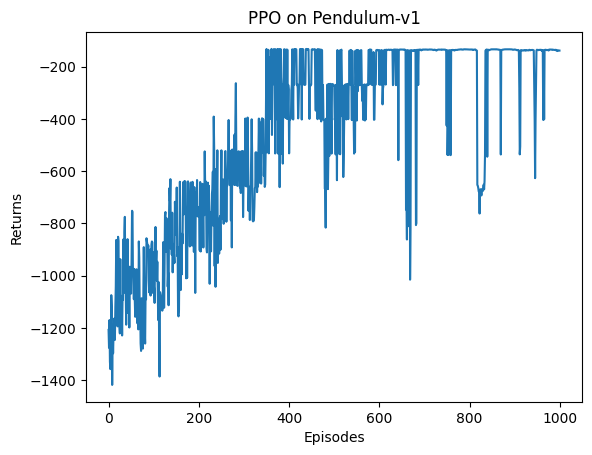

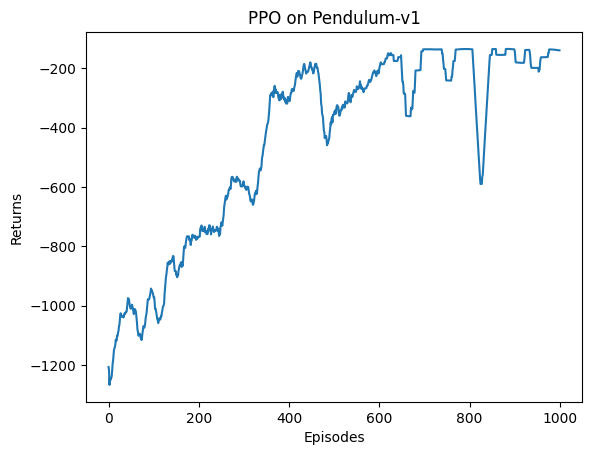

In [34]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()